In [1]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers_time import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Sigmoid, Tanh
import numpy.random as npr
import jax
from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
## X = np.arange(500).reshape(50, 10) * 1.0

# theta = np.eye(10,10) * 1.0

# def f(theta, X):
#     out = X.dot(theta)
#     return out

# def divergence(f, theta_, X_):

#     def my_div(f_):
#         jac = jax.jacrev(f_, 1)
#         return lambda t, x_: np.trace(jac(t, x_))

#     div  = ((jax.vmap(my_div(f), in_axes=(None, 0)) (theta_, X_ )))
#     return div
    
# print(divergence(f, theta, X).shape)
jax.jacfwd

<function jax.api.jacfwd>

In [3]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(100), rng_b = jax.random.PRNGKey(10), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.rng_b = rng_b
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
        self.b_backward_ = jax.vmap(self.b_backward, in_axes=(None, 0))
        self.b_forward_ = jax.vmap(self.b_forward, in_axes=(None, 0))
        
        self.b_backward_s =  lambda theta, x: np.squeeze(self.b_backward(x, theta))
        self.b_forward_s = lambda theta, x: np.squeeze(self.b_forward(x, theta))
        
        self.div_backward_ = jax.vmap(partial(self.divergence, self.b_backward), in_axes=(None, 0))
        self.div_forward_ = jax.vmap(partial(self.divergence, self.b_forward), in_axes=(None, 0))
        
        self.first_iter_fac = 0.0
        
    @staticmethod
    def divergence(f, theta_, X_):

        def my_div(f_):
            jac = jax.jacfwd(f_, 1)
            # this implementation assumes the last cordinate is time
            # we dont want that term in the div
            return lambda t, x_: np.trace(jac(t, x_)[:-1,:-1])

        div  = ((jax.vmap(my_div(f), in_axes=(None, 0)) (theta_, X_ )))
        return div
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
    
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
#     @partial(jit, static_argnums=(0,3))
    def loss_for_trajectory(self, Xt, theta, W, forwards):
        n_, *_ = Xt.shape
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
        if forwards:
            b_minus  = self.b_backward_(self.theta_b, Xt) 
            b_plus = self.b_forward_(theta, Xt)
            div = self.div_backward_(self.theta_b, Xt) 
        else:
            b_minus  = self.b_backward_(theta, Xt)
            b_plus = self.b_forward_(self.theta_f, Xt) * self.first_iter_fac 
            div = -self.div_forward_(self.theta_f, Xt) * self.first_iter_fac 
        
        sign = 1.0 if forwards else -1.0
        
        time_integral = (sign *  (b_plus - b_minus))**2 * self.dt 
        out =  0.5 * time_integral.sum(axis=(1,2)) - (div.sum(axis=(1)) *  self.dt )

        return out

#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(self, theta, batch,  
                       batch_terminal_empirical,
                       H,  forwards):
        
        b = (
            self.b_forward if forwards else (lambda X, theta: -self.b_backward(X, theta))
        )
        
        t, Xt, *W = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, X0=batch,
            N= self.number_time_steps, theta=theta, forwards=forwards
        )
        Ht = silvermans_rule(Xt[:,-1,:-1])
        cross_entropy = -log_kde_pdf_per_point(Xt[:,-1,:-1], batch_terminal_empirical, H) 
        entropy = -log_kde_pdf_per_point(Xt[:,-1,:-1], Xt[:,-1,:-1], Ht) *  0
        main_term = self.loss_for_trajectory(Xt, theta, W, forwards)

        J = np.mean(main_term + cross_entropy - entropy)
        J = np.squeeze(J)
        return J
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            theta, batch,
            batch_terminal_empirical, H ,  forwards
        )

#     @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10, plot=False):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim + 1))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng_b, (-1, self.dim + 1))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        if plot: self.plot_trajectories()
        
        self.first_iter_fac = 0.0
        for i in tqdm(range(IPFP_iterations)):

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params_b = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params_b, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)

            self.theta_b = params_b
            self.first_iter_fac = 1.0

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, batch_f, True
                    )
                params_f = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params_f, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)


            self.theta_f = params_f

            self.loss_f = loss_f
            self.loss_b = loss_b
            if plot: self.plot_trajectories()

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
        
    def plot_trajectories(self):
        bb = lambda X, theta: -self.b_backward(X, theta)
        t, Xts = c.sde_solver(
            X0=self.X_0,dt=self.dt,  theta=self.theta_f,
            beta=self.sigma, alfa=self.b_forward, N=self.number_time_steps, forwards=True
        )
        t_, Xts_ = c.sde_solver(
            X0=self.X_1, dt=self.dt,  theta=self.theta_b,
            beta=self.sigma, alfa=bb, N=self.number_time_steps, forwards=False
        )
        
        fn = 14
        fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
        axs[1].set_xlabel("$t$", fontsize=fn)
        axs[1].set_ylabel("$x(t)$", fontsize=fn)
        axs[0].set_ylabel("$x(t)$", fontsize=fn)

        tt = axs[1].get_xticks()
        axs[1].set_xticks(tt.flatten() )
        axs[1].set_xticklabels(list(map (lambda x: '{0:.1f}'.format((x)), tt))[::-1])

        for i in range(n):
            label = "$\mathbb{Q}$: Forward process" if i == 0 else None
            axs[0].plot(t.flatten(), Xts[i,:,:-1].flatten(), 'b', alpha=0.03,  label=label)


        for i in range(n):
            label = "$\mathbb{P}$: Reverse process" if i == 0 else None
            axs[1].plot(t_.flatten(), Xts_[i,:, :-1].flatten(), 'r', alpha=0.03, label=label)

        axs[1].legend(fontsize=fn)
        axs[0].legend(fontsize=fn)

        plt.show()    
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

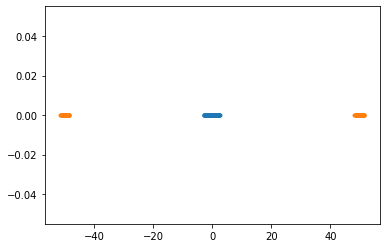

In [4]:
n = 500
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 0
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 50
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) -50
X2 = np.concatenate((X21, X22), axis=0)
X1, X2 = X2, X1

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [5]:
c = cIPFP(X1, X2,  number_time_steps=100, batch_size=500 , step_size = 0.005, weights=[20,20,20], rng = jax.random.PRNGKey(100))

In [6]:
# _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
# opt_state_f = c.opt_init_f(init_params_f)


# c.theta_f = c.get_params_f(opt_state_f)
# c.theta_b = c.get_params_f(opt_state_f) 


# c.inner_loss(c.theta_f, next(c.data_stream()), forwards=True);

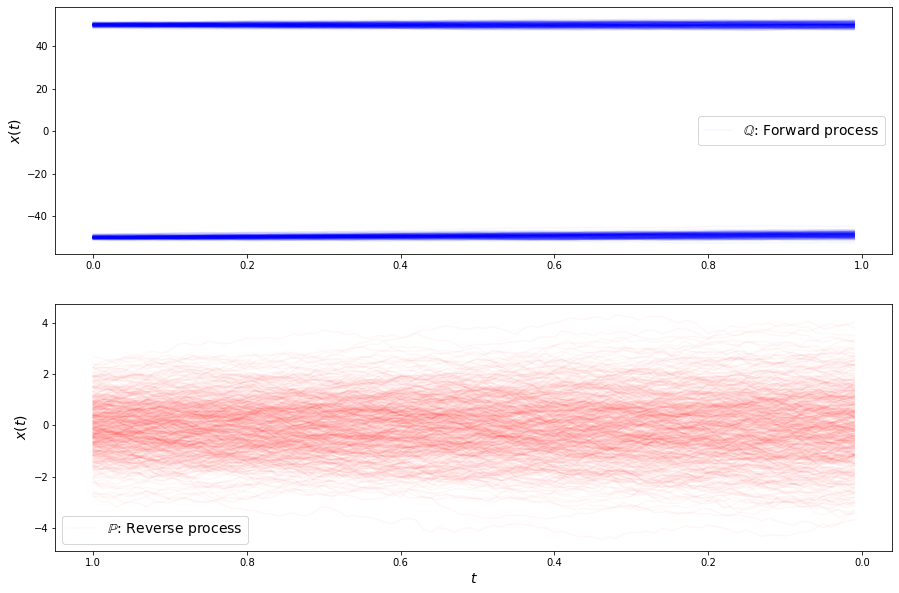

Widget Javascript not detected.  It may not be installed or enabled properly.


loss b 12.67719841003418
loss b 12.666749954223633
loss b 12.66568374633789
loss b 12.66845417022705
loss b 12.650803565979004
loss b 12.677529335021973
loss b 12.662524223327637
loss b 12.668705940246582
loss b 12.670475006103516
loss b 12.66102409362793
loss b 12.655618667602539
loss b 12.670269966125488
loss b 12.66209602355957
loss b 12.674860000610352
loss b 12.660801887512207
loss b 12.657458305358887
loss b 12.642401695251465
loss b 12.67192268371582
loss b 12.681105613708496
loss b 12.671481132507324
loss b 12.658190727233887
loss b 12.660382270812988
loss f 20792.181640625
loss f 18748.251953125
loss f 16894.912109375
loss f 15364.4814453125
loss f 14073.6015625
loss f 12958.77734375
loss f 11913.1005859375
loss f 10937.0322265625
loss f 10130.095703125
loss f 9237.4228515625
loss f 8473.3515625
loss f 7746.3916015625
loss f 7038.69677734375
loss f 6372.82763671875
loss f 5747.08203125
loss f 5143.84375
loss f 4613.59228515625
loss f 4088.46923828125
loss f 3663.927734375
loss

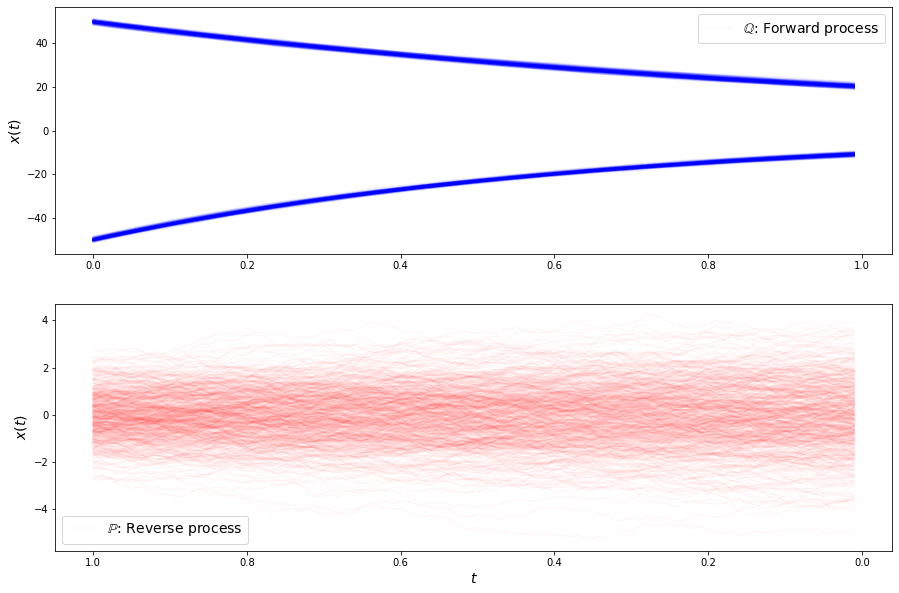

loss b 14.102534294128418
loss b 14.012940406799316
loss b 13.98167610168457
loss b 13.876242637634277
loss b 13.840888023376465
loss b 13.745020866394043
loss b 13.656883239746094
loss b 13.540348052978516
loss b 13.4476900100708
loss b 13.388314247131348
loss b 13.220861434936523
loss b 13.06519603729248
loss b 12.92855453491211
loss b 12.73398208618164
loss b 12.608163833618164
loss b 12.411698341369629
loss b 12.307341575622559
loss b 12.205100059509277
loss b 12.054218292236328
loss b 11.846766471862793
loss b 11.734990119934082
loss b 11.882587432861328
loss f 1479.2681884765625
loss f 1169.51708984375
loss f 937.1262817382812
loss f 773.2711181640625
loss f 655.1161499023438
loss f 566.405517578125
loss f 492.598388671875
loss f 447.0860900878906
loss f 411.47076416015625
loss f 377.2738037109375
loss f 358.4496765136719
loss f 345.1712646484375
loss f 332.4536437988281
loss f 326.68798828125
loss f 321.545654296875
loss f 322.2654113769531
loss f 318.754638671875
loss f 321.617

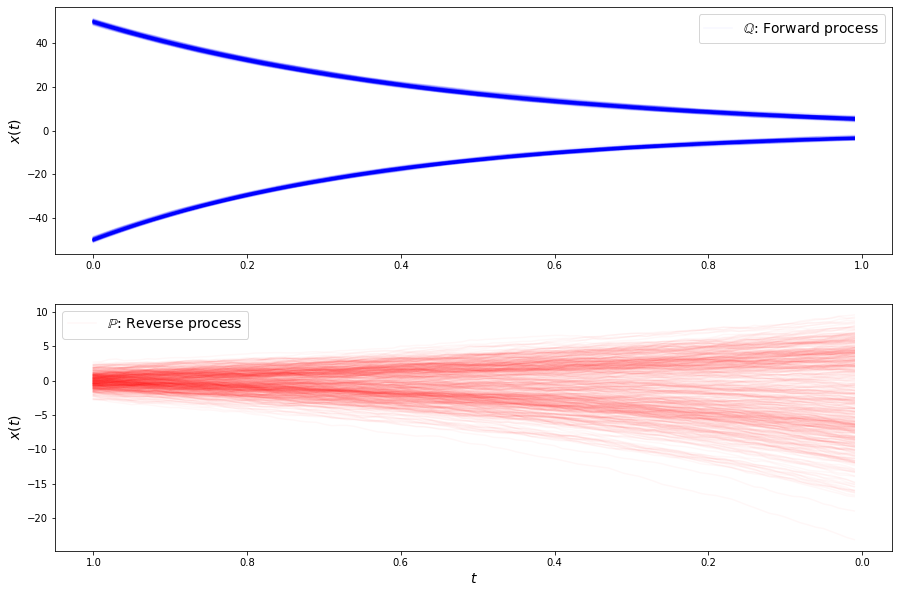

loss b 16.66091537475586
loss b 15.21025562286377
loss b 13.762849807739258
loss b 12.345731735229492
loss b 11.957132339477539
loss b 12.831221580505371
loss b 12.12397575378418
loss b 10.793024063110352
loss b 9.513755798339844
loss b 8.991419792175293
loss b 8.987885475158691
loss b 9.857572555541992
loss b 10.145753860473633
loss b 9.723978996276855
loss b 9.27567195892334
loss b 9.059684753417969
loss b 8.963970184326172
loss b 8.99711799621582
loss b 8.903182029724121
loss b 8.91405200958252
loss b 8.969388008117676
loss b 8.954903602600098
loss f 47.275062561035156
loss f 40.49943161010742
loss f 40.3156623840332
loss f 37.551856994628906
loss f 37.543270111083984
loss f 36.022789001464844
loss f 36.02009582519531
loss f 34.37015151977539
loss f 33.909969329833984
loss f 34.600990295410156
loss f 33.81025314331055
loss f 34.940635681152344
loss f 33.537410736083984
loss f 34.05152893066406
loss f 33.5078010559082
loss f 33.13004684448242
loss f 33.15164566040039
loss f 32.623165

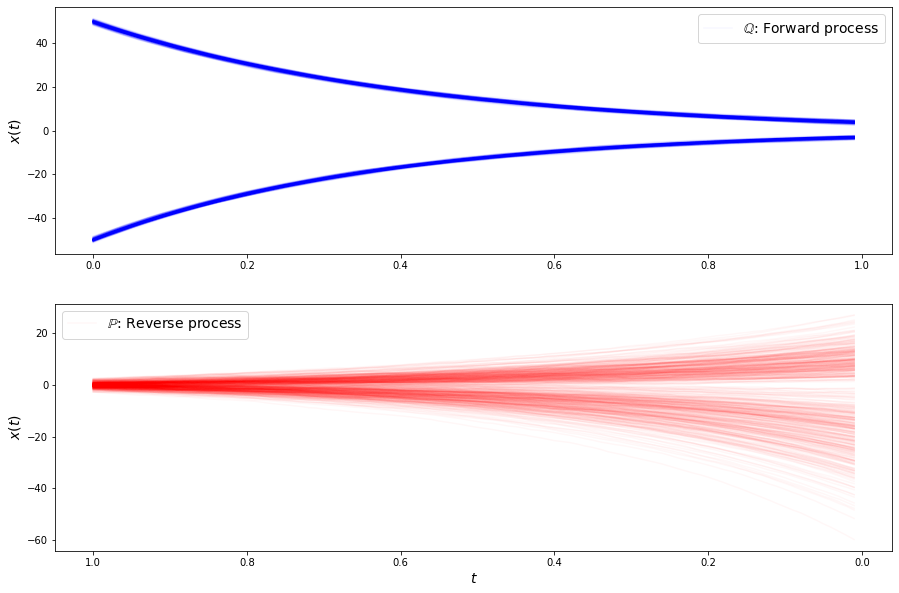

loss b 9.50843334197998
loss b 8.906084060668945
loss b 8.165253639221191
loss b 7.6965227127075195
loss b 7.868459224700928
loss b 8.227212905883789
loss b 8.503828048706055
loss b 8.155048370361328
loss b 7.74943208694458
loss b 7.607662677764893
loss b 7.574217796325684
loss b 7.70534086227417
loss b 7.739565849304199
loss b 7.950110912322998
loss b 7.835306644439697
loss b 7.811911582946777
loss b 7.726749897003174
loss b 7.618690013885498
loss b 7.383893013000488
loss b 7.54798698425293
loss b 7.525228023529053
loss b 7.468497276306152
loss f 15.663640022277832
loss f 15.034902572631836
loss f 14.147907257080078
loss f 13.579841613769531
loss f 13.731163024902344
loss f 12.649739265441895
loss f 11.976641654968262
loss f 11.409500122070312
loss f 10.559980392456055
loss f 10.48431396484375
loss f 9.579626083374023
loss f 9.297143936157227
loss f 8.773697853088379
loss f 8.802785873413086
loss f 8.553255081176758
loss f 7.848445892333984
loss f 7.583893775939941
loss f 7.5929455757

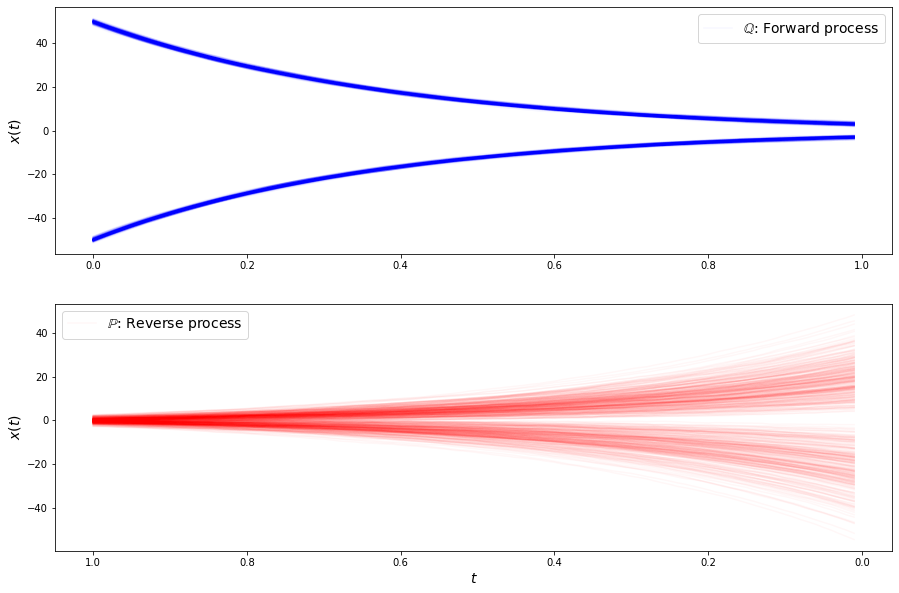

loss b 7.007194519042969
loss b 6.821918964385986
loss b 6.888711929321289
loss b 7.069060802459717
loss b 6.97675085067749
loss b 6.918393135070801
loss b 6.955440044403076
loss b 6.828485012054443
loss b 6.778552055358887
loss b 6.79818058013916
loss b 6.8842597007751465
loss b 6.821426868438721
loss b 6.837195873260498
loss b 6.6934709548950195
loss b 6.758939266204834
loss b 6.799983024597168
loss b 6.683772087097168
loss b 6.749211311340332
loss b 6.7106781005859375
loss b 6.685445308685303
loss b 6.640944004058838
loss b 6.718544006347656
loss f 6.161168098449707
loss f 5.660710334777832
loss f 5.8473029136657715
loss f 5.814404010772705
loss f 5.876364707946777
loss f 5.793795108795166
loss f 5.967392921447754
loss f 5.639208793640137
loss f 5.7848920822143555
loss f 5.757637977600098
loss f 5.634675025939941
loss f 6.095025062561035
loss f 5.842099666595459
loss f 5.828680992126465
loss f 5.586913108825684
loss f 5.828423023223877
loss f 5.679556846618652
loss f 5.8170719146728

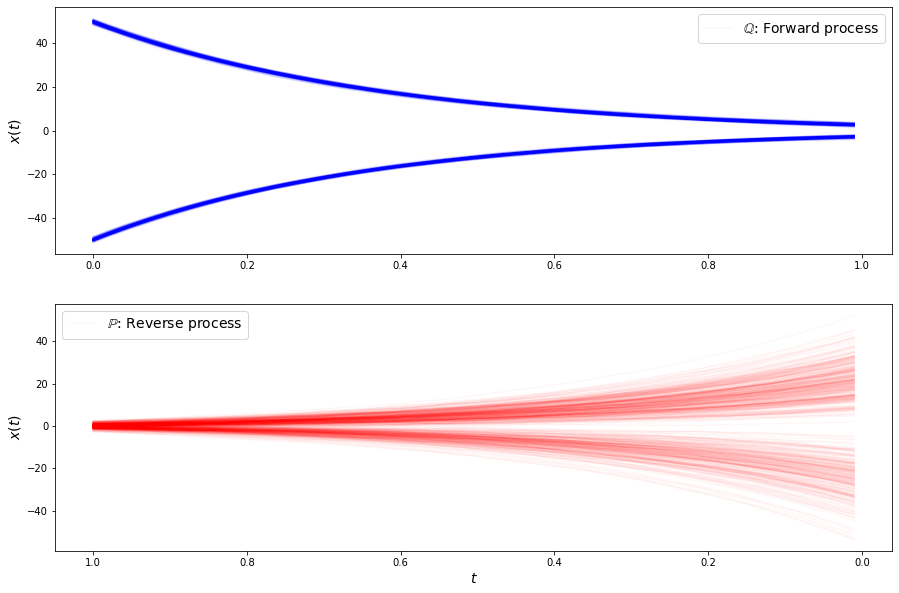

loss b 6.586116790771484
loss b 6.480518817901611
loss b 6.4927520751953125
loss b 6.484395980834961
loss b 6.436206817626953
loss b 6.469090461730957
loss b 6.476004123687744
loss b 6.4608659744262695
loss b 6.563061237335205
loss b 6.615714073181152
loss b 6.581582546234131
loss b 6.529825210571289
loss b 6.427365779876709
loss b 6.516666412353516
loss b 6.441474914550781
loss b 6.419288158416748
loss b 6.433860778808594
loss b 6.514984130859375
loss b 6.453723430633545
loss b 6.426846027374268
loss b 6.4640398025512695
loss b 6.337244510650635
loss f 4.992351055145264
loss f 5.017117977142334
loss f 4.7880964279174805
loss f 4.930613040924072
loss f 4.741911888122559
loss f 4.8863091468811035
loss f 4.545324802398682
loss f 4.666828155517578
loss f 5.004874229431152
loss f 4.7327399253845215
loss f 4.612394332885742
loss f 4.7609333992004395
loss f 4.5368571281433105
loss f 4.462361812591553
loss f 4.613549709320068
loss f 4.397939205169678
loss f 4.647336006164551
loss f 4.64505720

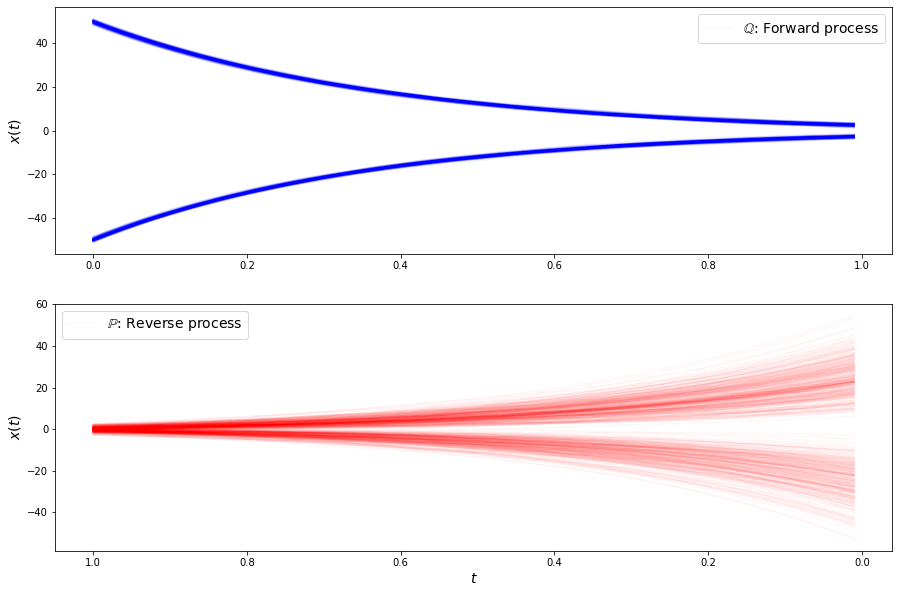

loss b 6.4340009689331055
loss b 6.432802200317383
loss b 6.232017517089844
loss b 6.218107223510742
loss b 6.324509620666504
loss b 6.16959285736084
loss b 6.3300628662109375
loss b 6.3442559242248535
loss b 6.246288776397705
loss b 6.272328853607178
loss b 6.276097774505615
loss b 6.215622901916504
loss b 6.245942115783691
loss b 6.325615406036377
loss b 6.311502933502197
loss b 6.220359802246094
loss b 6.290285110473633
loss b 6.263627052307129
loss b 6.220192909240723
loss b 6.338386058807373
loss b 6.154672145843506
loss b 6.321059703826904
loss f 4.338985443115234
loss f 4.1327080726623535
loss f 4.174276351928711
loss f 4.195658206939697
loss f 4.008047103881836
loss f 4.188676357269287
loss f 3.897189140319824
loss f 4.053515911102295
loss f 4.085896968841553
loss f 4.193383693695068
loss f 4.0122761726379395
loss f 4.070943832397461
loss f 3.958815574645996
loss f 4.131245136260986
loss f 3.8680853843688965
loss f 4.0985331535339355
loss f 4.173154830932617
loss f 4.0112991333

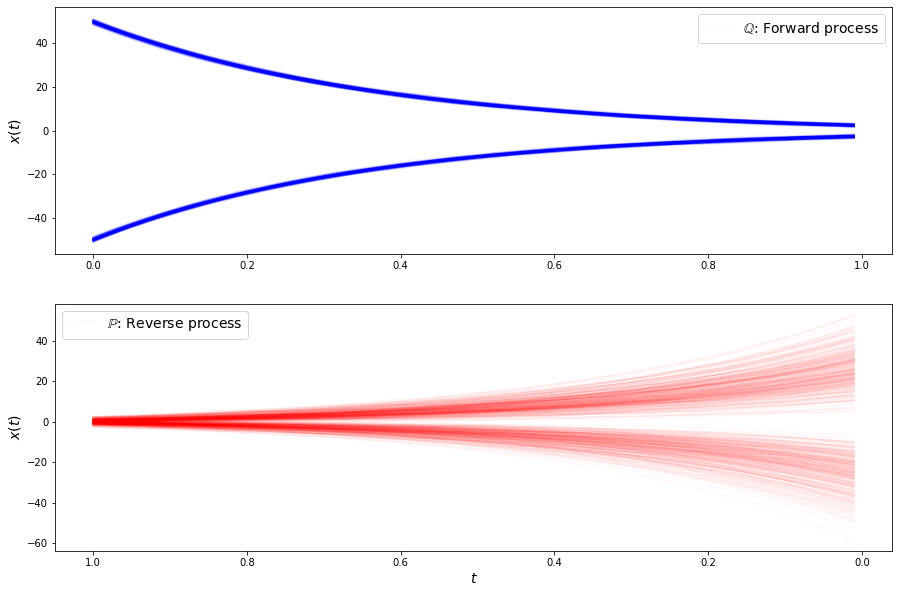

loss b 6.143240451812744
loss b 6.107200622558594
loss b 6.09765100479126
loss b 6.127502918243408
loss b 6.147587299346924
loss b 6.1365275382995605
loss b 6.044905185699463
loss b 6.189034461975098
loss b 6.0906219482421875
loss b 6.02116584777832
loss b 6.152039527893066
loss b 6.017960071563721
loss b 6.014654159545898
loss b 6.042892932891846
loss b 6.102085113525391
loss b 6.1215291023254395
loss b 6.015371799468994
loss b 6.1033220291137695
loss b 6.079831123352051
loss b 6.102895736694336
loss b 6.091081619262695
loss b 6.134467124938965
loss f 3.742595911026001
loss f 3.7061386108398438
loss f 3.6278529167175293
loss f 3.5806384086608887
loss f 3.6201744079589844
loss f 3.726135730743408
loss f 3.5298221111297607
loss f 3.509667158126831
loss f 3.5489344596862793
loss f 3.5385801792144775
loss f 3.6491096019744873
loss f 3.544296979904175
loss f 3.5181920528411865
loss f 3.39532208442688
loss f 3.490663766860962
loss f 3.5225610733032227
loss f 3.5966074466705322
loss f 3.5763

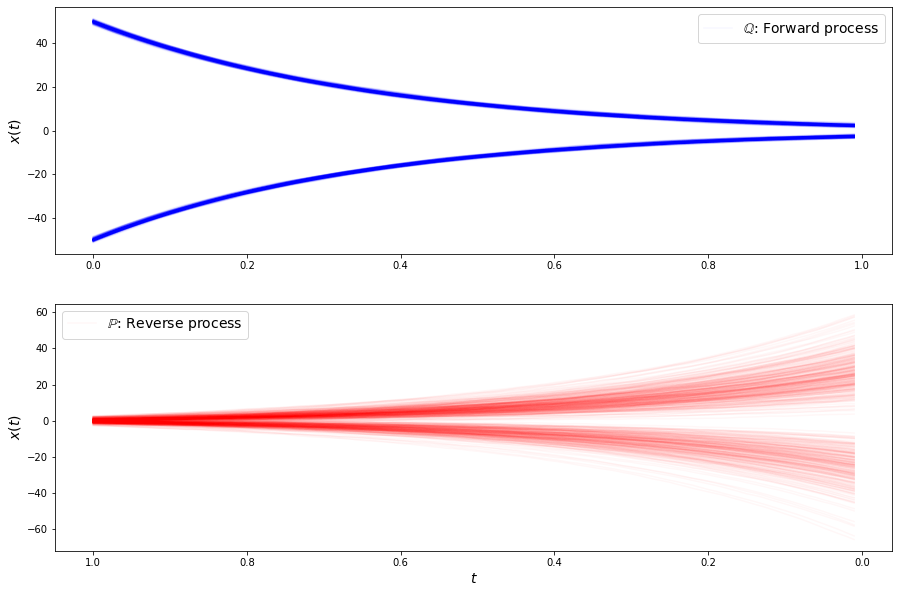

loss b 5.857935905456543
loss b 5.953981399536133
loss b 5.930613040924072
loss b 6.0045623779296875
loss b 5.940281391143799
loss b 5.850818157196045
loss b 5.884766101837158
loss b 5.9593658447265625
loss b 5.98129415512085
loss b 5.916654109954834
loss b 5.866582870483398
loss b 5.973688125610352
loss b 5.834148406982422
loss b 6.026519775390625
loss b 5.876705646514893
loss b 5.904811382293701
loss b 5.894357681274414
loss b 5.913880348205566
loss b 5.934732913970947
loss b 5.923305034637451
loss b 6.031091213226318
loss b 5.976129055023193
loss f 3.1791858673095703
loss f 3.373595952987671
loss f 3.2821123600006104
loss f 3.2898712158203125
loss f 3.1893794536590576
loss f 3.16513991355896
loss f 3.3409364223480225
loss f 3.2185585498809814
loss f 3.248178482055664
loss f 3.1917929649353027
loss f 3.047558069229126
loss f 3.18163800239563
loss f 3.1851959228515625
loss f 3.051095724105835
loss f 3.1222620010375977
loss f 3.1088368892669678
loss f 3.1788744926452637
loss f 3.055792

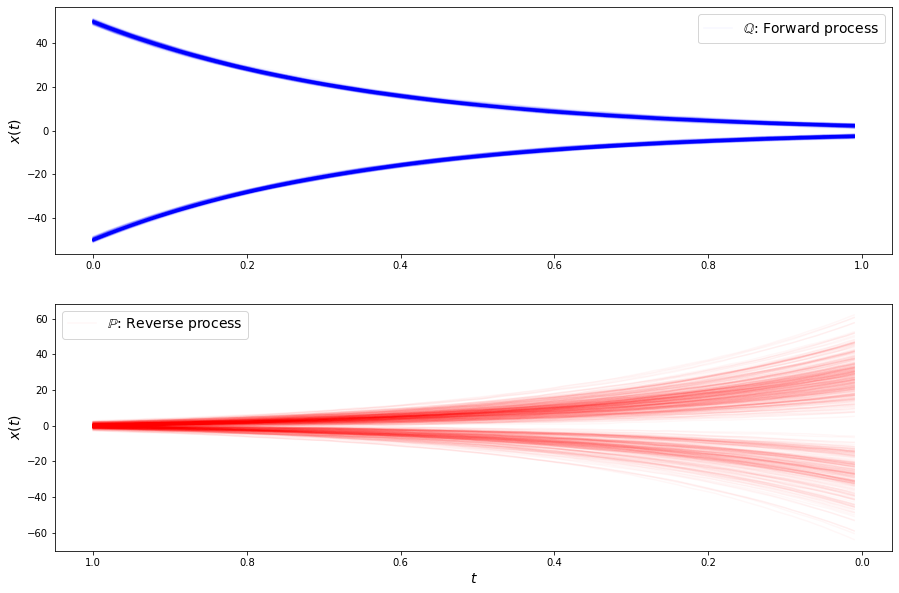

loss b 5.813329696655273
loss b 5.736103534698486
loss b 5.843112468719482
loss b 5.707282066345215
loss b 5.791455268859863
loss b 5.765322685241699
loss b 5.860203266143799
loss b 5.866573810577393
loss b 5.77935791015625
loss b 5.793398857116699
loss b 5.768691539764404
loss b 5.766077995300293
loss b 5.8248114585876465
loss b 5.836946964263916
loss b 5.834732532501221
loss b 5.717410087585449
loss b 5.783506870269775
loss b 5.647558212280273
loss b 5.8308329582214355
loss b 5.732390880584717
loss b 5.851422309875488
loss b 5.7898149490356445
loss f 3.0965723991394043
loss f 2.969125986099243
loss f 2.9398069381713867
loss f 2.984468936920166
loss f 2.8893113136291504
loss f 2.974857807159424
loss f 2.9059481620788574
loss f 2.8514134883880615
loss f 2.8614914417266846
loss f 2.8501410484313965
loss f 2.973801612854004
loss f 2.7835114002227783
loss f 2.8528308868408203
loss f 2.793083906173706
loss f 2.8358376026153564
loss f 2.92802357673645
loss f 2.7480878829956055
loss f 2.8010

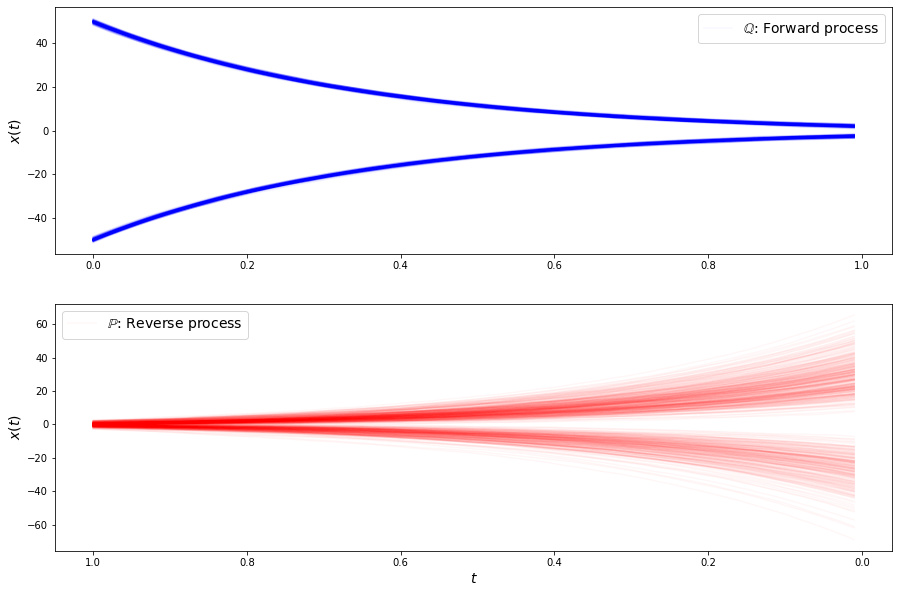

loss b 5.657318115234375
loss b 5.712100505828857
loss b 5.665092945098877
loss b 5.625185012817383
loss b 5.6278862953186035
loss b 5.547573089599609
loss b 5.606898307800293
loss b 5.610515117645264
loss b 5.734475135803223
loss b 5.650034427642822
loss b 5.560789585113525
loss b 5.46371603012085
loss b 5.635552883148193
loss b 5.542555809020996
loss b 5.58431339263916
loss b 5.675694942474365
loss b 5.603199005126953
loss b 5.497574806213379
loss b 5.6098952293396
loss b 5.599180221557617
loss b 5.683107852935791
loss b 5.584475040435791
loss f 2.7722415924072266
loss f 2.76921010017395
loss f 2.687753915786743
loss f 2.672170639038086
loss f 2.661588191986084
loss f 2.6480085849761963
loss f 2.705980062484741
loss f 2.645909547805786
loss f 2.5686511993408203
loss f 2.576298952102661
loss f 2.559054136276245
loss f 2.5650999546051025
loss f 2.531872510910034
loss f 2.6302831172943115
loss f 2.6450037956237793
loss f 2.6181094646453857
loss f 2.7292275428771973
loss f 2.688735961914

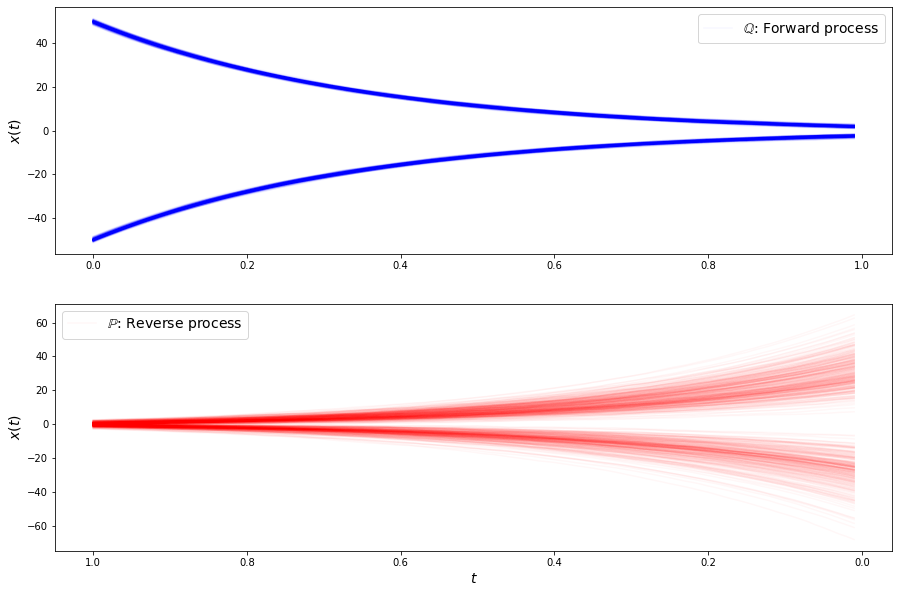

loss b 5.431985378265381
loss b 5.444500923156738
loss b 5.391255855560303
loss b 5.454535961151123
loss b 5.353358268737793
loss b 5.455638885498047
loss b 5.486073017120361
loss b 5.437219142913818
loss b 5.4890666007995605
loss b 5.497547626495361
loss b 5.435414791107178
loss b 5.520033836364746
loss b 5.418467998504639
loss b 5.498961925506592
loss b 5.376747131347656
loss b 5.415371894836426
loss b 5.369042873382568
loss b 5.41038703918457
loss b 5.467983722686768
loss b 5.438120365142822
loss b 5.492137432098389
loss b 5.479630947113037
loss f 2.507558584213257
loss f 2.538743019104004
loss f 2.48114275932312
loss f 2.6114630699157715
loss f 2.4853155612945557
loss f 2.416578531265259
loss f 2.533557891845703
loss f 2.4528987407684326
loss f 2.5025253295898438
loss f 2.477911949157715
loss f 2.419830083847046
loss f 2.433135509490967
loss f 2.4207470417022705
loss f 2.48466420173645
loss f 2.38213849067688
loss f 2.555246114730835
loss f 2.428494453430176
loss f 2.48904204368591

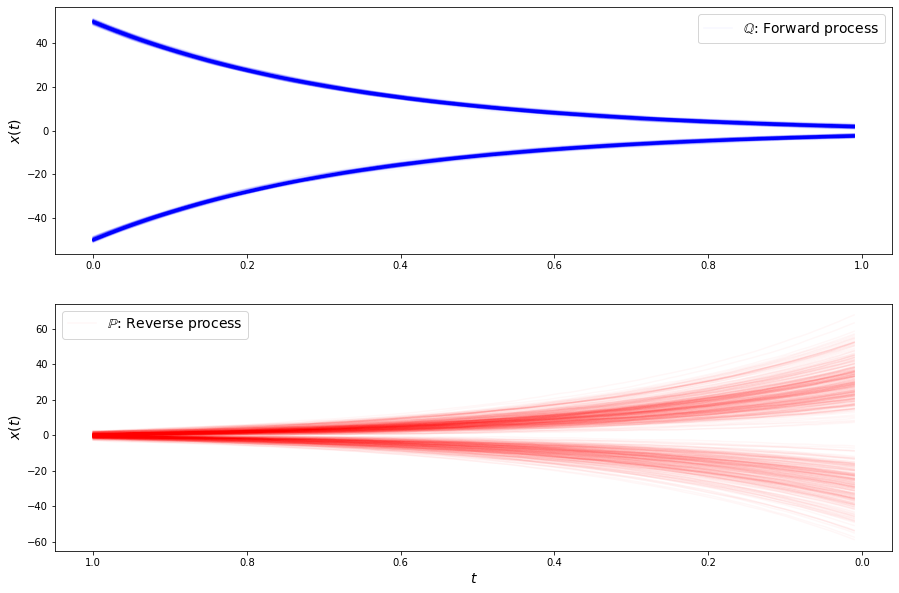

loss b 5.211128234863281
loss b 5.300428867340088
loss b 5.318108081817627
loss b 5.468344688415527
loss b 5.413093090057373
loss b 5.316387176513672
loss b 5.38199520111084
loss b 5.248417854309082
loss b 5.330820560455322
loss b 5.327331066131592
loss b 5.240080833435059
loss b 5.403482437133789
loss b 5.339951992034912
loss b 5.296558856964111
loss b 5.346329689025879
loss b 5.3970627784729
loss b 5.349483966827393
loss b 5.282920837402344
loss b 5.352993011474609
loss b 5.399932384490967
loss b 5.2918829917907715
loss b 5.305920124053955
loss f 2.418504476547241
loss f 2.3544983863830566
loss f 2.339484453201294
loss f 2.3300983905792236
loss f 2.400695562362671
loss f 2.3449809551239014
loss f 2.3198537826538086
loss f 2.4137024879455566
loss f 2.436645984649658
loss f 2.352574110031128
loss f 2.3623557090759277
loss f 2.2812647819519043
loss f 2.373791456222534
loss f 2.3468949794769287
loss f 2.321026086807251
loss f 2.254305601119995
loss f 2.347654342651367
loss f 2.3415389060

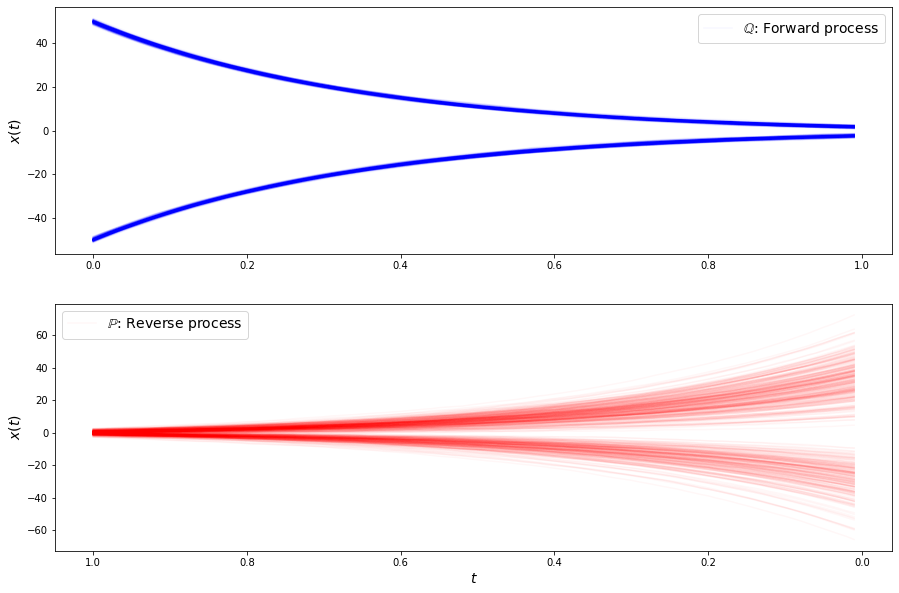

loss b 5.24934196472168
loss b 5.163824081420898
loss b 5.16411018371582
loss b 5.339925765991211
loss b 5.232320785522461
loss b 5.257540225982666
loss b 5.368046283721924
loss b 5.348184108734131
loss b 5.079319477081299
loss b 5.199504852294922
loss b 5.215076923370361
loss b 5.2464280128479
loss b 5.272351264953613
loss b 5.2090606689453125
loss b 5.30652379989624
loss b 5.230358600616455
loss b 5.2943115234375
loss b 5.172138214111328
loss b 5.251591205596924
loss b 5.1961350440979
loss b 5.246137619018555
loss b 5.279419898986816
loss f 2.32680344581604
loss f 2.25285005569458
loss f 2.238665819168091
loss f 2.280550718307495
loss f 2.254528045654297
loss f 2.2046854496002197
loss f 2.2698261737823486
loss f 2.2060844898223877
loss f 2.1962857246398926
loss f 2.253817081451416
loss f 2.187692165374756
loss f 2.1943631172180176
loss f 2.208463430404663
loss f 2.2071115970611572
loss f 2.1418614387512207
loss f 2.1778368949890137
loss f 2.2717409133911133
loss f 2.166841983795166
l

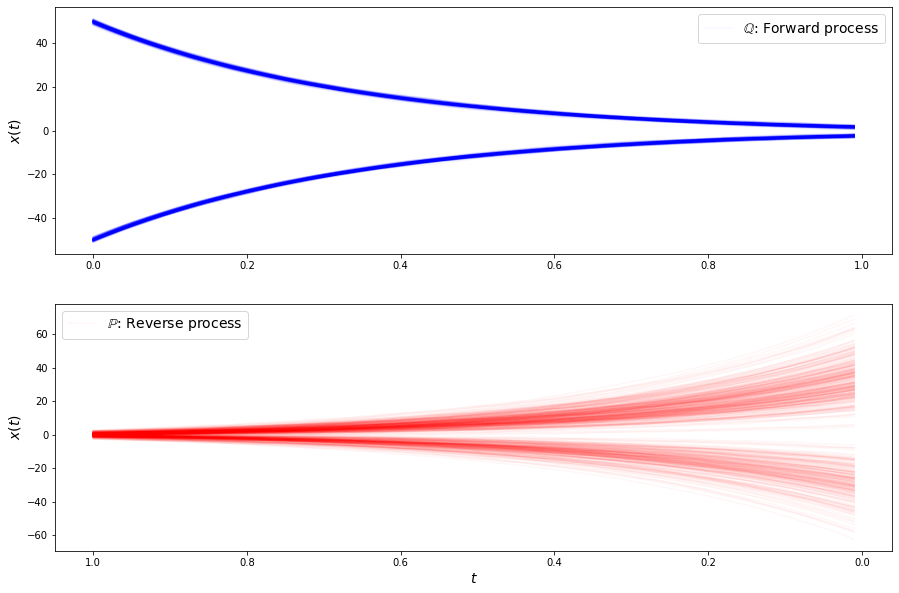

loss b 5.111629486083984
loss b 5.134113788604736
loss b 5.0617852210998535
loss b 5.190301895141602
loss b 5.0524983406066895
loss b 5.1393280029296875
loss b 5.0339226722717285
loss b 5.053953170776367
loss b 5.156933784484863
loss b 5.125642776489258
loss b 5.171661853790283
loss b 5.126319885253906
loss b 5.074807167053223
loss b 5.112788200378418
loss b 5.158721923828125
loss b 5.098714828491211
loss b 5.188924789428711
loss b 5.084442138671875
loss b 5.1407036781311035
loss b 5.08233118057251
loss b 5.128115177154541
loss b 5.106033802032471
loss f 2.1650984287261963
loss f 2.1614322662353516
loss f 2.179548740386963
loss f 2.186760902404785
loss f 2.0844833850860596
loss f 2.113961935043335
loss f 2.1253135204315186
loss f 2.124053716659546
loss f 2.067558526992798
loss f 2.1013777256011963
loss f 2.0418710708618164
loss f 2.1381630897521973
loss f 2.043955087661743
loss f 2.1334612369537354
loss f 2.0239410400390625
loss f 2.0646932125091553
loss f 2.0215582847595215
loss f 2.0

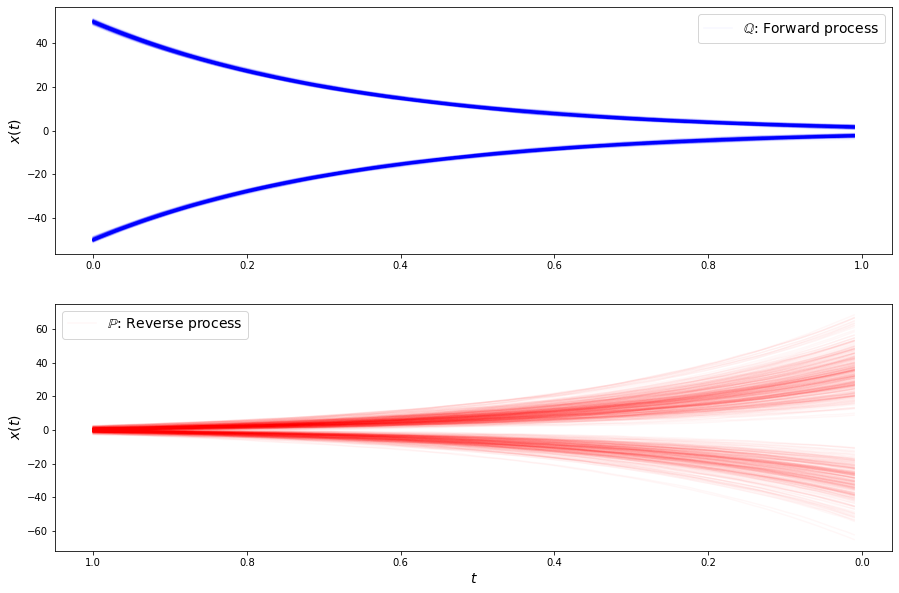

loss b 5.009860992431641
loss b 5.065489768981934
loss b 4.937346935272217
loss b 5.085572719573975
loss b 5.0670905113220215
loss b 5.050786972045898
loss b 4.99150276184082
loss b 5.008006572723389
loss b 5.0437541007995605
loss b 5.067065715789795
loss b 4.915737628936768
loss b 5.122488975524902
loss b 4.920797824859619
loss b 4.961692810058594
loss b 5.049104690551758
loss b 4.9911627769470215
loss b 5.001280784606934
loss b 4.975283622741699
loss b 5.047872066497803
loss b 4.890295028686523
loss b 4.9622578620910645
loss b 5.020964622497559
loss f 2.0950381755828857
loss f 1.983927845954895
loss f 2.000803232192993
loss f 2.047847270965576
loss f 2.0863640308380127
loss f 2.0242762565612793
loss f 2.0107951164245605
loss f 2.018418788909912
loss f 2.0264153480529785
loss f 1.941762924194336
loss f 1.946566104888916
loss f 2.004487991333008
loss f 2.0245201587677
loss f 2.0078346729278564
loss f 1.9548401832580566
loss f 1.9806817770004272
loss f 2.0347063541412354
loss f 1.989873

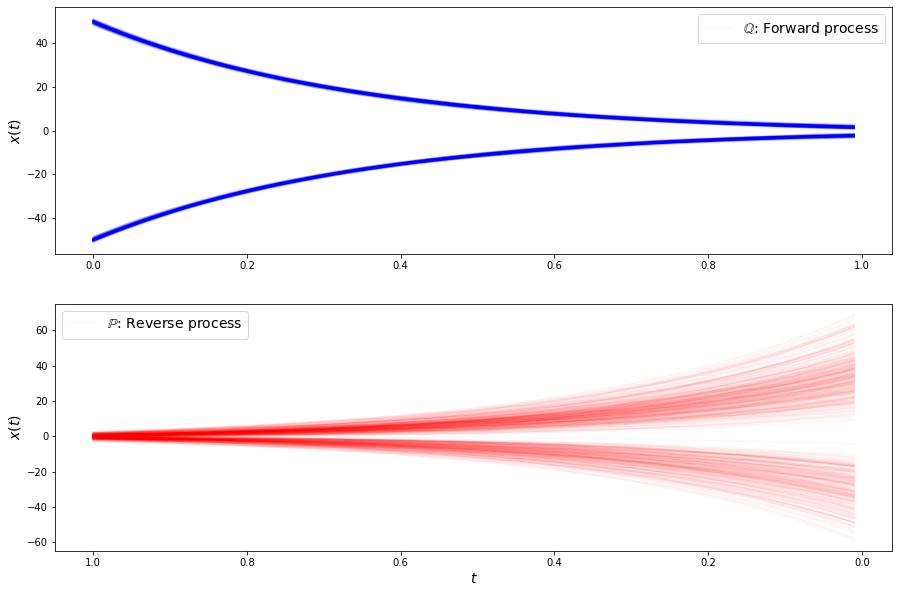

loss b 4.904468059539795
loss b 4.940360069274902
loss b 5.038309097290039
loss b 4.983104705810547
loss b 4.845523834228516
loss b 4.9503960609436035
loss b 4.918932914733887
loss b 4.988521099090576
loss b 4.866365909576416
loss b 4.936469078063965
loss b 4.879306793212891
loss b 4.84810209274292
loss b 4.950148105621338
loss b 4.989296913146973
loss b 4.979669570922852
loss b 4.903066158294678
loss b 4.860642910003662
loss b 4.836245059967041
loss b 4.988266944885254
loss b 4.991921424865723
loss b 4.929277420043945
loss b 4.923373222351074
loss f 1.9485969543457031
loss f 1.9912705421447754
loss f 1.9541219472885132
loss f 1.9986299276351929
loss f 1.9079596996307373
loss f 2.003234386444092
loss f 1.942513108253479
loss f 1.8965259790420532
loss f 1.925302505493164
loss f 1.9257103204727173
loss f 1.8741564750671387
loss f 1.8816360235214233
loss f 1.9282972812652588
loss f 1.8542702198028564
loss f 1.8726379871368408
loss f 1.8878660202026367
loss f 1.8190758228302002
loss f 1.91

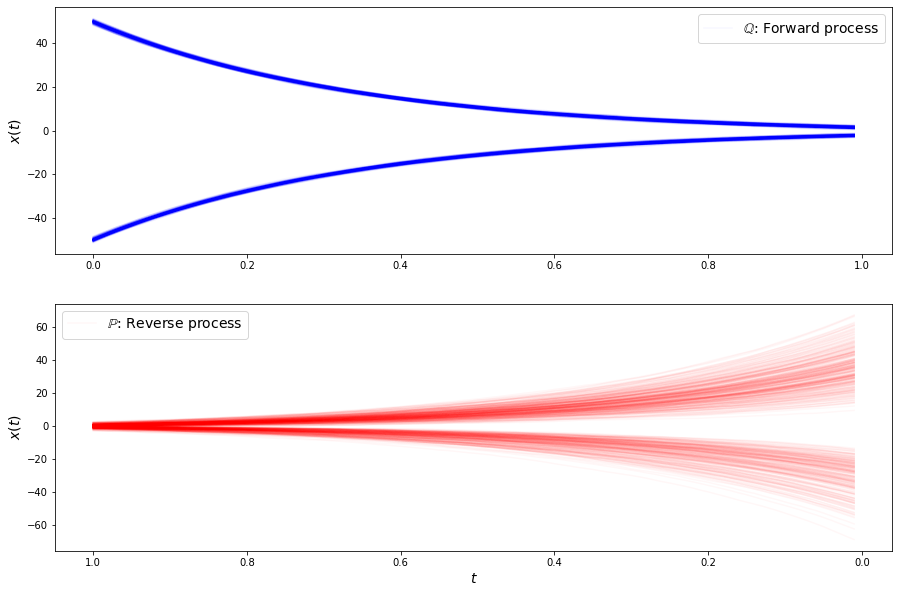

loss b 4.864649772644043
loss b 4.915844917297363
loss b 4.872733116149902
loss b 4.8239617347717285
loss b 4.813851833343506
loss b 4.927156448364258
loss b 4.812917232513428
loss b 4.883633136749268
loss b 4.927404880523682
loss b 4.805404186248779
loss b 4.879175186157227
loss b 4.834671974182129
loss b 4.825483798980713
loss b 4.84158992767334
loss b 4.8285112380981445
loss b 4.811948776245117
loss b 4.833143711090088
loss b 4.797966003417969
loss b 4.830441951751709
loss b 4.761651039123535
loss b 4.78566312789917
loss b 4.7890214920043945
loss f 1.8749717473983765
loss f 1.8550167083740234
loss f 1.8944551944732666
loss f 1.8620469570159912
loss f 1.8780497312545776
loss f 1.8317862749099731
loss f 1.8904608488082886
loss f 1.875951886177063
loss f 1.8175333738327026
loss f 1.8374320268630981
loss f 1.824703574180603
loss f 1.8631898164749146
loss f 1.7354202270507812
loss f 1.815969705581665
loss f 1.8045376539230347
loss f 1.848087191581726
loss f 1.8222335577011108
loss f 1.82

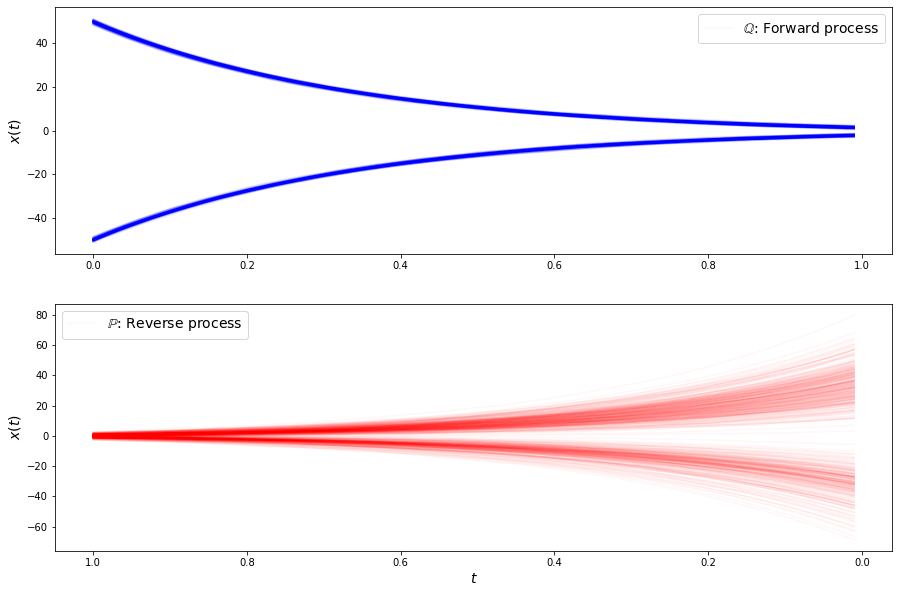

loss b 4.7914276123046875
loss b 4.803792953491211
loss b 4.750300884246826
loss b 4.810479640960693
loss b 4.836699962615967
loss b 4.706697940826416
loss b 4.873456954956055
loss b 4.770843029022217
loss b 4.7999677658081055
loss b 4.772947788238525
loss b 4.774890422821045
loss b 4.744480609893799
loss b 4.782148361206055
loss b 4.8428144454956055
loss b 4.819858074188232
loss b 4.77838134765625
loss b 4.795738220214844
loss b 4.686075210571289
loss b 4.660861015319824
loss b 4.76445198059082
loss b 4.738622188568115
loss b 4.81049919128418
loss f 1.765108346939087
loss f 1.7599482536315918
loss f 1.7161232233047485
loss f 1.7262685298919678
loss f 1.7764445543289185
loss f 1.7730120420455933
loss f 1.7492904663085938
loss f 1.738933801651001
loss f 1.7315890789031982
loss f 1.650405764579773
loss f 1.682541012763977
loss f 1.7251418828964233
loss f 1.7025030851364136
loss f 1.74852454662323
loss f 1.7066024541854858
loss f 1.747667908668518
loss f 1.6631377935409546
loss f 1.695577

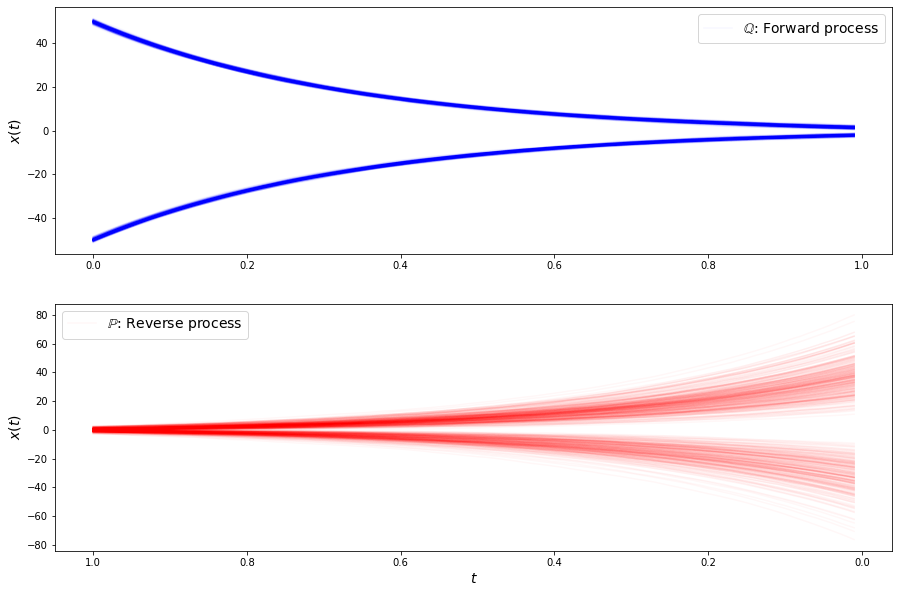

loss b 4.611245632171631
loss b 4.7794342041015625
loss b 4.689435958862305
loss b 4.59212064743042
loss b 4.700035095214844
loss b 4.672191143035889
loss b 4.658613204956055
loss b 4.604404926300049
loss b 4.733798027038574
loss b 4.696784973144531
loss b 4.727435111999512
loss b 4.7139668464660645
loss b 4.719454765319824
loss b 4.619993209838867
loss b 4.669178009033203
loss b 4.627192974090576
loss b 4.602385997772217
loss b 4.707241058349609
loss b 4.65185546875
loss b 4.633674144744873
loss b 4.659217357635498
loss b 4.699171543121338
loss f 1.6891765594482422
loss f 1.6515130996704102
loss f 1.6318790912628174
loss f 1.6241177320480347
loss f 1.6132042407989502
loss f 1.6181399822235107
loss f 1.6808249950408936
loss f 1.6370315551757812
loss f 1.6315381526947021
loss f 1.6525853872299194
loss f 1.6020009517669678
loss f 1.5569360256195068
loss f 1.6458816528320312
loss f 1.5708696842193604
loss f 1.562157392501831
loss f 1.631567358970642
loss f 1.6017359495162964
loss f 1.6526

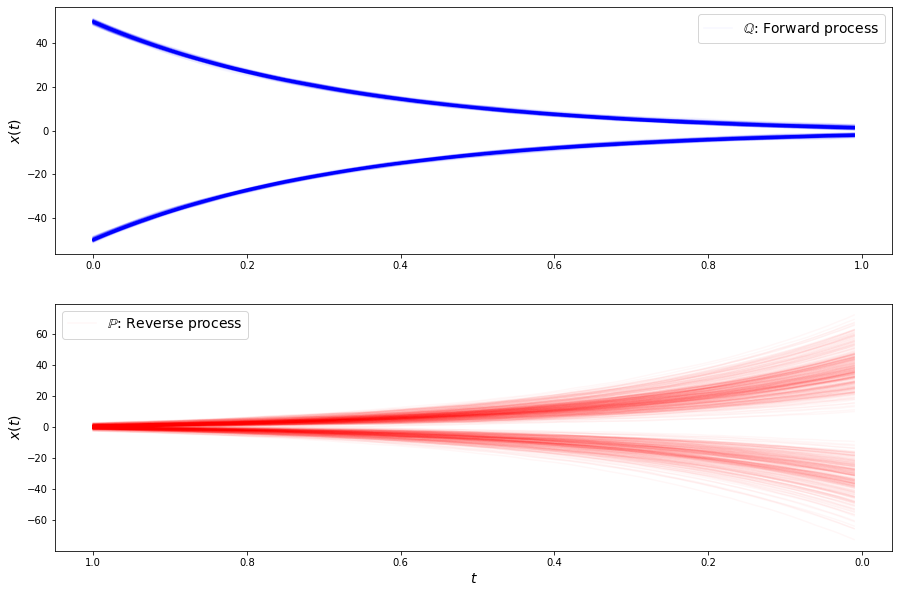

loss b 4.578115940093994
loss b 4.571583271026611
loss b 4.6169939041137695
loss b 4.485445976257324
loss b 4.618118762969971
loss b 4.689422130584717
loss b 4.680850028991699
loss b 4.556794166564941
loss b 4.643556594848633
loss b 4.565270900726318
loss b 4.599618911743164
loss b 4.605361461639404
loss b 4.627803325653076
loss b 4.548584938049316
loss b 4.606425762176514
loss b 4.57572078704834
loss b 4.533392906188965
loss b 4.605546951293945
loss b 4.52977991104126
loss b 4.668157577514648
loss b 4.4963555335998535
loss b 4.508254528045654
loss f 1.5708234310150146
loss f 1.616440773010254
loss f 1.5559357404708862
loss f 1.5247197151184082
loss f 1.5061362981796265
loss f 1.536533236503601
loss f 1.539311170578003
loss f 1.5226370096206665
loss f 1.5373773574829102
loss f 1.4832969903945923
loss f 1.4995652437210083
loss f 1.522897720336914
loss f 1.5016506910324097
loss f 1.5210645198822021
loss f 1.4628808498382568
loss f 1.4745184183120728
loss f 1.464084506034851
loss f 1.4585

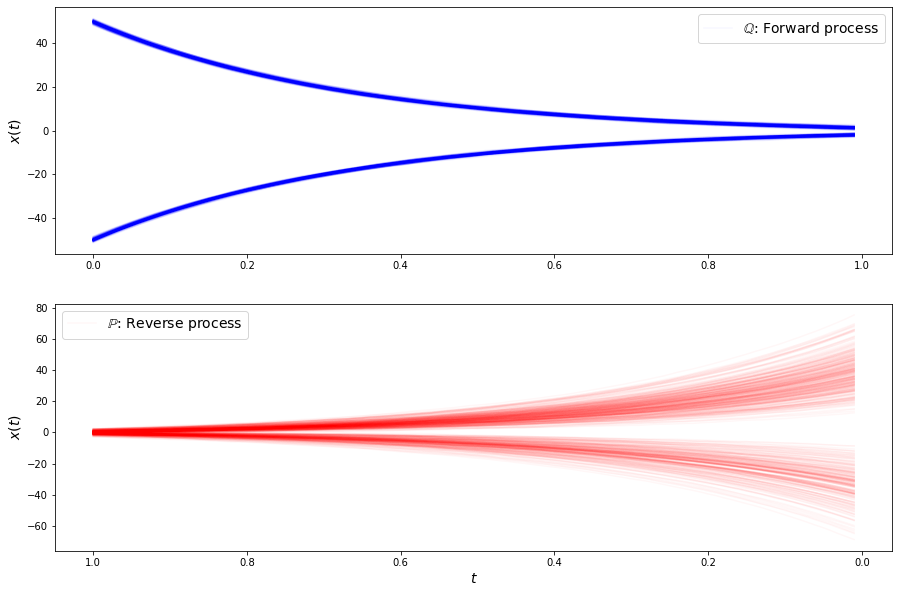

loss b 4.437944412231445
loss b 4.547364711761475
loss b 4.503096103668213
loss b 4.5463337898254395
loss b 4.499965667724609
loss b 4.479663848876953
loss b 4.5295586585998535
loss b 4.653857707977295
loss b 4.487051010131836
loss b 4.333475112915039
loss b 4.44465446472168
loss b 4.584208965301514
loss b 4.533837795257568
loss b 4.594897270202637
loss b 4.476905345916748
loss b 4.557629108428955
loss b 4.49531364440918
loss b 4.57186222076416
loss b 4.501605987548828
loss b 4.4827561378479
loss b 4.438473224639893
loss b 4.64721155166626
loss f 1.4272074699401855
loss f 1.4313105344772339
loss f 1.392890453338623
loss f 1.45561683177948
loss f 1.4499469995498657
loss f 1.4153355360031128
loss f 1.4317797422409058
loss f 1.3884509801864624
loss f 1.4169872999191284
loss f 1.3522858619689941
loss f 1.3968311548233032
loss f 1.367640733718872
loss f 1.3787875175476074
loss f 1.4218369722366333
loss f 1.361261010169983
loss f 1.4372142553329468
loss f 1.3869998455047607
loss f 1.38904798

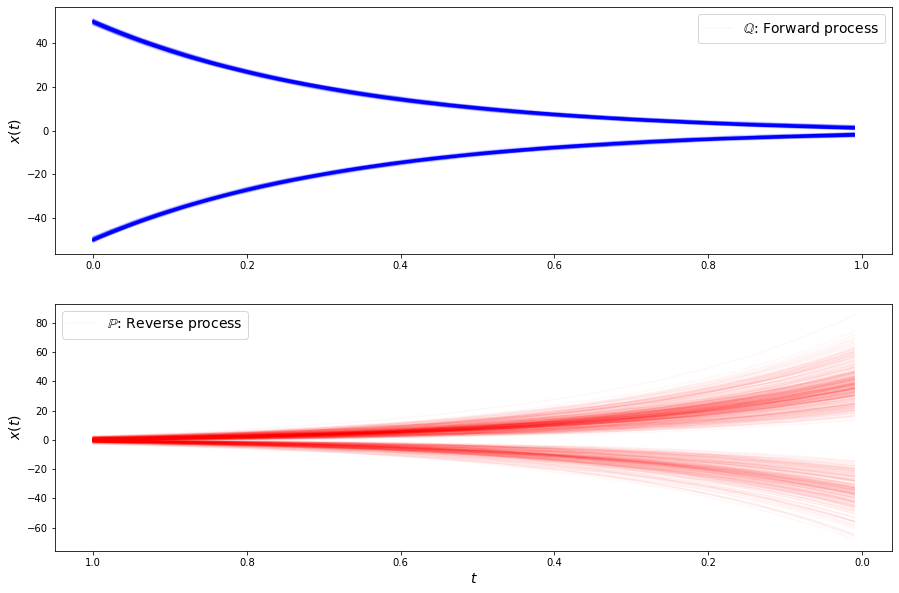

loss b 4.453723430633545
loss b 4.412901878356934
loss b 4.451311111450195
loss b 4.413947105407715
loss b 4.519929885864258
loss b 4.517054080963135
loss b 4.503557205200195
loss b 4.524936199188232
loss b 4.431263446807861
loss b 4.397564888000488
loss b 4.504648208618164
loss b 4.3834028244018555
loss b 4.432275295257568
loss b 4.421861171722412
loss b 4.360458850860596
loss b 4.31732702255249
loss b 4.43648099899292
loss b 4.376368045806885
loss b 4.4239115715026855
loss b 4.409429550170898
loss b 4.358086109161377
loss b 4.392016887664795
loss f 1.4043192863464355
loss f 1.3199028968811035
loss f 1.3069281578063965
loss f 1.3472144603729248
loss f 1.3361514806747437
loss f 1.341715931892395
loss f 1.3119791746139526
loss f 1.3013684749603271
loss f 1.2853399515151978
loss f 1.2973175048828125
loss f 1.2739020586013794
loss f 1.2349364757537842
loss f 1.273032307624817
loss f 1.3266887664794922
loss f 1.2699987888336182
loss f 1.2428237199783325
loss f 1.2326741218566895
loss f 1.1

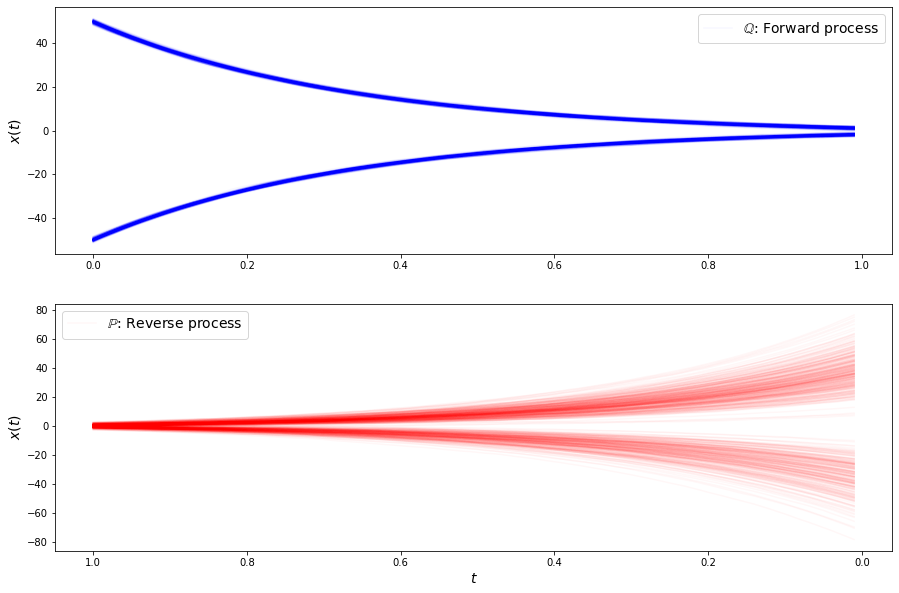

loss b 4.270655155181885
loss b 4.361350059509277
loss b 4.3980913162231445
loss b 4.275722026824951
loss b 4.3321990966796875
loss b 4.296582221984863
loss b 4.330795764923096
loss b 4.250548839569092
loss b 4.212139129638672
loss b 4.325121879577637
loss b 4.350449562072754
loss b 4.363613128662109
loss b 4.285533905029297
loss b 4.37761926651001
loss b 4.283891201019287
loss b 4.2693023681640625
loss b 4.375070095062256
loss b 4.303637981414795
loss b 4.313747406005859
loss b 4.337684631347656
loss b 4.293420791625977
loss b 4.315341949462891
loss f 1.3014408349990845
loss f 1.2418372631072998
loss f 1.2419592142105103
loss f 1.2156132459640503
loss f 1.2378184795379639
loss f 1.1124376058578491
loss f 1.0803391933441162
loss f 1.0613747835159302
loss f 1.0781381130218506
loss f 1.0631672143936157
loss f 1.102723479270935
loss f 1.0794577598571777
loss f 1.0805549621582031
loss f 1.0752477645874023
loss f 1.1194753646850586
loss f 1.0797724723815918
loss f 1.0596950054168701
loss f 

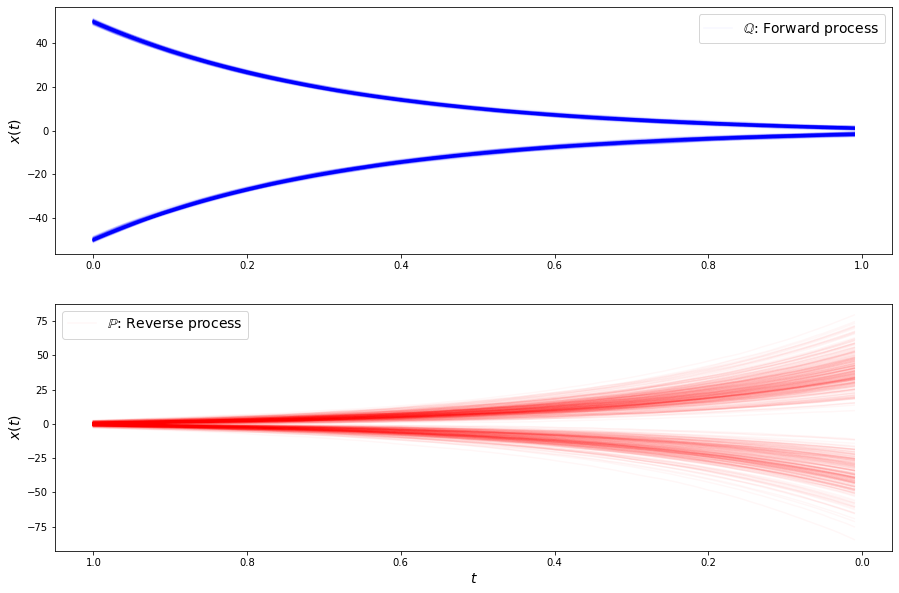

loss b 4.137169361114502
loss b 4.282451152801514
loss b 4.243895053863525
loss b 4.210350036621094
loss b 4.256213665008545
loss b 4.201607704162598
loss b 4.1128830909729
loss b 4.189513206481934
loss b 4.238045692443848
loss b 4.1371049880981445
loss b 4.152505397796631
loss b 4.242341041564941
loss b 4.178994655609131
loss b 4.2543768882751465
loss b 4.201447486877441
loss b 4.115615367889404
loss b 4.163442611694336
loss b 4.154220104217529
loss b 4.185543060302734
loss b 4.160101890563965
loss b 4.161008358001709
loss b 4.144089698791504
loss f 1.0979584455490112
loss f 0.9942618608474731
loss f 0.8910073041915894
loss f 0.9413352012634277
loss f 0.936054527759552
loss f 0.9310694336891174
loss f 0.9113362431526184
loss f 0.902694582939148
loss f 0.8872674107551575
loss f 0.9160839915275574
loss f 0.8559109568595886
loss f 0.8723013401031494
loss f 0.9077582359313965
loss f 0.920245349407196
loss f 0.8892706632614136
loss f 0.8834519386291504
loss f 0.8924596309661865
loss f 0.88

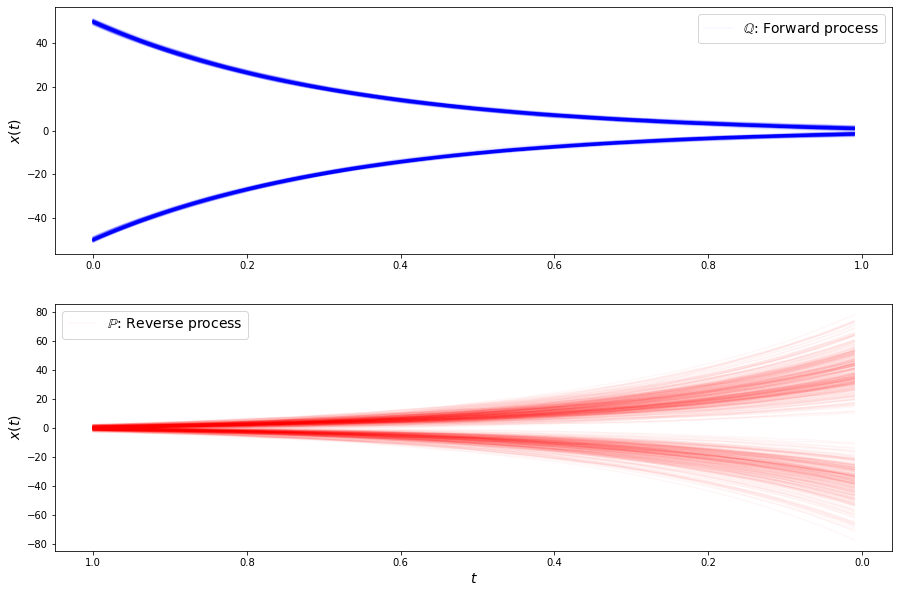

loss b 4.024728298187256
loss b 4.21197509765625
loss b 4.139584541320801
loss b 4.1192545890808105
loss b 4.053882122039795
loss b 3.99849009513855
loss b 4.104300498962402
loss b 4.0603928565979
loss b 4.084911823272705
loss b 4.061855316162109
loss b 3.9570188522338867
loss b 4.045797348022461
loss b 4.006350517272949
loss b 4.109519958496094
loss b 4.022563934326172
loss b 4.010336875915527
loss b 4.070377826690674
loss b 4.038493633270264
loss b 4.0758280754089355
loss b 4.028425216674805
loss b 4.0383710861206055
loss b 4.088242530822754
loss f 0.8367385864257812
loss f 0.8244875073432922
loss f 0.87739497423172
loss f 0.8512076139450073
loss f 0.851492166519165
loss f 0.7798782587051392
loss f 0.7867871522903442
loss f 0.7424677014350891
loss f 0.7798837423324585
loss f 0.7898597121238708
loss f 0.8134816288948059
loss f 0.77248615026474
loss f 0.7945427298545837
loss f 0.7551074028015137
loss f 0.7780376672744751
loss f 0.7292075753211975
loss f 0.7760245203971863
loss f 0.7449

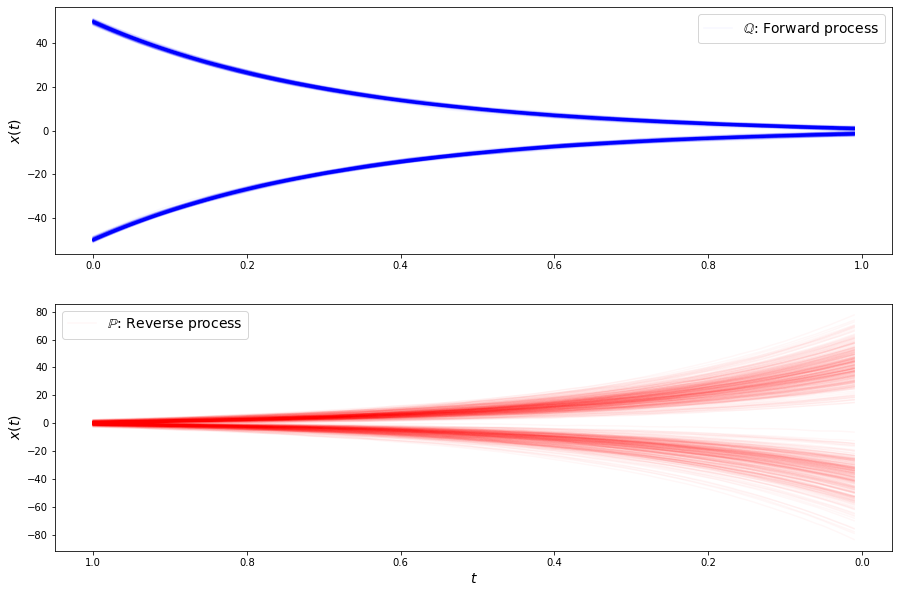

loss b 3.8797364234924316
loss b 4.003985404968262
loss b 4.00008487701416
loss b 3.941457509994507
loss b 3.984833002090454
loss b 3.9966700077056885
loss b 4.014275074005127
loss b 4.021396636962891
loss b 3.939577579498291
loss b 3.973989963531494
loss b 3.9456915855407715
loss b 3.97617506980896
loss b 3.940385580062866
loss b 3.9894537925720215
loss b 4.021227836608887
loss b 3.946277141571045
loss b 3.9621636867523193
loss b 3.9422736167907715
loss b 3.9784154891967773
loss b 4.012106418609619
loss b 4.12330961227417
loss b 4.014498710632324
loss f 0.7150892019271851
loss f 0.7976844906806946
loss f 0.7418794631958008
loss f 0.7162411212921143
loss f 0.750927209854126
loss f 0.7649355530738831
loss f 0.7516154646873474
loss f 0.7320362329483032
loss f 0.7638408541679382
loss f 0.7451667785644531
loss f 0.7305634021759033
loss f 0.7005488872528076
loss f 0.6977308988571167
loss f 0.7291461825370789
loss f 0.6497427225112915
loss f 0.7140067219734192
loss f 0.6861016154289246
loss 

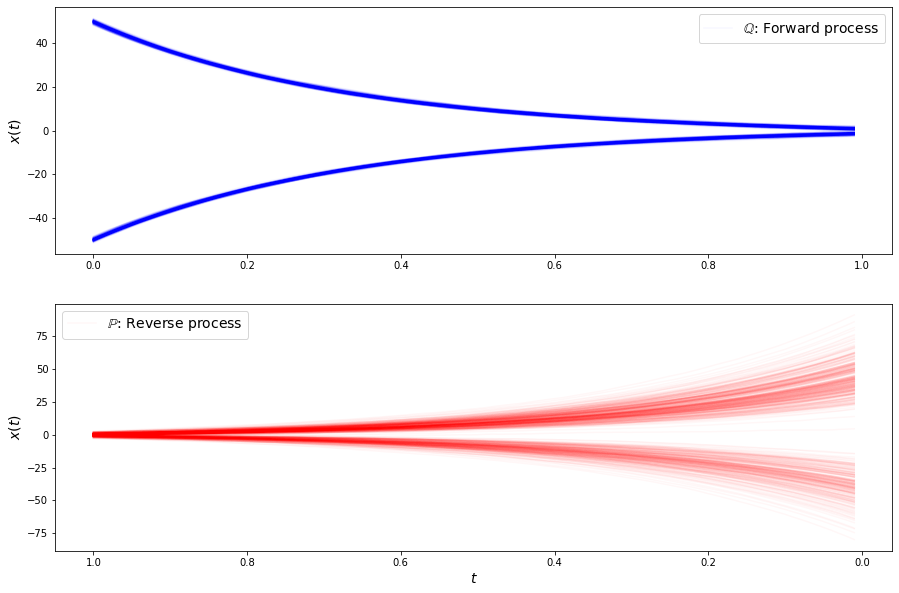

loss b 4.003661155700684
loss b 4.029494762420654
loss b 4.015933036804199
loss b 3.8616700172424316
loss b 3.9000253677368164
loss b 3.92226243019104
loss b 4.006823539733887
loss b 3.9476444721221924
loss b 3.9129538536071777
loss b 3.974466562271118
loss b 3.9217100143432617
loss b 3.8855361938476562
loss b 3.9714531898498535
loss b 3.980086326599121
loss b 3.9395530223846436
loss b 3.9464852809906006
loss b 3.982468605041504
loss b 3.9172184467315674
loss b 3.891077995300293
loss b 3.857008934020996
loss b 3.9115231037139893
loss b 3.9600422382354736
loss f 0.6576704978942871
loss f 0.6143754720687866
loss f 0.604576587677002
loss f 0.6096691489219666
loss f 0.6024888753890991
loss f 0.5940833687782288
loss f 0.5950086116790771
loss f 0.6129736304283142
loss f 0.6024307012557983
loss f 0.6039888262748718
loss f 0.5241037011146545
loss f 0.5855376720428467
loss f 0.6032837629318237
loss f 0.5554248094558716
loss f 0.5932133197784424
loss f 0.5577489733695984
loss f 0.566503524780273

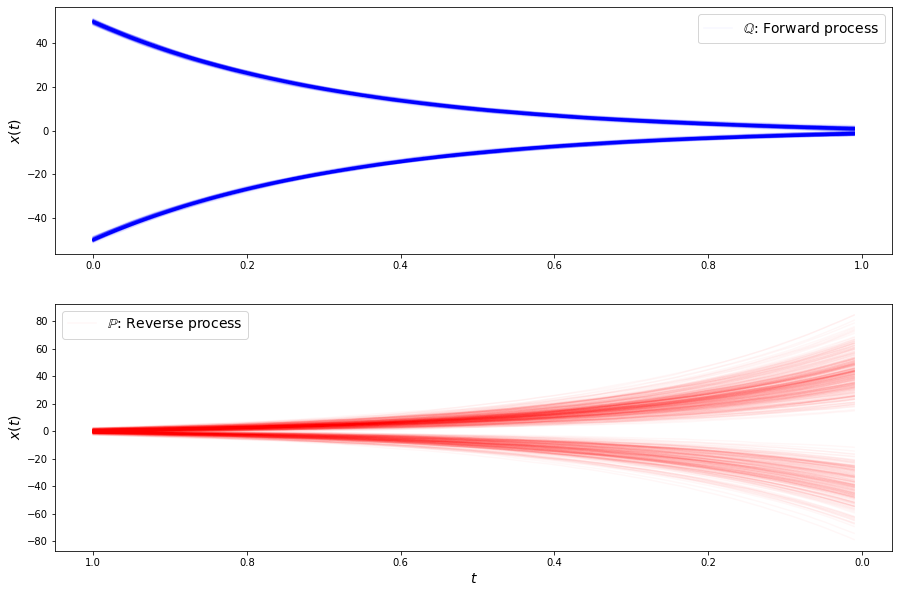

loss b 3.901545524597168
loss b 3.85882306098938
loss b 3.86737322807312
loss b 3.878204107284546
loss b 3.904510974884033
loss b 3.9166135787963867
loss b 3.8495757579803467
loss b 3.9174931049346924
loss b 3.9484329223632812
loss b 3.8947954177856445
loss b 3.8897318840026855
loss b 3.871293306350708
loss b 3.901310443878174
loss b 3.8491716384887695
loss b 3.9074854850769043
loss b 3.938082456588745
loss b 3.872236967086792
loss b 3.846095085144043
loss b 3.9693291187286377
loss b 3.8333404064178467
loss b 3.8176164627075195
loss b 3.861614942550659
loss f 0.5596710443496704
loss f 0.5286336541175842
loss f 0.5378586053848267
loss f 0.5609686374664307
loss f 0.5741044878959656
loss f 0.5042776465415955
loss f 0.5552908778190613
loss f 0.5089861750602722
loss f 0.4999300539493561
loss f 0.5489276051521301
loss f 0.5408613681793213
loss f 0.5098249316215515
loss f 0.5002765655517578
loss f 0.4857616126537323
loss f 0.5153837203979492
loss f 0.5094988346099854
loss f 0.5062882304191589

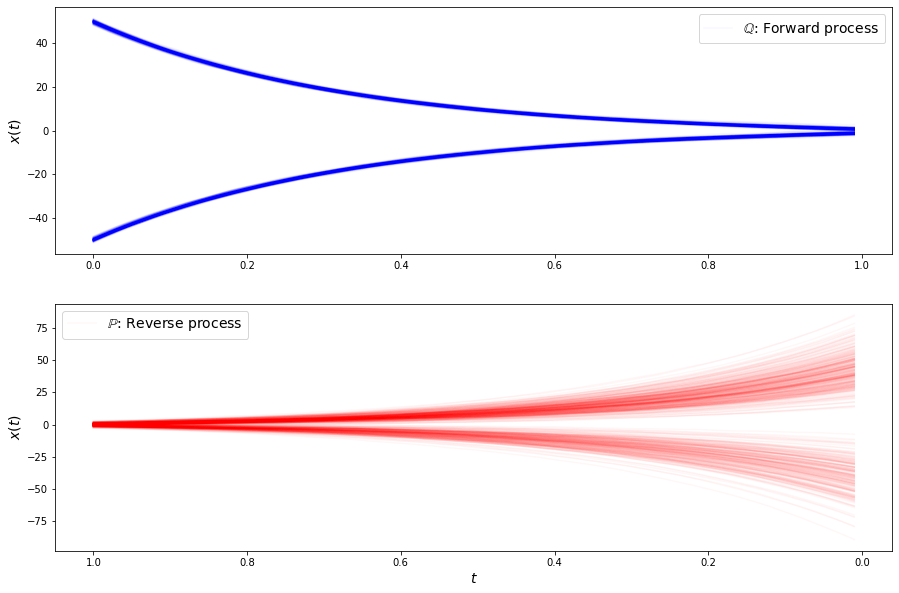

loss b 3.805663585662842
loss b 3.847562551498413
loss b 3.8412158489227295
loss b 3.738274097442627
loss b 3.8431808948516846
loss b 3.7789011001586914
loss b 3.8467226028442383
loss b 3.8183164596557617
loss b 3.864847421646118
loss b 3.810926675796509
loss b 3.731764554977417
loss b 3.7946674823760986
loss b 3.805323600769043
loss b 3.811878204345703
loss b 3.8818719387054443
loss b 3.8404369354248047
loss b 3.8208274841308594
loss b 3.779189109802246
loss b 3.8116812705993652
loss b 3.7582883834838867
loss b 3.8496744632720947
loss b 3.7757506370544434
loss f 0.501483142375946
loss f 0.5140737295150757
loss f 0.49124544858932495
loss f 0.4569433927536011
loss f 0.47452980279922485
loss f 0.43904855847358704
loss f 0.4899662435054779
loss f 0.45335593819618225
loss f 0.49588334560394287
loss f 0.4202634394168854
loss f 0.4698054790496826
loss f 0.4506770670413971
loss f 0.42868223786354065
loss f 0.4546201825141907
loss f 0.43861401081085205
loss f 0.4219219386577606
loss f 0.414256

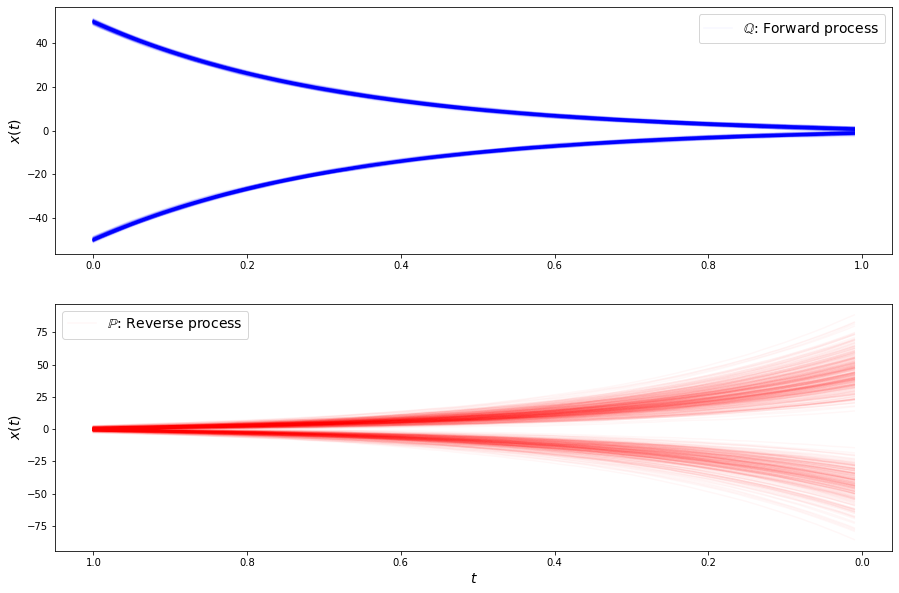

loss b 3.7146596908569336
loss b 3.7774791717529297
loss b 3.8368680477142334
loss b 4.063773155212402
loss b 4.032493591308594
loss b 3.824328899383545
loss b 3.9386861324310303
loss b 4.013673782348633
loss b 3.941232442855835
loss b 3.8311374187469482
loss b 3.980130434036255
loss b 3.961575508117676
loss b 3.9839069843292236
loss b 4.008451461791992
loss b 4.035329818725586
loss b 4.034470081329346
loss b 3.992626428604126
loss b 3.925710439682007
loss b 4.019651412963867
loss b 4.093509674072266
loss b 4.000837802886963
loss b 4.007821083068848
loss f 0.4765259921550751
loss f 0.5150775909423828
loss f 0.48071688413619995
loss f 0.47677236795425415
loss f 0.45677512884140015
loss f 0.4559386968612671
loss f 0.5157455205917358
loss f 0.46468567848205566
loss f 0.4189026951789856
loss f 0.45039352774620056
loss f 0.41629523038864136
loss f 0.4030906558036804
loss f 0.39853334426879883
loss f 0.4458718001842499
loss f 0.3977586627006531
loss f 0.4125170409679413
loss f 0.409442901611

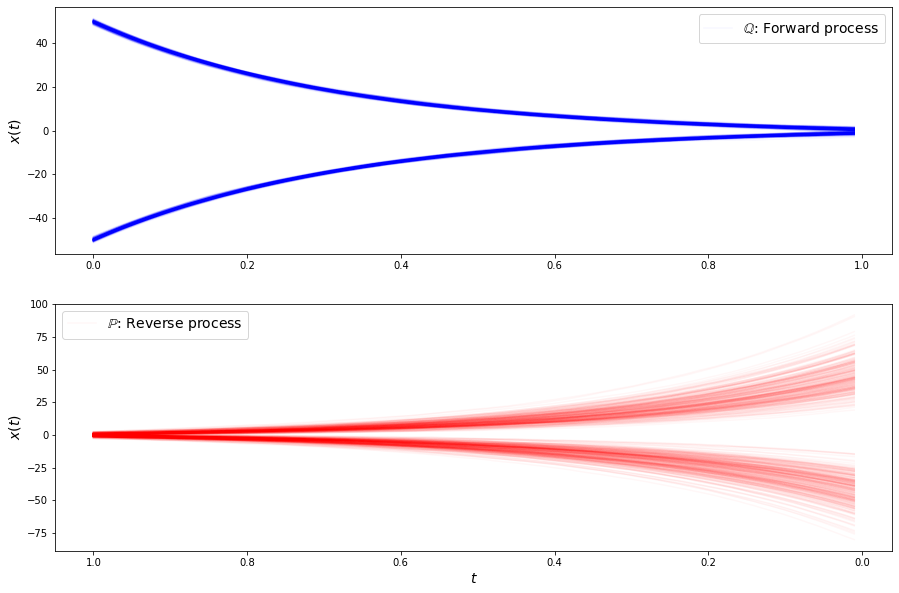

loss b 3.993941068649292
loss b 3.928879737854004
loss b 3.860506534576416
loss b 3.951828956604004
loss b 3.955517053604126
loss b 3.839768171310425
loss b 3.764031410217285
loss b 3.8317885398864746
loss b 3.8742496967315674
loss b 3.761350393295288
loss b 3.805129051208496
loss b 3.9062888622283936
loss b 3.8669495582580566
loss b 3.788571357727051
loss b 3.8405959606170654
loss b 3.8337929248809814
loss b 3.7676773071289062
loss b 3.7498393058776855
loss b 3.8522350788116455
loss b 3.872652769088745
loss b 3.8263778686523438
loss b 3.7904465198516846
loss f 0.4147067070007324
loss f 0.37546226382255554
loss f 0.3717925548553467
loss f 0.3682281970977783
loss f 0.3548792600631714
loss f 0.3436981737613678
loss f 0.3684755563735962
loss f 0.346323162317276
loss f 0.34650886058807373
loss f 0.35158905386924744
loss f 0.2936851382255554
loss f 0.33343783020973206
loss f 0.31061306595802307
loss f 0.36686068773269653
loss f 0.3569428026676178
loss f 0.2946239411830902
loss f 0.345131814

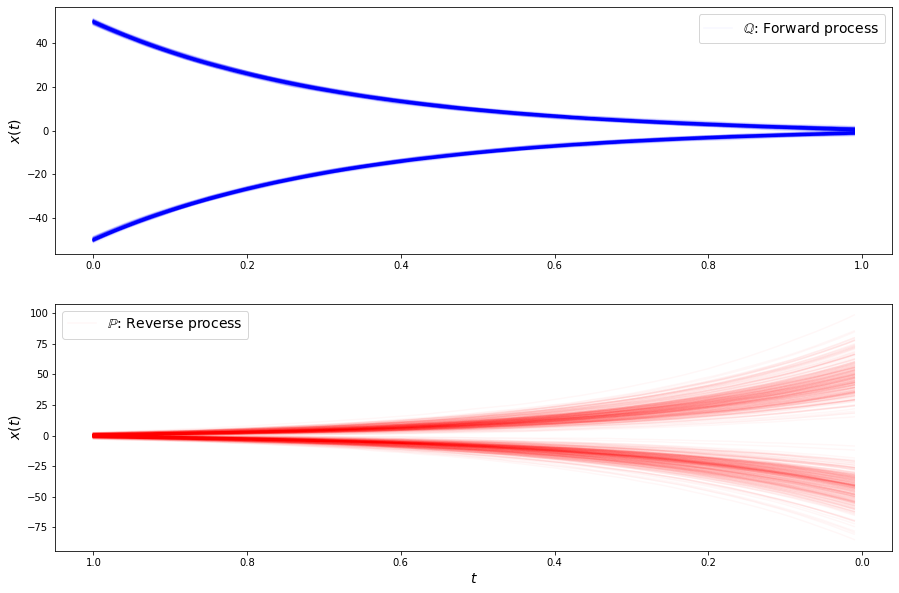

loss b 3.8086788654327393
loss b 3.8206944465637207
loss b 3.7079856395721436
loss b 3.7521095275878906
loss b 3.803008556365967
loss b 3.8115856647491455
loss b 3.776374101638794
loss b 3.8433420658111572
loss b 3.8474459648132324
loss b 3.7075839042663574
loss b 3.7899210453033447
loss b 3.716460943222046
loss b 3.7828733921051025
loss b 3.7970163822174072
loss b 3.7447454929351807
loss b 3.737704038619995
loss b 3.7281339168548584
loss b 3.705043077468872
loss b 3.7671754360198975
loss b 3.7268240451812744
loss b 3.8187644481658936
loss b 3.698054552078247
loss f 0.2951120138168335
loss f 0.31206080317497253
loss f 0.3274627923965454
loss f 0.31869930028915405
loss f 0.2745673656463623
loss f 0.29611077904701233
loss f 0.2627738118171692
loss f 0.2533433437347412
loss f 0.30087563395500183
loss f 0.283415824174881
loss f 0.2855309247970581
loss f 0.22003698348999023
loss f 0.2958758771419525
loss f 0.26056498289108276
loss f 0.3065028488636017
loss f 0.30180734395980835
loss f 0.300

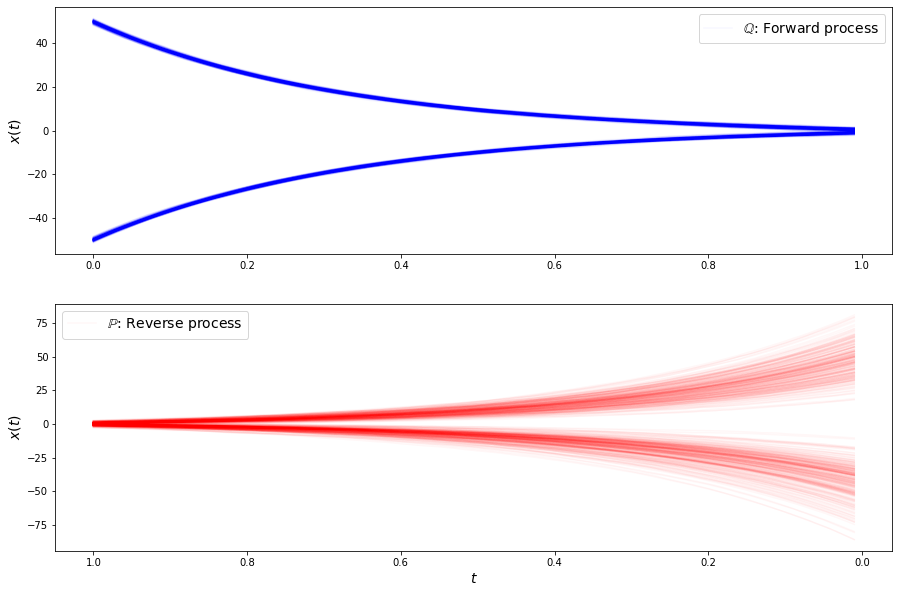

loss b 3.6886749267578125
loss b 3.6997017860412598
loss b 3.807373285293579
loss b 3.7094738483428955
loss b 3.8097150325775146
loss b 3.7512495517730713
loss b 3.72394061088562
loss b 3.743983030319214
loss b 3.7063846588134766
loss b 3.7489044666290283
loss b 3.726778745651245
loss b 3.7808210849761963
loss b 3.760091543197632
loss b 3.7226099967956543
loss b 3.7275660037994385
loss b 3.642988443374634
loss b 3.7299604415893555
loss b 3.7807273864746094
loss b 3.669477701187134
loss b 3.641294479370117
loss b 3.702052354812622
loss b 3.7170002460479736
loss f 0.2522847354412079
loss f 0.23482900857925415
loss f 0.2537837326526642
loss f 0.25144198536872864
loss f 0.21703746914863586
loss f 0.23005527257919312
loss f 0.2543971836566925
loss f 0.24174292385578156
loss f 0.2552628517150879
loss f 0.24331966042518616
loss f 0.2161398082971573
loss f 0.21280093491077423
loss f 0.22537662088871002
loss f 0.20428740978240967
loss f 0.24020031094551086
loss f 0.22255638241767883
loss f 0.24

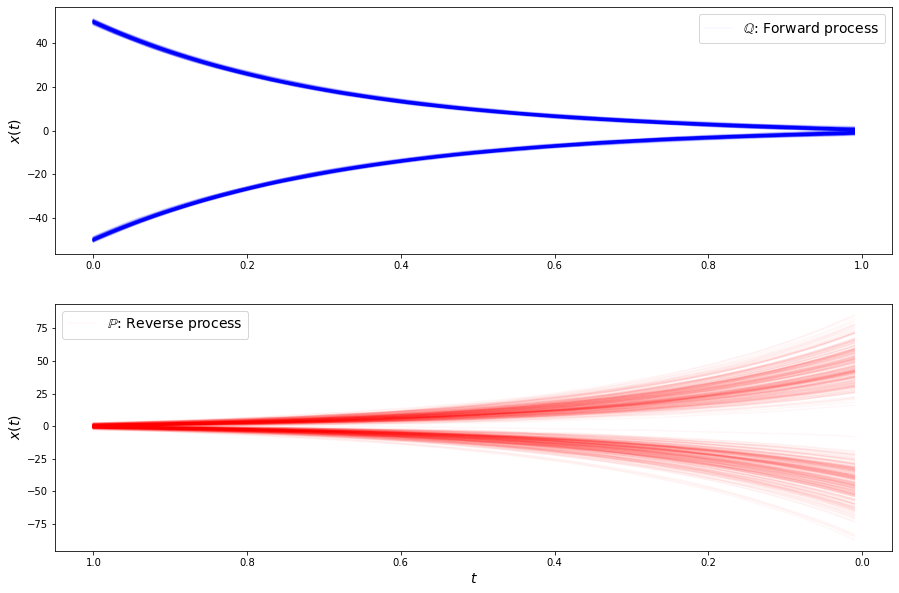

loss b 3.688318967819214
loss b 3.792405605316162
loss b 3.68096661567688
loss b 3.710414171218872
loss b 3.6944379806518555
loss b 3.67889666557312
loss b 3.675825595855713
loss b 3.6494438648223877
loss b 3.709916591644287
loss b 3.7280466556549072
loss b 3.698040246963501
loss b 3.7000105381011963
loss b 3.7305030822753906
loss b 3.695600748062134
loss b 3.695950984954834
loss b 3.7908010482788086
loss b 3.7078354358673096
loss b 3.7428476810455322
loss b 3.657285451889038
loss b 3.660916328430176
loss b 3.754779100418091
loss b 3.675286054611206
loss f 0.21524959802627563
loss f 0.21747112274169922
loss f 0.1730138510465622
loss f 0.2181963473558426
loss f 0.18555869162082672
loss f 0.1836218684911728
loss f 0.16981200873851776
loss f 0.20208443701267242
loss f 0.22353753447532654
loss f 0.1755707561969757
loss f 0.19586984813213348
loss f 0.15658479928970337
loss f 0.15683896839618683
loss f 0.19714653491973877
loss f 0.18356937170028687
loss f 0.17311184108257294
loss f 0.1858985

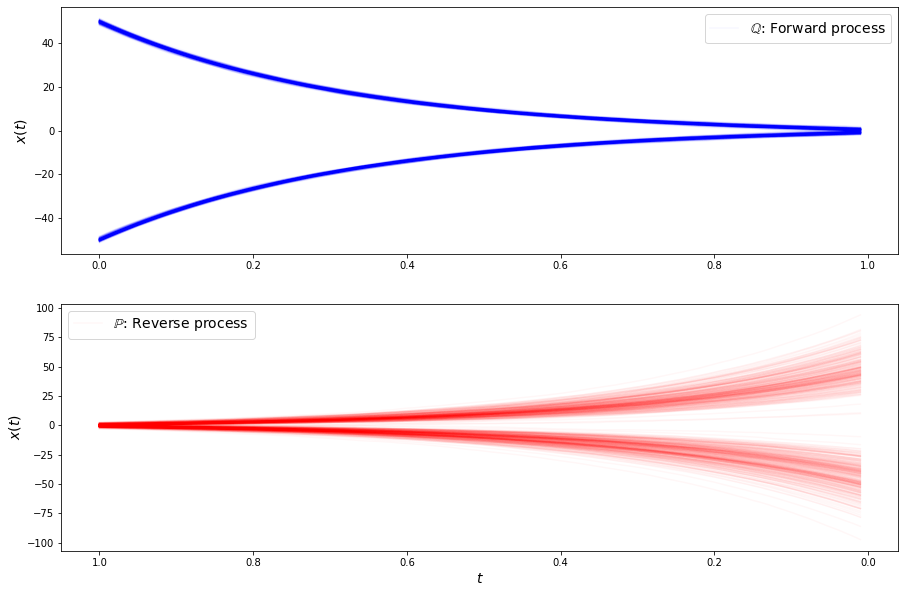

loss b 3.701582193374634
loss b 3.765738010406494
loss b 3.6976914405822754
loss b 3.68437123298645
loss b 3.70847749710083
loss b 3.6784234046936035
loss b 3.6999056339263916
loss b 3.7782015800476074
loss b 3.6582677364349365
loss b 3.7281854152679443
loss b 3.6393520832061768
loss b 3.727933406829834
loss b 3.6638505458831787
loss b 3.6551339626312256
loss b 3.691760301589966
loss b 3.6860382556915283
loss b 3.7021803855895996
loss b 3.705799102783203
loss b 3.7067534923553467
loss b 3.6892426013946533
loss b 3.7003026008605957
loss b 3.692401885986328
loss f 0.16033834218978882
loss f 0.16272921860218048
loss f 0.15805475413799286
loss f 0.18560482561588287
loss f 0.158294215798378
loss f 0.16492436826229095
loss f 0.17131495475769043
loss f 0.128443643450737
loss f 0.14476574957370758
loss f 0.14667032659053802
loss f 0.152119979262352
loss f 0.14938707649707794
loss f 0.16665081679821014
loss f 0.14424844086170197
loss f 0.15480782091617584
loss f 0.1546751856803894
loss f 0.1473

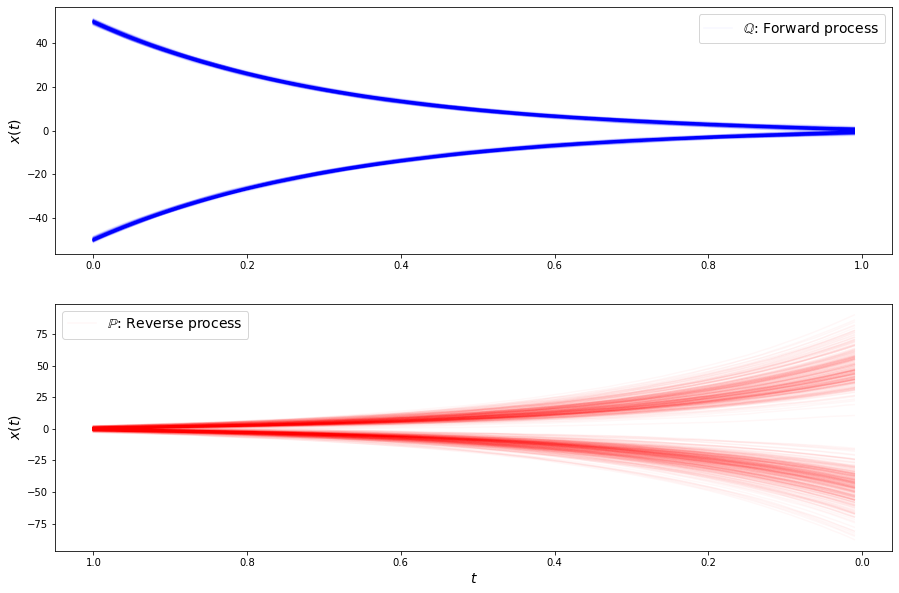

loss b 3.6538949012756348
loss b 3.6334714889526367
loss b 3.706141233444214
loss b 3.623450994491577
loss b 3.618018865585327
loss b 3.6374735832214355
loss b 3.6763265132904053
loss b 3.6856579780578613
loss b 3.747389554977417
loss b 3.603515386581421
loss b 3.6997313499450684
loss b 3.6401238441467285
loss b 3.6699485778808594
loss b 3.643963098526001
loss b 3.726292848587036
loss b 3.6701014041900635
loss b 3.6815173625946045
loss b 3.661057949066162
loss b 3.725581407546997
loss b 3.6088759899139404
loss b 3.6775898933410645
loss b 3.7275280952453613
loss f 0.1570539027452469
loss f 0.133026584982872
loss f 0.11992234736680984
loss f 0.13185402750968933
loss f 0.11125290393829346
loss f 0.135111466050148
loss f 0.12780189514160156
loss f 0.13948659598827362
loss f 0.10880417376756668
loss f 0.10463975369930267
loss f 0.13891078531742096
loss f 0.09821220487356186
loss f 0.1305365413427353
loss f 0.11907763034105301
loss f 0.11923611164093018
loss f 0.10774383693933487
loss f 0.11

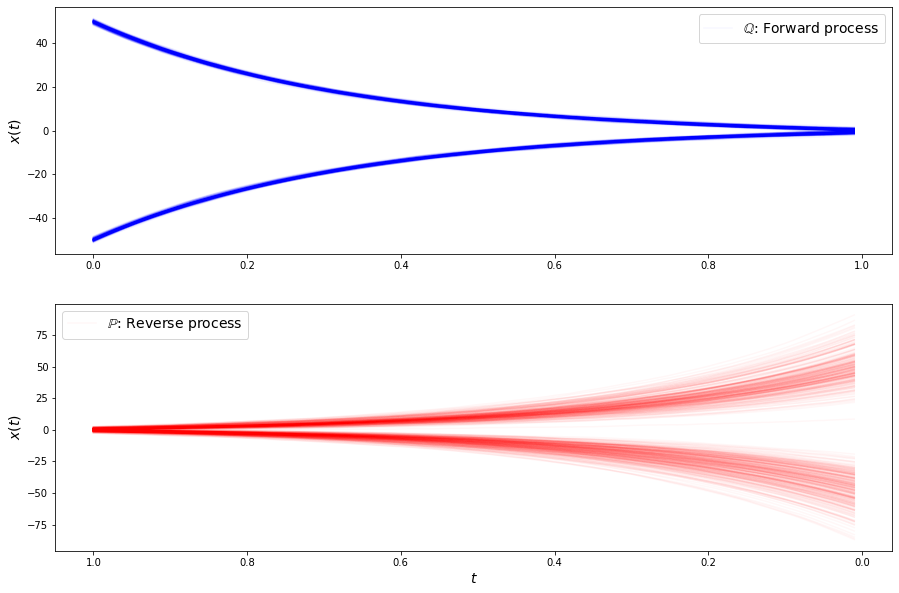

loss b 3.656473159790039
loss b 3.7156565189361572
loss b 3.7097723484039307
loss b 3.688153028488159
loss b 3.5907225608825684
loss b 3.7904720306396484
loss b 3.719373941421509
loss b 3.663177490234375
loss b 3.7405970096588135
loss b 3.6652660369873047
loss b 3.646866798400879
loss b 3.686237096786499
loss b 3.662872791290283
loss b 3.6746675968170166
loss b 3.6659340858459473
loss b 3.6745245456695557
loss b 3.6397674083709717
loss b 3.6385715007781982
loss b 3.6625142097473145
loss b 3.64961838722229
loss b 3.652167797088623
loss b 3.67109751701355
loss f 0.10151012241840363
loss f 0.09659899771213531
loss f 0.11242219060659409
loss f 0.09882883727550507
loss f 0.11673558503389359
loss f 0.09226831048727036
loss f 0.10480102896690369
loss f 0.08295231312513351
loss f 0.0885016918182373
loss f 0.0835815891623497
loss f 0.07141756266355515
loss f 0.08012112230062485
loss f 0.10563778132200241
loss f 0.08748266100883484
loss f 0.08507539331912994
loss f 0.07221951335668564
loss f 0.0

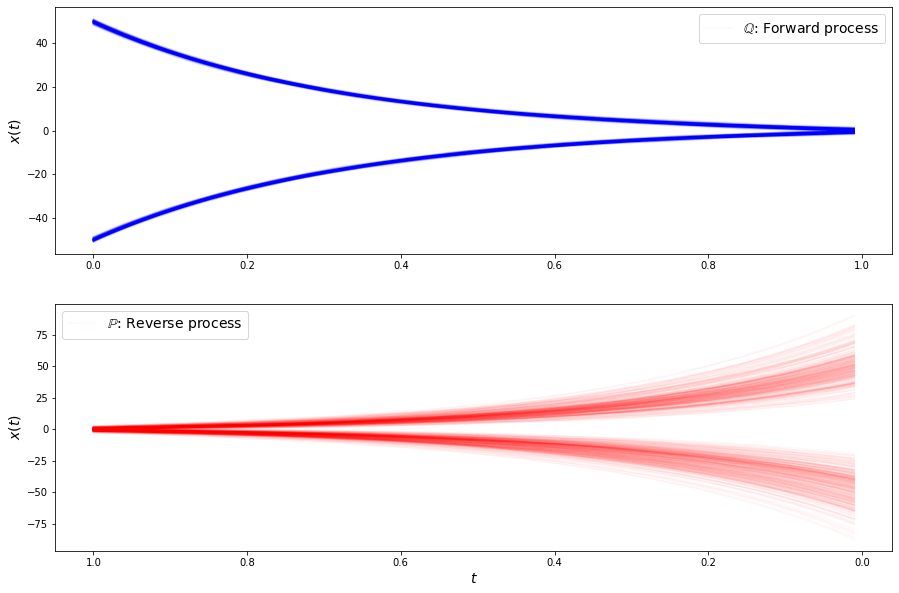

loss b 3.752598524093628
loss b 3.658609390258789
loss b 3.607032537460327
loss b 3.7069408893585205
loss b 3.611294984817505
loss b 3.655189037322998
loss b 3.6734695434570312
loss b 3.681867837905884
loss b 3.605130910873413
loss b 3.576972007751465
loss b 3.5950191020965576
loss b 3.642784595489502
loss b 3.6391584873199463
loss b 3.6439590454101562
loss b 3.6111855506896973
loss b 3.712263345718384
loss b 3.686203956604004
loss b 3.686858892440796
loss b 3.6016969680786133
loss b 3.6460835933685303
loss b 3.656766891479492
loss b 3.6103854179382324
loss f 0.06308653950691223
loss f 0.0960218757390976
loss f 0.0696159079670906
loss f 0.10196301341056824
loss f 0.09308509528636932
loss f 0.07645520567893982
loss f 0.05885544791817665
loss f 0.0949268713593483
loss f 0.06359251588582993
loss f 0.06293941289186478
loss f 0.06368181854486465
loss f 0.059259578585624695
loss f 0.05733105540275574
loss f 0.08435217291116714
loss f 0.07587336003780365
loss f 0.05615340918302536
loss f 0.05

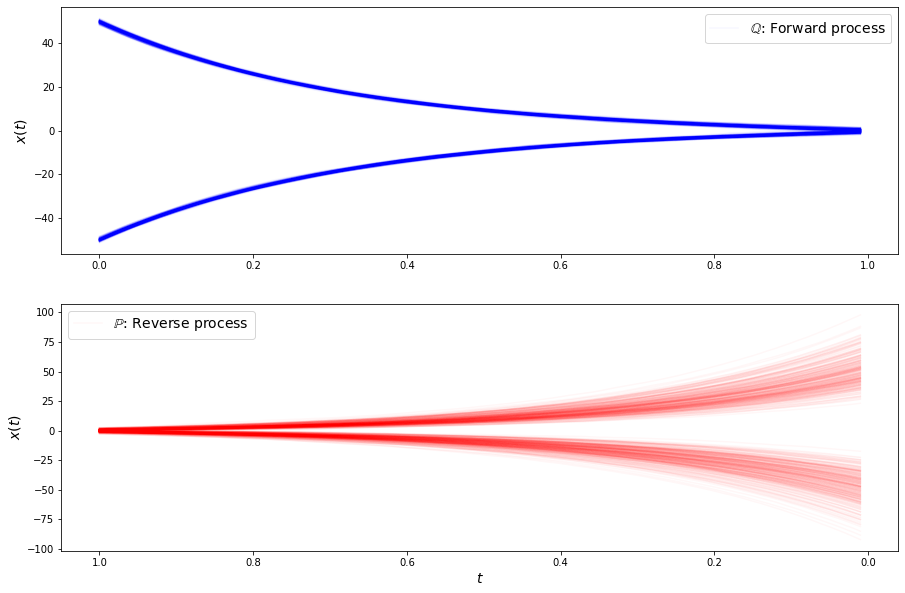

loss b 3.6626501083374023
loss b 3.6524012088775635
loss b 3.6909139156341553
loss b 3.6358466148376465
loss b 3.684776544570923
loss b 3.66195011138916
loss b 3.7198500633239746
loss b 3.687379837036133
loss b 3.631854772567749
loss b 3.6424036026000977
loss b 3.640672445297241
loss b 3.6991665363311768
loss b 3.643836259841919
loss b 3.7173142433166504
loss b 3.6683061122894287
loss b 3.6566998958587646
loss b 3.6535422801971436
loss b 3.732680082321167
loss b 3.6651225090026855
loss b 3.653517007827759
loss b 3.7056665420532227
loss b 3.6861379146575928
loss f 0.06031842529773712
loss f 0.04729178920388222
loss f 0.0513627827167511
loss f 0.04924200847744942
loss f 0.051278773695230484
loss f 0.02664949931204319
loss f 0.057858970016241074
loss f 0.04131530597805977
loss f 0.04654192924499512
loss f 0.0354539230465889
loss f 0.07483839243650436
loss f 0.035129401832818985
loss f 0.0605774000287056
loss f 0.03318774700164795
loss f 0.02720671519637108
loss f 0.05873023718595505
loss 

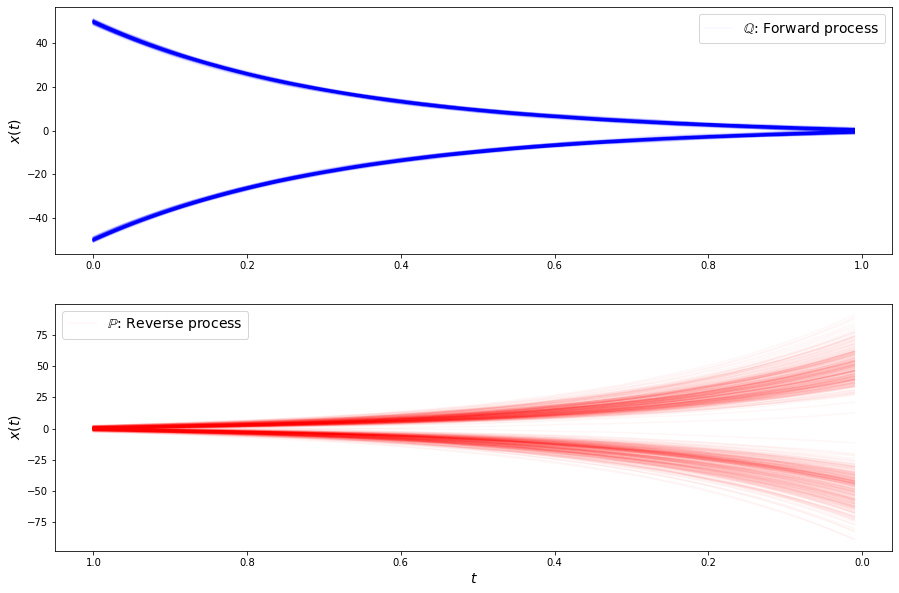

loss b 3.631877899169922
loss b 3.6350839138031006
loss b 3.7106103897094727
loss b 3.650062084197998
loss b 3.6714766025543213
loss b 3.65089750289917
loss b 3.679063558578491
loss b 3.6834051609039307
loss b 3.7566730976104736
loss b 3.6556169986724854
loss b 3.711784601211548
loss b 3.734006881713867
loss b 3.684380054473877
loss b 3.6995723247528076
loss b 3.7182188034057617
loss b 3.744408369064331
loss b 3.725579023361206
loss b 3.7395846843719482
loss b 3.777496337890625
loss b 3.7387356758117676
loss b 3.810063362121582
loss b 3.729840040206909
loss f 0.08780305832624435
loss f 0.09984283149242401
loss f 0.08773023635149002
loss f 0.09055054187774658
loss f 0.0675184354186058
loss f 0.07906145602464676
loss f 0.04150823503732681
loss f 0.07200448215007782
loss f 0.0485089085996151
loss f 0.06462929397821426
loss f 0.06057194992899895
loss f 0.07345173507928848
loss f 0.057940371334552765
loss f 0.05825638771057129
loss f 0.0412038154900074
loss f 0.07996198534965515
loss f 0.04

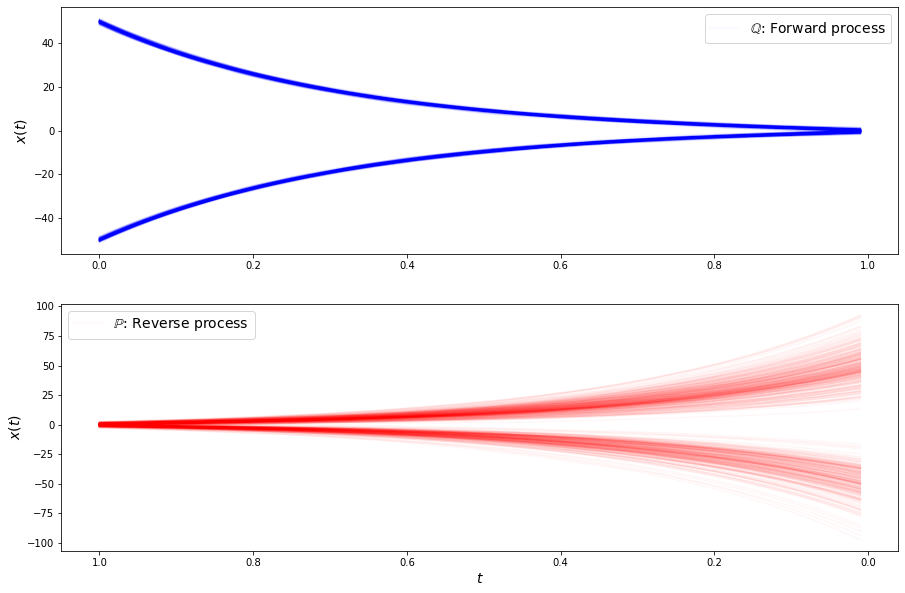

loss b 3.700839042663574
loss b 3.6980104446411133
loss b 3.7079575061798096
loss b 3.7064921855926514
loss b 3.6970319747924805
loss b 3.6792540550231934
loss b 3.657574415206909
loss b 3.715461015701294
loss b 3.627131223678589
loss b 3.7045226097106934
loss b 3.77191424369812
loss b 3.7028396129608154
loss b 3.7036750316619873
loss b 3.679694890975952
loss b 3.712712049484253
loss b 3.7209887504577637
loss b 3.7134499549865723
loss b 3.6775968074798584
loss b 3.5825729370117188
loss b 3.7128500938415527
loss b 3.6834845542907715
loss b 3.660789966583252
loss f 0.041180405765771866
loss f 0.0680520087480545
loss f 0.035279531031847
loss f 0.03597794845700264
loss f 0.046636905521154404
loss f 0.04207228124141693
loss f 0.03584349900484085
loss f 0.04131369665265083
loss f 0.044677481055259705
loss f 0.05215945094823837
loss f 0.028544411063194275
loss f 0.020951328799128532
loss f 0.06601511687040329
loss f 0.04691749066114426
loss f 0.04403894394636154
loss f 0.0427924208343029
loss

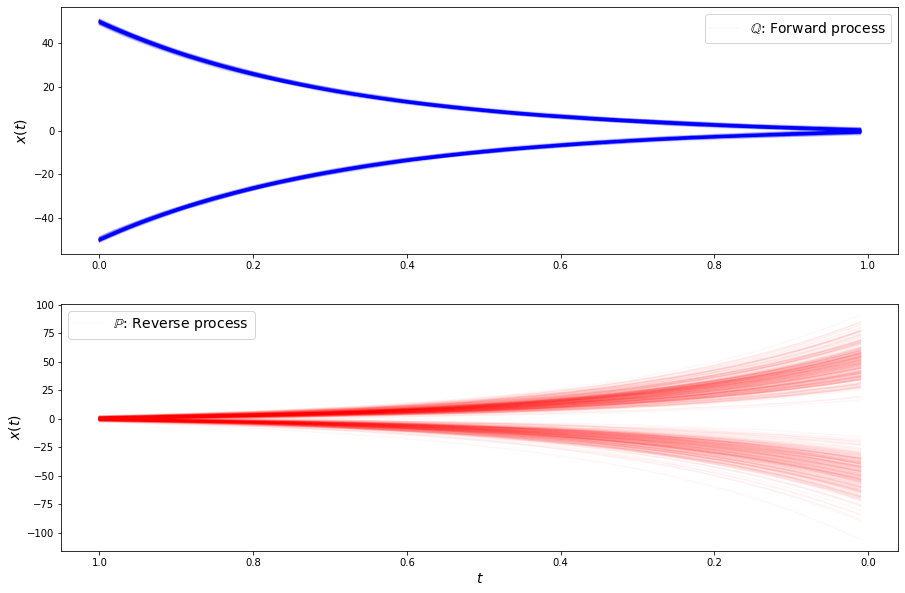

loss b 3.6594111919403076
loss b 3.7158586978912354
loss b 3.698007106781006
loss b 3.71683669090271
loss b 3.7395195960998535
loss b 3.6688663959503174
loss b 3.677969217300415
loss b 3.6294779777526855
loss b 3.6532442569732666
loss b 3.7032101154327393
loss b 3.7364234924316406
loss b 3.6745216846466064
loss b 3.6995959281921387
loss b 3.6091315746307373
loss b 3.636673927307129
loss b 3.71736741065979
loss b 3.7209954261779785
loss b 3.6804065704345703
loss b 3.7084624767303467
loss b 3.7240235805511475
loss b 3.701256513595581
loss b 3.637246608734131
loss f 0.04409198835492134
loss f 0.04752468690276146
loss f 0.050659265369176865
loss f 0.011618868447840214
loss f 0.03349566087126732
loss f 0.031640954315662384
loss f 0.04353754594922066
loss f 0.027468319982290268
loss f 0.03486024960875511
loss f 0.0395001545548439
loss f 0.0681539848446846
loss f 0.021744346246123314
loss f 0.054007671773433685
loss f 0.04348297789692879
loss f 0.024565620347857475
loss f 0.028701327741146088

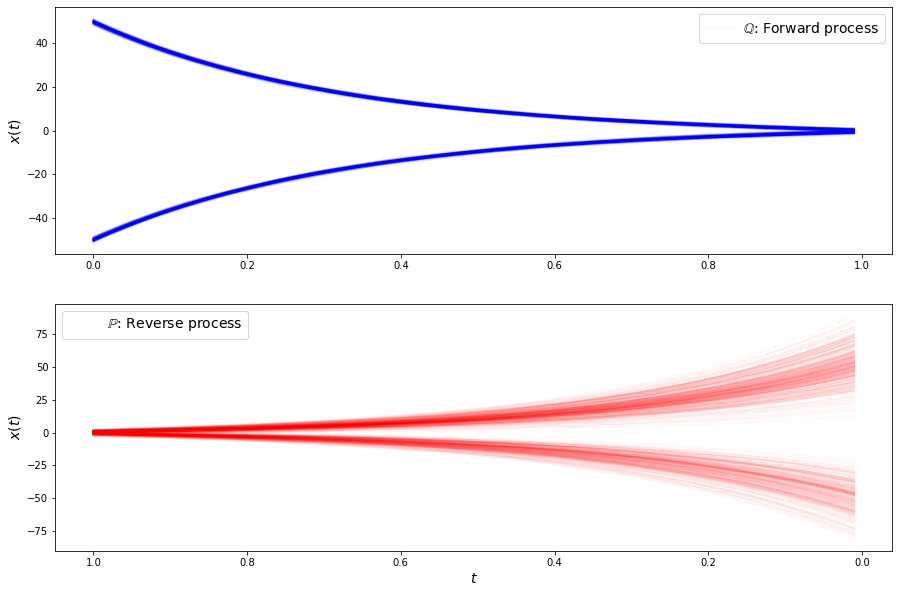

loss b 3.650270938873291
loss b 3.688560962677002
loss b 3.6631624698638916
loss b 3.698692560195923
loss b 3.6578962802886963
loss b 3.6955480575561523
loss b 3.686046600341797
loss b 3.7160286903381348
loss b 3.6647796630859375
loss b 3.6271870136260986
loss b 3.69062876701355
loss b 3.738349437713623
loss b 3.738342523574829
loss b 3.7077744007110596
loss b 3.6678617000579834
loss b 3.688663959503174
loss b 3.6518094539642334
loss b 3.6739845275878906
loss b 3.6633684635162354
loss b 3.6702933311462402
loss b 3.6294991970062256
loss b 3.7571005821228027
loss f 0.011999773792922497
loss f 0.019805017858743668
loss f 0.01910037361085415
loss f 0.04217471182346344
loss f 0.022933464497327805
loss f 0.01990962028503418
loss f 0.028845321387052536
loss f 0.012217290699481964
loss f 0.03039289265871048
loss f 0.04338696971535683
loss f 0.018557671457529068
loss f 0.027438456192612648
loss f 0.02371666580438614
loss f 0.014606844633817673
loss f 0.020424986258149147
loss f 0.00958319753408

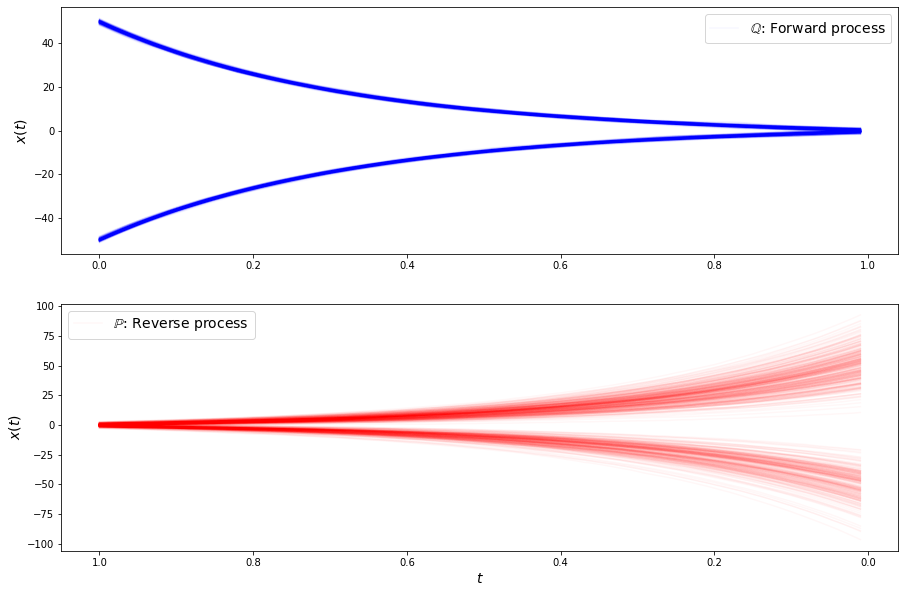

loss b 3.663431167602539
loss b 3.64046311378479
loss b 3.6680541038513184
loss b 3.687114953994751
loss b 3.738264799118042
loss b 3.632525682449341
loss b 3.6333329677581787
loss b 3.6647255420684814
loss b 3.719426155090332
loss b 3.725581645965576
loss b 3.7239744663238525
loss b 3.643760919570923
loss b 3.7044737339019775
loss b 3.732804298400879
loss b 3.7434275150299072
loss b 3.6894724369049072
loss b 3.643353223800659
loss b 3.694366931915283
loss b 3.7235047817230225
loss b 3.7325422763824463
loss b 3.720451593399048
loss b 3.6664907932281494
loss f 0.06401379406452179
loss f 0.02901620790362358
loss f 0.02840864099562168
loss f 0.03374621272087097
loss f 0.0290207639336586
loss f 0.02369435876607895
loss f 0.028770163655281067
loss f 0.024133991450071335
loss f -0.00025195899070240557
loss f 0.01669108122587204
loss f 0.02528732270002365
loss f 0.019762789830565453
loss f 0.03668101131916046
loss f 0.03277566283941269
loss f 0.01063698623329401
loss f 0.01783575303852558
los

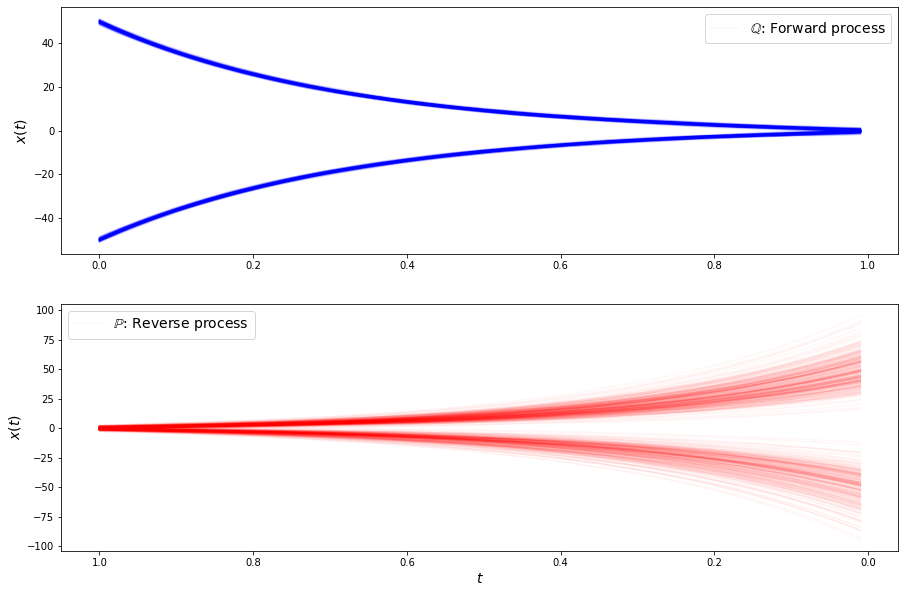

loss b 3.718674421310425
loss b 3.645761013031006
loss b 3.717402935028076
loss b 3.6769280433654785
loss b 3.6709182262420654
loss b 3.7191624641418457
loss b 3.718825101852417
loss b 3.6936299800872803
loss b 3.7112114429473877
loss b 3.7168045043945312
loss b 3.7871363162994385
loss b 3.707228899002075
loss b 3.7360222339630127
loss b 3.751574993133545
loss b 3.718508243560791
loss b 3.7469444274902344
loss b 3.7111496925354004
loss b 3.737192153930664
loss b 3.6827261447906494
loss b 3.687455415725708
loss b 3.6844170093536377
loss b 3.7081706523895264
loss f 0.05417715013027191
loss f 0.04050436615943909
loss f 0.0528605654835701
loss f 0.054155413061380386
loss f 0.042017266154289246
loss f 0.04523541033267975
loss f 0.03729095309972763
loss f 0.017947537824511528
loss f 0.0025775390677154064
loss f 0.027859840542078018
loss f 0.025706129148602486
loss f 0.006753473076969385
loss f 0.012477006763219833
loss f 0.018939640372991562
loss f 0.014149362221360207
loss f 0.0188453402370

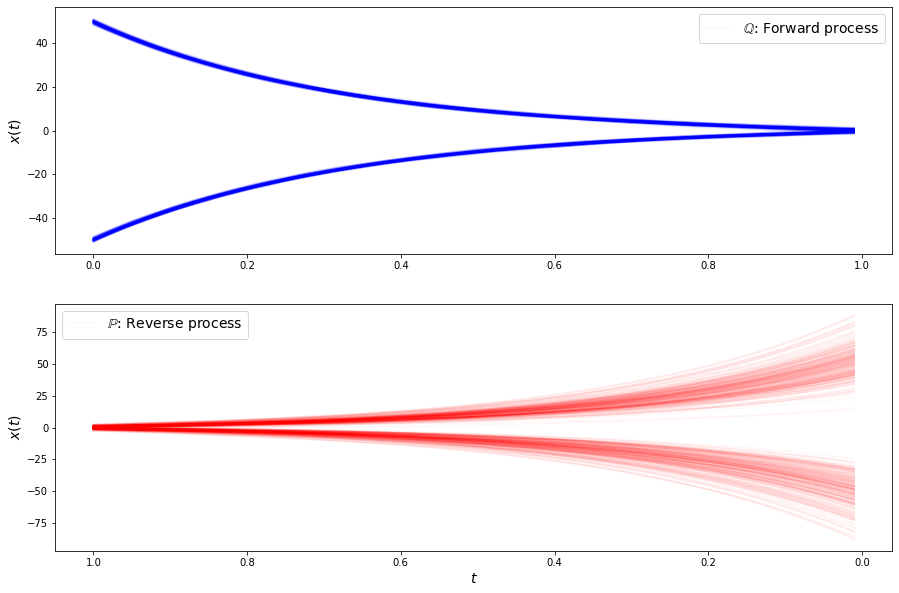

loss b 3.695765495300293
loss b 3.6348066329956055
loss b 3.721950054168701
loss b 3.744182586669922
loss b 3.7657387256622314
loss b 3.675384998321533
loss b 3.6963131427764893
loss b 3.7271785736083984
loss b 3.7009990215301514
loss b 3.7192585468292236
loss b 3.6379940509796143
loss b 3.7062795162200928
loss b 3.66416597366333
loss b 3.579118490219116
loss b 3.6686294078826904
loss b 3.6989147663116455
loss b 3.638356924057007
loss b 3.6781063079833984
loss b 3.739227294921875
loss b 3.6781253814697266
loss b 3.6622698307037354
loss b 3.7258100509643555
loss f -0.0010071230353787541
loss f 0.01013446506112814
loss f 0.0021191358100622892
loss f 0.008795792236924171
loss f 0.0011912700720131397
loss f -0.00242746458388865
loss f -0.0013689235784113407
loss f 0.005612432956695557
loss f -0.0033633464481681585
loss f -0.010985189117491245
loss f -0.016003606840968132
loss f -0.0003574384900275618
loss f -0.006700625643134117
loss f -0.01584172062575817
loss f -0.0018385503208264709
los

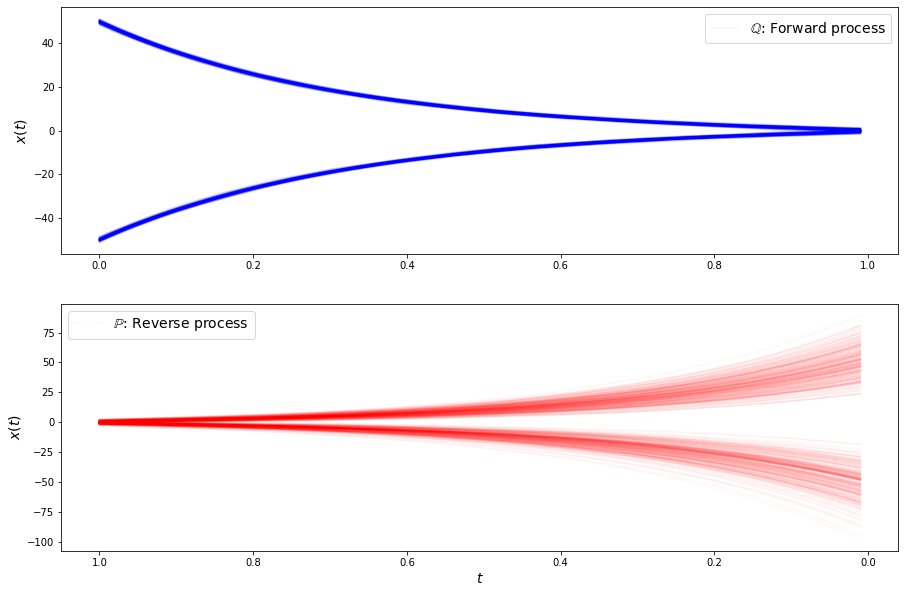

loss b 3.6891086101531982
loss b 3.623016595840454
loss b 3.713860273361206
loss b 3.6375679969787598
loss b 3.63869309425354
loss b 3.69779896736145
loss b 3.6126744747161865
loss b 3.6380956172943115
loss b 3.69537091255188
loss b 3.6071741580963135
loss b 3.7228946685791016
loss b 3.6866321563720703
loss b 3.6623549461364746
loss b 3.6744210720062256
loss b 3.6869773864746094
loss b 3.681597948074341
loss b 3.644260883331299
loss b 3.6645431518554688
loss b 3.6450390815734863
loss b 3.7200870513916016
loss b 3.619685173034668
loss b 3.603238105773926
loss f 0.017066193744540215
loss f 0.003607254708185792
loss f -0.004313081502914429
loss f -0.013917299918830395
loss f 0.001782777369953692
loss f 0.00260035484097898
loss f 0.007275065407156944
loss f -0.00890704058110714
loss f -0.0071260640397667885
loss f -0.0033805116545408964
loss f -0.0059015448205173016
loss f -0.011732783168554306
loss f -0.01200171373784542
loss f 0.0014317705063149333
loss f -0.005056824069470167
loss f -0.

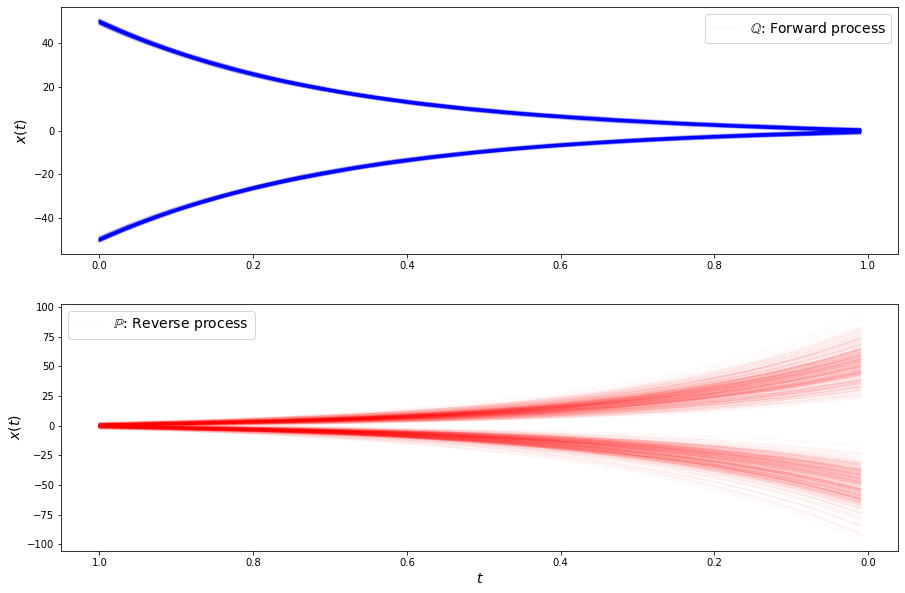

loss b 3.690694808959961
loss b 3.685230016708374
loss b 3.674130439758301
loss b 3.6212735176086426
loss b 3.6451025009155273
loss b 3.720803737640381
loss b 3.7036550045013428
loss b 3.6904280185699463
loss b 3.655409336090088
loss b 3.5999324321746826
loss b 3.694812536239624
loss b 3.6403989791870117
loss b 3.7226080894470215
loss b 3.684293508529663
loss b 3.656789779663086
loss b 3.677849769592285
loss b 3.6081721782684326
loss b 3.6538245677948
loss b 3.693154811859131
loss b 3.6731600761413574
loss b 3.606323003768921
loss b 3.6589407920837402
loss f -0.0019418259616941214
loss f -0.012150706723332405
loss f -0.013290192000567913
loss f -0.020827429369091988
loss f -0.026961300522089005
loss f -0.017286276444792747
loss f -0.017596615478396416
loss f -0.015205716714262962
loss f -0.013169979676604271
loss f -0.002247377298772335
loss f -0.007337199989706278
loss f -0.010588225908577442
loss f -0.005253525450825691
loss f -0.020110713317990303
loss f -0.01937762461602688
loss f 

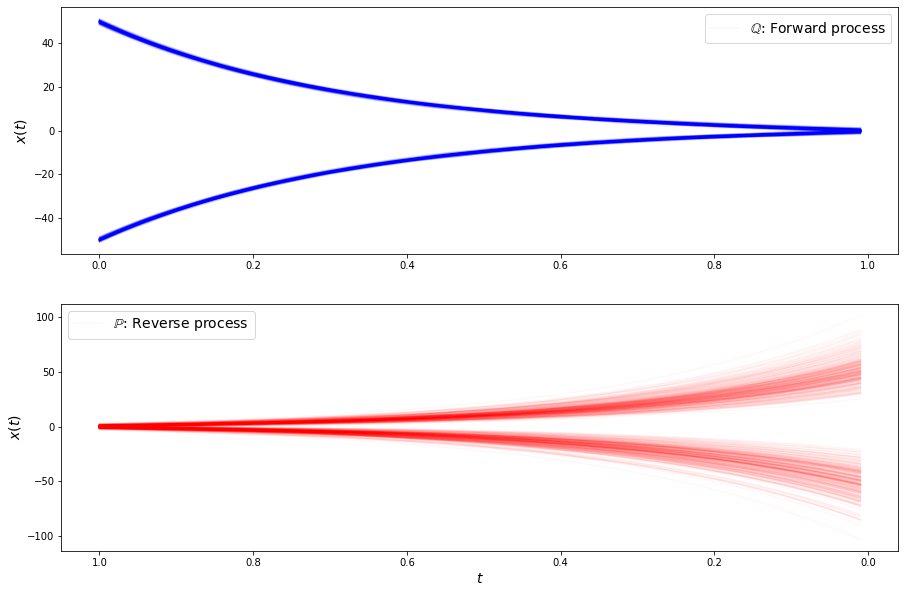

loss b 3.7022244930267334
loss b 3.6247315406799316
loss b 3.6167690753936768
loss b 3.6668601036071777
loss b 3.6936633586883545
loss b 3.646246910095215
loss b 3.6600213050842285
loss b 3.6697020530700684
loss b 3.6090316772460938
loss b 3.6316299438476562
loss b 3.6981728076934814
loss b 3.691084384918213
loss b 3.7518200874328613
loss b 3.695387840270996
loss b 4.763145446777344
loss b 5.6379828453063965
loss b 5.119647979736328
loss b 4.375856399536133
loss b 4.020780086517334
loss b 4.454641819000244
loss b 4.717998027801514
loss b 4.384146213531494
loss f 0.6508962512016296
loss f 0.5740749835968018
loss f 0.5070854425430298
loss f 0.4298715591430664
loss f 0.3851853609085083
loss f 0.3142847418785095
loss f 0.2862665057182312
loss f 0.23775894939899445
loss f 0.19777324795722961
loss f 0.19684025645256042
loss f 0.17457075417041779
loss f 0.15402692556381226
loss f 0.15118639171123505
loss f 0.15780916810035706
loss f 0.15058214962482452
loss f 0.15015952289104462
loss f 0.1613

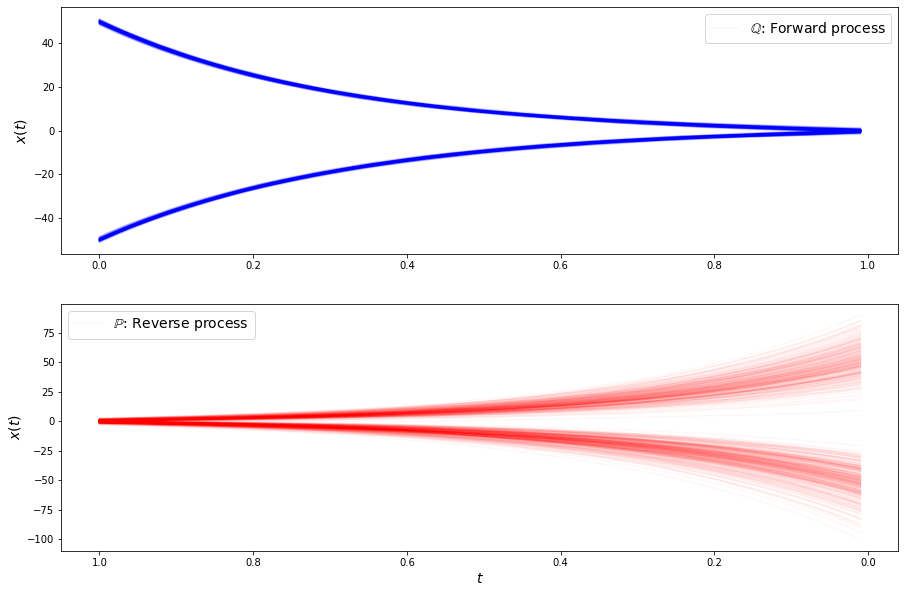

loss b 4.616273880004883
loss b 4.301498889923096
loss b 3.949188470840454
loss b 4.215237140655518
loss b 4.292744159698486
loss b 4.208647727966309
loss b 4.002655506134033
loss b 4.118317604064941
loss b 4.239813804626465
loss b 4.1676506996154785
loss b 4.076778888702393
loss b 4.081862449645996
loss b 4.183398723602295
loss b 4.149407386779785
loss b 4.079333305358887
loss b 4.089077949523926
loss b 4.111355781555176
loss b 4.124659061431885
loss b 4.1365647315979
loss b 4.099298000335693
loss b 4.0511040687561035
loss b 4.1217360496521
loss f 0.2827383577823639
loss f 0.2597646117210388
loss f 0.2456454336643219
loss f 0.21899700164794922
loss f 0.19915172457695007
loss f 0.19563080370426178
loss f 0.17669777572155
loss f 0.14877694845199585
loss f 0.158094584941864
loss f 0.12009420990943909
loss f 0.1474461853504181
loss f 0.15687021613121033
loss f 0.1421147882938385
loss f 0.13864091038703918
loss f 0.09432470053434372
loss f 0.08756712824106216
loss f 0.08811382204294205
los

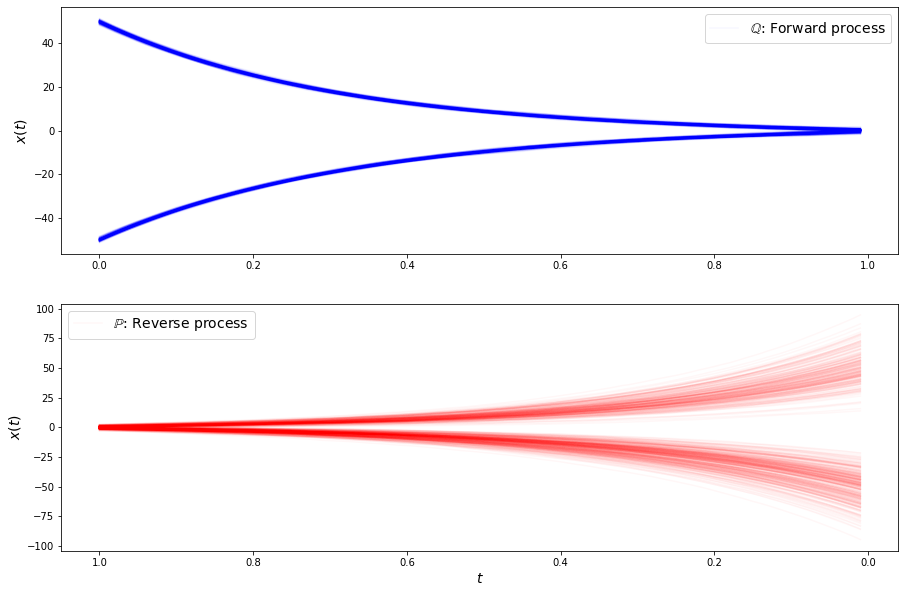

loss b 3.801358461380005
loss b 3.873358964920044
loss b 3.8440959453582764
loss b 3.8072774410247803
loss b 3.7967660427093506
loss b 3.85805344581604
loss b 3.754302740097046
loss b 3.7817320823669434
loss b 3.788013458251953
loss b 3.8611414432525635
loss b 3.733368158340454
loss b 3.7757866382598877
loss b 3.7958831787109375
loss b 3.731745958328247
loss b 3.8228538036346436
loss b 3.810185432434082
loss b 3.6959478855133057
loss b 3.7485876083374023
loss b 3.7827727794647217
loss b 3.7974061965942383
loss b 3.7277328968048096
loss b 3.739309072494507
loss f 0.0438973605632782
loss f 0.030486270785331726
loss f 0.03546015918254852
loss f 0.03738822042942047
loss f 0.010344691574573517
loss f 0.01346766110509634
loss f 0.0025856606662273407
loss f 0.020585965365171432
loss f 0.007952495478093624
loss f 0.011910305358469486
loss f 0.028092173859477043
loss f 0.034110311418771744
loss f 0.02033044956624508
loss f 0.01754871755838394
loss f 0.009253396652638912
loss f 0.011892183683812

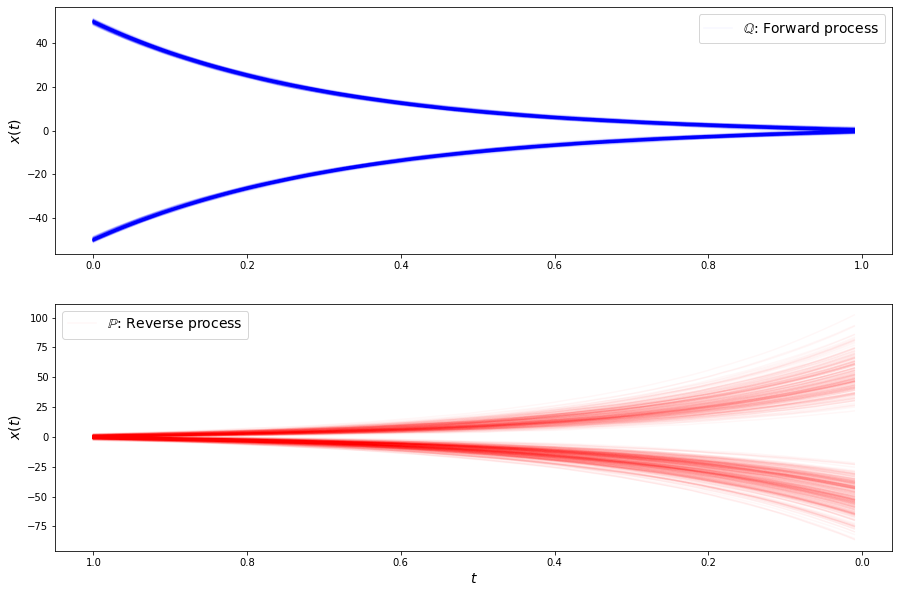

loss b 3.7915360927581787
loss b 3.7009239196777344
loss b 3.7306015491485596
loss b 3.7630553245544434
loss b 3.7133865356445312
loss b 3.7163426876068115
loss b 3.7091546058654785
loss b 3.722212314605713
loss b 3.682945966720581
loss b 3.758180618286133
loss b 3.7502965927124023
loss b 3.7306082248687744
loss b 3.7353806495666504
loss b 3.7543320655822754
loss b 3.69736909866333
loss b 3.7223498821258545
loss b 3.741302013397217
loss b 3.7281904220581055
loss b 3.743340015411377
loss b 3.70701265335083
loss b 3.729640245437622
loss b 3.743443012237549
loss f 0.022052789106965065
loss f 0.012269437313079834
loss f -0.014099273830652237
loss f 0.022127488628029823
loss f 0.011585569940507412
loss f 0.025938108563423157
loss f 0.007695906329900026
loss f 0.010902810841798782
loss f 0.01596863567829132
loss f 0.0068051074631512165
loss f -0.00714595802128315
loss f 0.013184341602027416
loss f 0.005477991420775652
loss f 0.00285062356851995
loss f 0.00953071191906929
loss f 0.00518671981

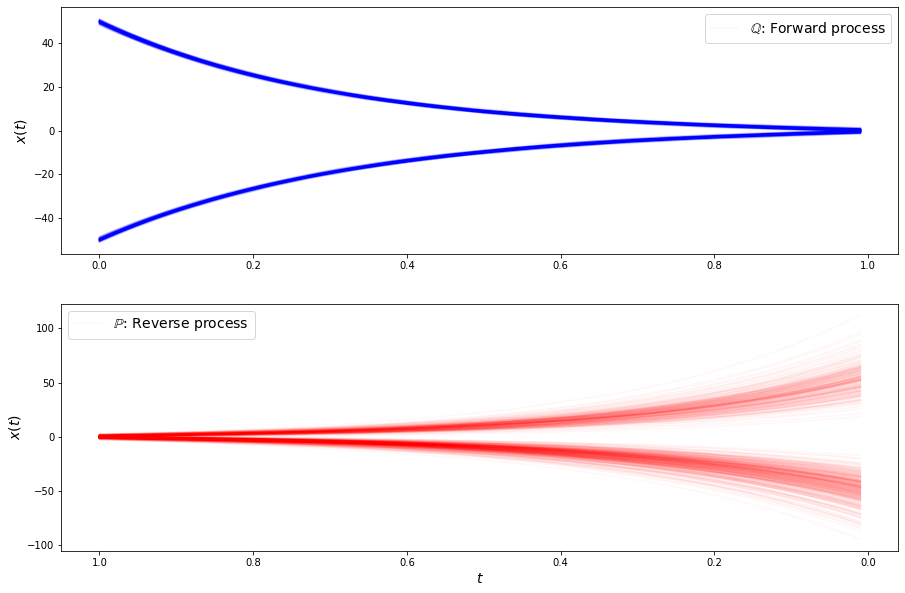

loss b 3.8761045932769775
loss b 3.8686232566833496
loss b 3.7248263359069824
loss b 3.7880239486694336
loss b 3.7502167224884033
loss b 3.8159093856811523
loss b 3.79524827003479
loss b 3.7577126026153564
loss b 3.7351245880126953
loss b 3.770472526550293
loss b 3.836052179336548
loss b 3.760206699371338
loss b 3.7921855449676514
loss b 3.709764003753662
loss b 3.6708035469055176
loss b 3.7428340911865234
loss b 3.659722089767456
loss b 3.715543746948242
loss b 3.7369494438171387
loss b 3.735534906387329
loss b 3.743021011352539
loss b 3.743765354156494
loss f 0.01485568005591631
loss f 0.022180022671818733
loss f 0.03664620965719223
loss f 0.008745971135795116
loss f 0.02857227995991707
loss f 0.016250720247626305
loss f 0.013032508082687855
loss f 0.0063623045571148396
loss f 0.008518019691109657
loss f 0.01855025440454483
loss f 0.003307261737063527
loss f 0.02427786961197853
loss f 0.02079269103705883
loss f 0.016738608479499817
loss f 0.015745624899864197
loss f 0.011328408494591

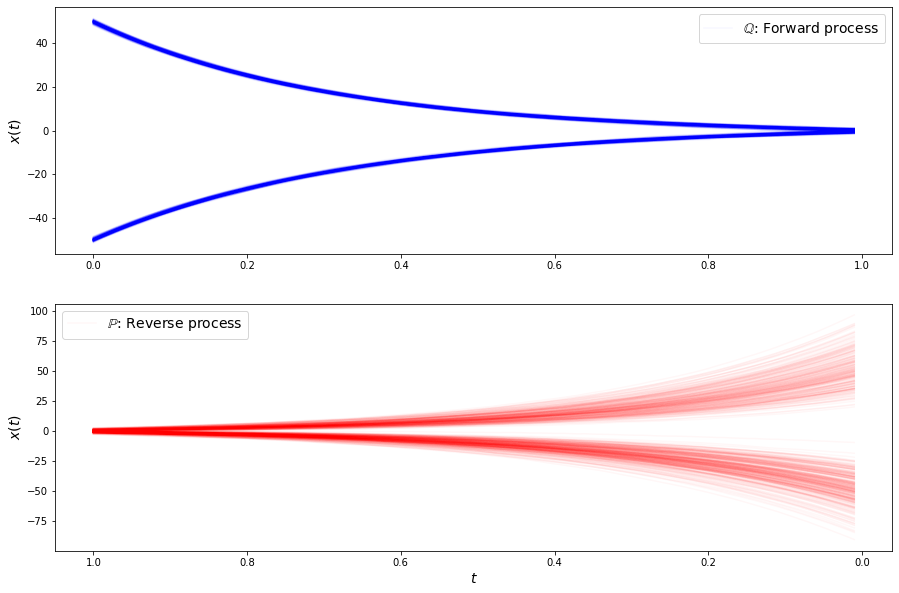

loss b 3.637892961502075
loss b 3.717912197113037
loss b 3.7545576095581055
loss b 3.7211484909057617
loss b 3.731734037399292
loss b 3.694230556488037
loss b 3.810389995574951
loss b 3.7425930500030518
loss b 3.7163031101226807
loss b 3.6666181087493896
loss b 3.71122407913208
loss b 3.7646310329437256
loss b 3.681185483932495
loss b 3.683269500732422
loss b 3.773409605026245
loss b 3.699856996536255
loss b 3.7905189990997314
loss b 3.6696224212646484
loss b 3.706990957260132
loss b 3.809105396270752
loss b 3.7486584186553955
loss b 3.721379518508911
loss f 0.030743097886443138
loss f 0.00811787974089384
loss f 0.027816394343972206
loss f 0.007761164102703333
loss f -0.0038959176745265722
loss f 0.030658988282084465
loss f 0.0031825373880565166
loss f 0.00946209579706192
loss f 0.00035678467247635126
loss f -0.0089575769379735
loss f 0.019946018233895302
loss f 0.008588085882365704
loss f 0.01173319946974516
loss f 0.018479421734809875
loss f 0.01532750017940998
loss f 0.0051458827219

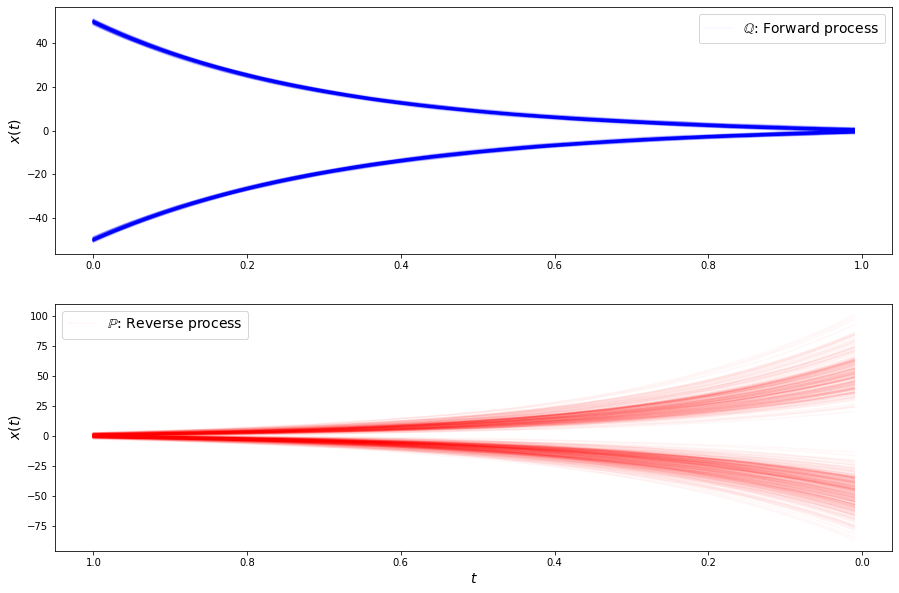

loss b 3.648505926132202
loss b 3.7360284328460693
loss b 3.783808708190918
loss b 3.7379064559936523
loss b 3.68459153175354
loss b 3.7009437084198
loss b 3.731903314590454
loss b 3.7772860527038574
loss b 3.6491470336914062
loss b 3.7307050228118896
loss b 3.712562084197998
loss b 3.726583480834961
loss b 3.7395379543304443
loss b 3.6443328857421875
loss b 3.727658748626709
loss b 3.6765196323394775
loss b 3.7474896907806396
loss b 3.7242064476013184
loss b 3.696643114089966
loss b 3.6426820755004883
loss b 3.673044443130493
loss b 3.6873860359191895
loss f 0.004143870901316404
loss f -0.017294183373451233
loss f 0.009034212678670883
loss f 0.0006065053748898208
loss f 0.005852093920111656
loss f 0.01085539348423481
loss f 0.016022708266973495
loss f -0.0069290646351873875
loss f 0.01535572949796915
loss f 0.0037792690563946962
loss f -0.0013972206506878138
loss f 0.007424265146255493
loss f -0.010249902494251728
loss f 0.003083985298871994
loss f 0.0012070060474798083
loss f -0.0056

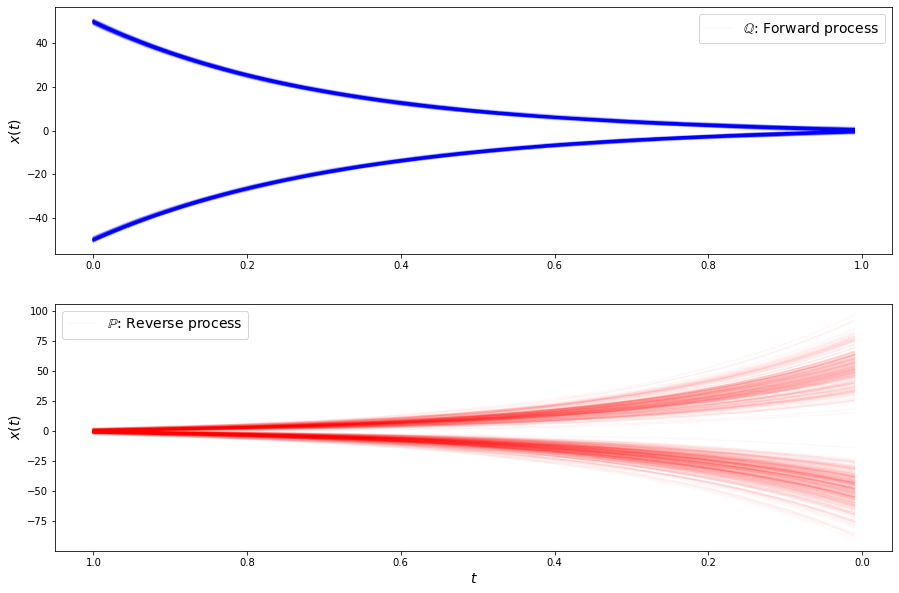

loss b 3.714384078979492
loss b 3.637159585952759
loss b 3.795366048812866
loss b 3.7730844020843506
loss b 3.7299675941467285
loss b 3.699601411819458
loss b 3.7832963466644287
loss b 3.7367780208587646
loss b 3.6755099296569824
loss b 3.66802716255188
loss b 3.7255282402038574
loss b 3.7556190490722656
loss b 3.7308504581451416
loss b 3.715643882751465
loss b 3.768343448638916
loss b 3.6741950511932373
loss b 3.69423770904541
loss b 3.7514750957489014
loss b 3.7061800956726074
loss b 3.9497175216674805
loss b 4.3584818840026855
loss b 4.247100830078125
loss f 0.2902351915836334
loss f 0.16032400727272034
loss f 0.10041428357362747
loss f 0.03757554292678833
loss f 0.064917653799057
loss f 0.045050088316202164
loss f 0.06663024425506592
loss f 0.07579842954874039
loss f 0.07571769505739212
loss f 0.09802469611167908
loss f 0.0730331689119339
loss f 0.09376578778028488
loss f 0.08142048865556717
loss f 0.09776268899440765
loss f 0.08276211470365524
loss f 0.09256504476070404
loss f 0.0

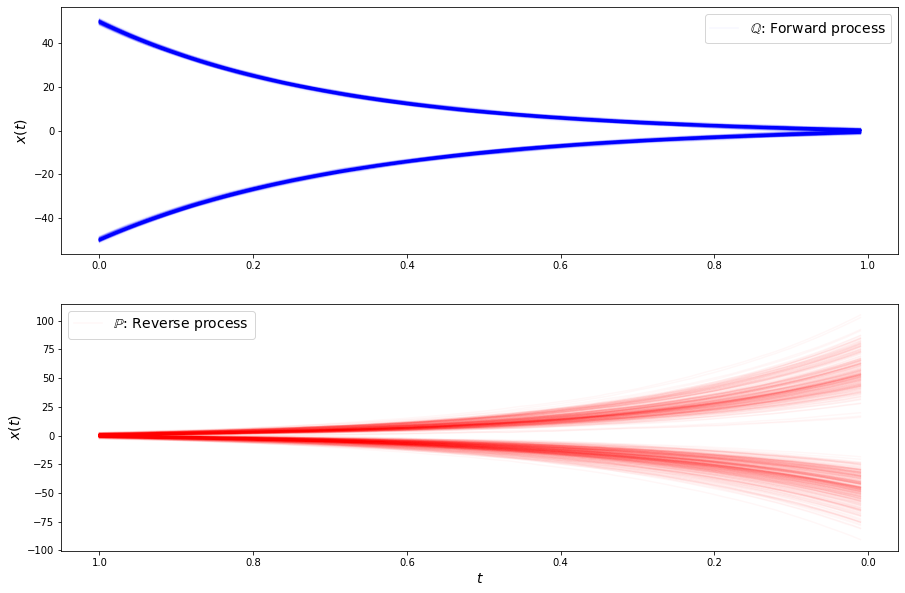

loss b 3.910217523574829
loss b 3.908686399459839
loss b 3.8687353134155273
loss b 3.845611810684204
loss b 3.872467517852783
loss b 3.8664538860321045
loss b 3.9131414890289307
loss b 3.8970963954925537
loss b 3.943918466567993
loss b 3.9112205505371094
loss b 3.980889081954956
loss b 3.8483150005340576
loss b 3.9639716148376465
loss b 4.510519027709961
loss b 5.161169528961182
loss b 5.1440324783325195
loss b 4.935563087463379
loss b 4.805531024932861
loss b 4.682376861572266
loss b 4.632442951202393
loss b 4.392075538635254
loss b 4.568345546722412
loss f 0.6218929886817932
loss f 0.5719695091247559
loss f 0.4685477018356323
loss f 0.3818776309490204
loss f 0.32772013545036316
loss f 0.28730499744415283
loss f 0.2786532938480377
loss f 0.301986426115036
loss f 0.2824287712574005
loss f 0.2670833170413971
loss f 0.2638363242149353
loss f 0.26862144470214844
loss f 0.2449634075164795
loss f 0.21640507876873016
loss f 0.20178267359733582
loss f 0.18005050718784332
loss f 0.157358154654

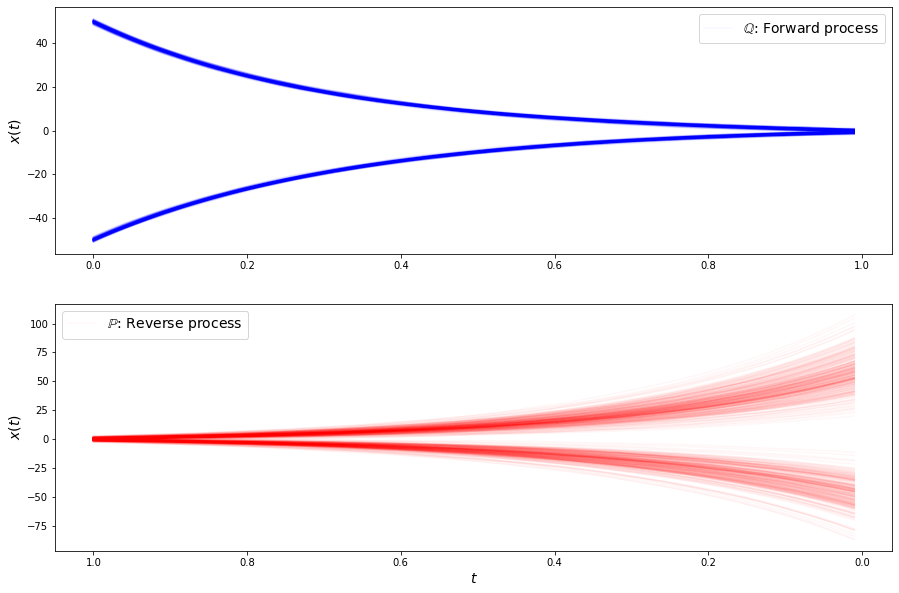

loss b 5.106183052062988
loss b 4.844616889953613
loss b 4.249138832092285
loss b 4.23845911026001
loss b 4.517889022827148
loss b 4.504845142364502
loss b 4.4139790534973145
loss b 4.160486221313477
loss b 4.279500961303711
loss b 4.262250900268555
loss b 4.151237487792969
loss b 4.081801891326904
loss b 4.026179790496826
loss b 4.221510887145996
loss b 4.322640419006348
loss b 4.144986629486084
loss b 4.136531829833984
loss b 4.066849231719971
loss b 4.188523292541504
loss b 4.174854278564453
loss b 4.071905612945557
loss b 4.122135639190674
loss f 0.26097944378852844
loss f 0.23221176862716675
loss f 0.22121211886405945
loss f 0.2134028524160385
loss f 0.2045566290616989
loss f 0.18499326705932617
loss f 0.2058888077735901
loss f 0.1811983734369278
loss f 0.1795131117105484
loss f 0.19973036646842957
loss f 0.1908423751592636
loss f 0.16665039956569672
loss f 0.15885064005851746
loss f 0.13907790184020996
loss f 0.1495562046766281
loss f 0.155397430062294
loss f 0.13853690028190613


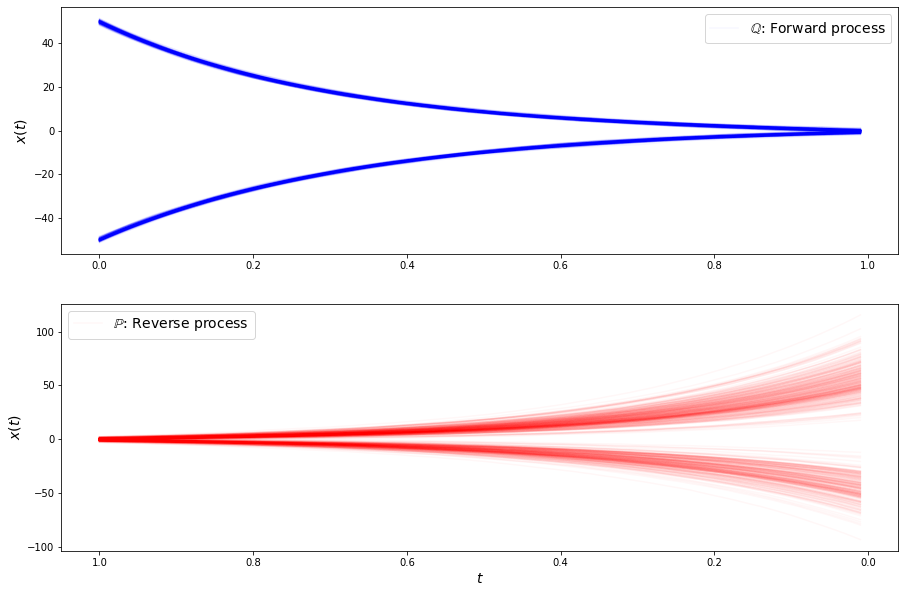

loss b 4.050251483917236
loss b 4.011143684387207
loss b 4.034788131713867
loss b 4.008805751800537
loss b 3.9895827770233154
loss b 4.191414833068848
loss b 4.1224284172058105
loss b 4.003927707672119
loss b 3.9887044429779053
loss b 3.998220443725586
loss b 3.983631134033203
loss b 3.95621919631958
loss b 4.035951614379883
loss b 3.990161895751953
loss b 4.019125938415527
loss b 4.040773868560791
loss b 3.9122891426086426
loss b 3.8690783977508545
loss b 3.969653606414795
loss b 3.9315640926361084
loss b 3.952467918395996
loss b 3.999727964401245
loss f 0.1129118874669075
loss f 0.09467771649360657
loss f 0.0811634436249733
loss f 0.08588292449712753
loss f 0.08966651558876038
loss f 0.0765688568353653
loss f 0.06986045837402344
loss f 0.08042014390230179
loss f 0.07553847879171371
loss f 0.08073901385068893
loss f 0.0837051048874855
loss f 0.08066412061452866
loss f 0.07783998548984528
loss f 0.0844864696264267
loss f 0.08200128376483917
loss f 0.07439994066953659
loss f 0.070154942

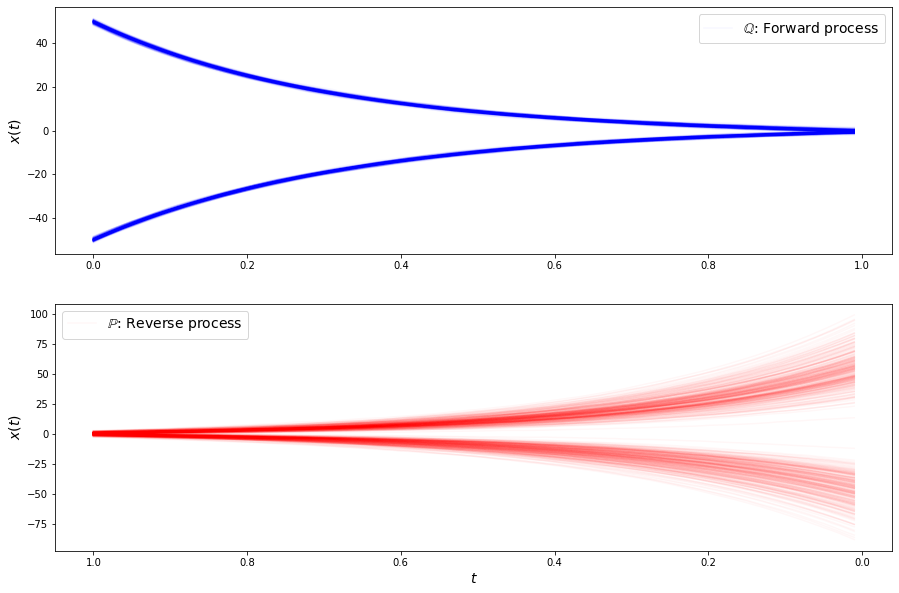

loss b 3.8976078033447266
loss b 3.943444013595581
loss b 3.911581516265869
loss b 3.8680260181427
loss b 3.9124505519866943
loss b 3.9175944328308105
loss b 3.906388521194458
loss b 3.943241596221924
loss b 3.952906847000122
loss b 3.8876922130584717
loss b 3.8800666332244873
loss b 3.8529305458068848
loss b 4.062564373016357
loss b 3.995868682861328
loss b 3.7976694107055664
loss b 3.862380027770996
loss b 3.8920369148254395
loss b 3.9372458457946777
loss b 3.9204540252685547
loss b 3.8435428142547607
loss b 3.862632989883423
loss b 3.857760190963745
loss f 0.05767139792442322
loss f 0.06099056079983711
loss f 0.055893272161483765
loss f 0.05175891891121864
loss f 0.042246464639902115
loss f 0.04427297040820122
loss f 0.0636955127120018
loss f 0.0545625314116478
loss f 0.024254487827420235
loss f 0.03695305436849594
loss f 0.07107415795326233
loss f 0.04924418404698372
loss f 0.054729197174310684
loss f 0.028986020013689995
loss f 0.03964479640126228
loss f 0.05380785092711449
loss f

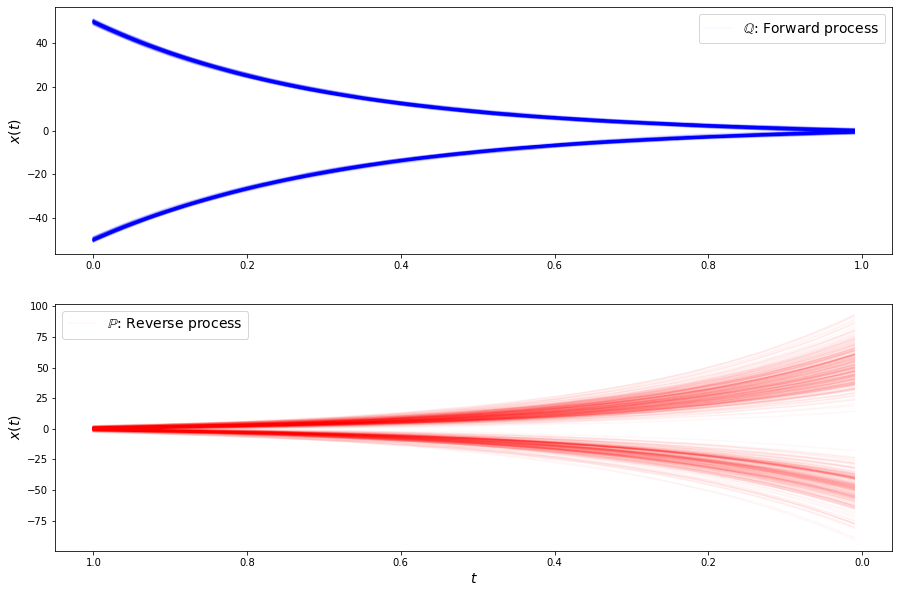

loss b 3.868497610092163
loss b 3.7872061729431152
loss b 3.8236143589019775
loss b 3.8451719284057617
loss b 3.8740527629852295
loss b 3.903686761856079
loss b 3.8398125171661377
loss b 3.813749074935913
loss b 3.8701694011688232
loss b 3.8068418502807617
loss b 3.7215206623077393
loss b 3.8801300525665283
loss b 3.8949615955352783
loss b 3.9159746170043945
loss b 3.8340189456939697
loss b 3.846790313720703
loss b 3.843226432800293
loss b 3.8802218437194824
loss b 3.7780349254608154
loss b 3.9001073837280273
loss b 3.8161869049072266
loss b 3.868727445602417
loss f 0.019953979179263115
loss f 0.024739673361182213
loss f 0.03355079144239426
loss f 0.016334937885403633
loss f 0.03605387359857559
loss f 0.03684261068701744
loss f 0.004132175352424383
loss f 0.01905846782028675
loss f 0.012744592502713203
loss f 0.036802925169467926
loss f 0.015427811071276665
loss f 0.01882982812821865
loss f 0.022156989201903343
loss f 0.013493796810507774
loss f 0.018860699608922005
loss f 0.0406003594

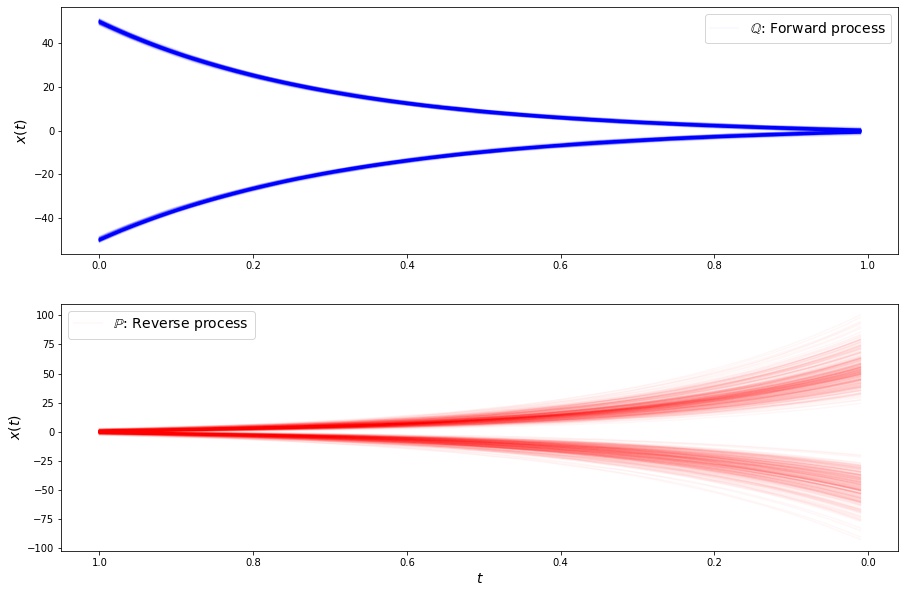

loss b 3.7747459411621094
loss b 3.812830924987793
loss b 3.8551714420318604
loss b 3.8138210773468018
loss b 3.810359001159668
loss b 3.806417226791382
loss b 3.771641969680786
loss b 3.80074143409729
loss b 3.863260507583618
loss b 3.8109629154205322
loss b 3.744290590286255
loss b 3.8328235149383545
loss b 3.7300610542297363
loss b 3.805570363998413
loss b 3.840243101119995
loss b 3.8144044876098633
loss b 3.8379197120666504
loss b 3.7477965354919434
loss b 3.768824338912964
loss b 3.7701337337493896
loss b 3.731332540512085
loss b 3.859396457672119
loss f 0.011394403874874115
loss f 0.0012041296577081084
loss f 0.016994809731841087
loss f 0.03596195578575134
loss f 0.019665870815515518
loss f 0.024138063192367554
loss f 0.02889195643365383
loss f 0.019093623384833336
loss f 0.027929961681365967
loss f 0.019242797046899796
loss f 0.032755300402641296
loss f 0.015672879293560982
loss f 0.009914918802678585
loss f 0.020061396062374115
loss f 0.026645265519618988
loss f 0.0301606450229

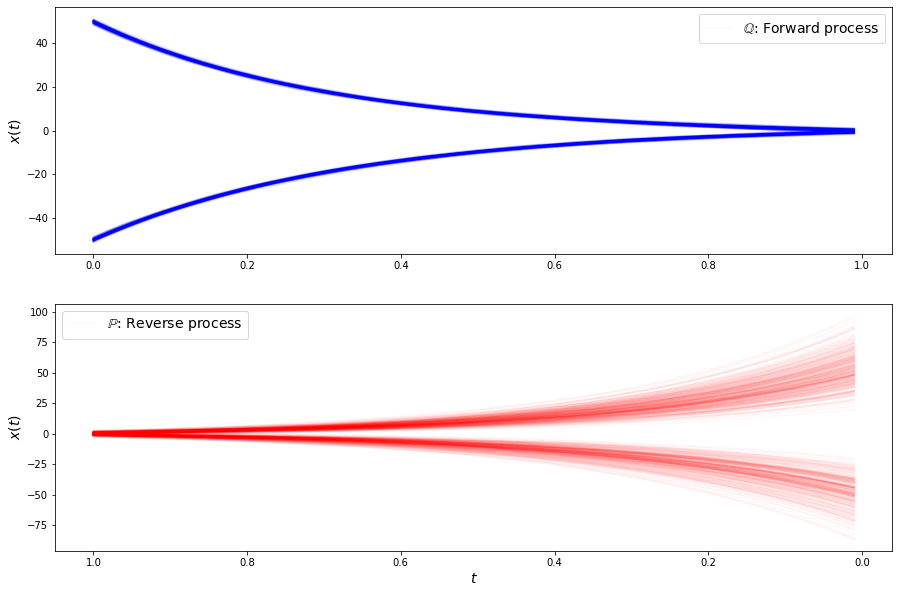

loss b 3.801325559616089
loss b 3.7862465381622314
loss b 3.760533094406128
loss b 3.805976390838623
loss b 3.817821502685547
loss b 3.9039270877838135
loss b 3.852246046066284
loss b 3.737856864929199
loss b 3.7766306400299072
loss b 3.834188461303711
loss b 3.7930877208709717
loss b 3.7283692359924316
loss b 3.74926495552063
loss b 3.70511794090271
loss b 3.7711784839630127
loss b 3.8119945526123047
loss b 3.8371009826660156
loss b 3.8234004974365234
loss b 3.806248903274536
loss b 3.805133581161499
loss b 3.795891523361206
loss b 3.7074108123779297
loss f 0.012514010071754456
loss f 0.022937972098588943
loss f 0.0018882999429479241
loss f 0.02416730858385563
loss f 0.014727633446455002
loss f 0.015926122665405273
loss f 0.015599661506712437
loss f 0.005313977599143982
loss f 0.0019279218977317214
loss f 0.0060841697268188
loss f 0.01010208297520876
loss f 0.010058810003101826
loss f -0.004153384827077389
loss f 0.009689976461231709
loss f 0.015022260136902332
loss f 0.01976488716900

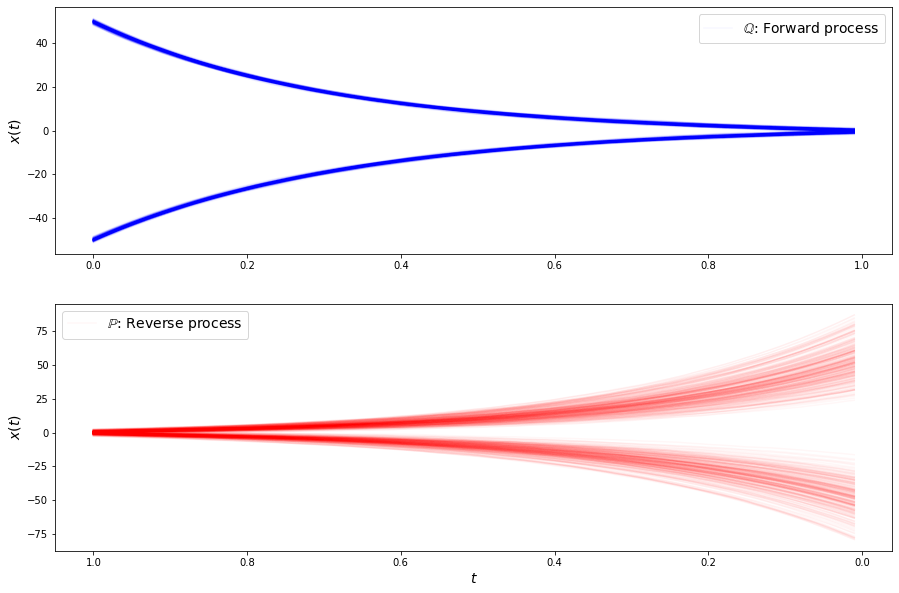

loss b 3.7226619720458984
loss b 3.796576976776123
loss b 3.853135585784912
loss b 3.743161916732788
loss b 3.7537355422973633
loss b 3.803227424621582
loss b 3.8147194385528564
loss b 3.7701311111450195
loss b 3.7924246788024902
loss b 3.8057162761688232
loss b 3.7740225791931152
loss b 3.7699503898620605
loss b 3.769439697265625
loss b 3.8654634952545166
loss b 3.803574323654175
loss b 3.8086929321289062
loss b 3.747267007827759
loss b 3.844449281692505
loss b 3.7735848426818848
loss b 3.8200008869171143
loss b 3.7319862842559814
loss b 3.8234105110168457
loss f -0.0018464169697836041
loss f 0.0058501111343503
loss f 0.011240346357226372
loss f 0.014208025299012661
loss f -9.508435323368758e-05
loss f 0.0012481235899031162
loss f 0.004120672587305307
loss f 0.014043173752725124
loss f 0.013029031455516815
loss f 0.010564731433987617
loss f 0.011703900061547756
loss f 0.003175661200657487
loss f 0.02841019444167614
loss f 0.019628101959824562
loss f 0.01472487673163414
loss f 0.004716

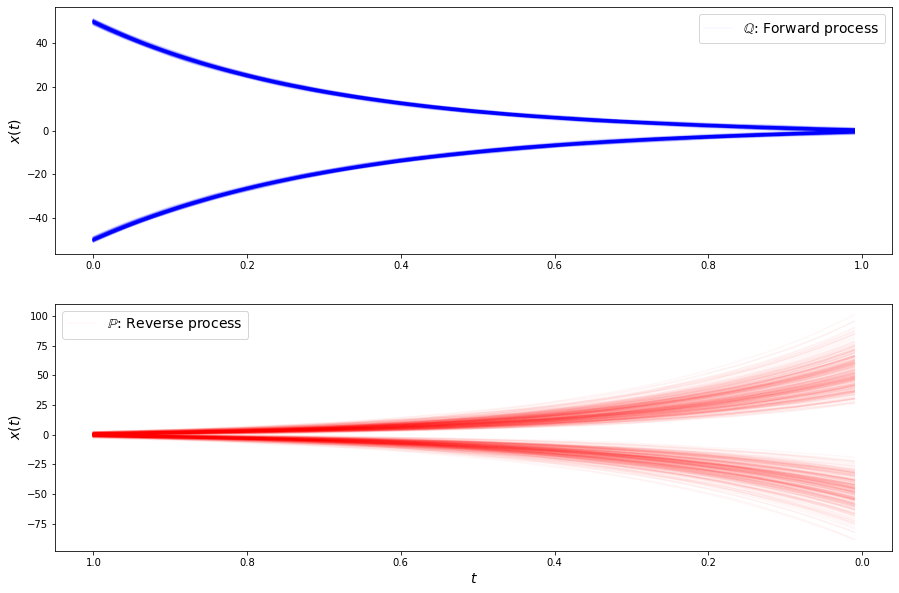

loss b 3.7984540462493896
loss b 3.754990577697754
loss b 3.7322909832000732
loss b 3.7822349071502686
loss b 3.753599166870117
loss b 3.7527854442596436
loss b 3.743410110473633
loss b 3.7343900203704834
loss b 3.7605764865875244
loss b 3.643486738204956
loss b 3.7550666332244873
loss b 3.8477964401245117
loss b 3.819237232208252
loss b 3.76503586769104
loss b 3.7323853969573975
loss b 3.8361709117889404
loss b 3.7942559719085693
loss b 3.742017984390259
loss b 3.7852842807769775
loss b 3.823132038116455
loss b 3.7283689975738525
loss b 3.7760093212127686
loss f -0.002134439768269658
loss f 0.0031334299128502607
loss f 0.029664359986782074
loss f 0.003602192271500826
loss f 0.004821850452572107
loss f 0.0019513241713866591
loss f 0.002763431752100587
loss f -0.012129900977015495
loss f 0.011397085152566433
loss f 0.03609081357717514
loss f -0.015169410966336727
loss f 0.004565760958939791
loss f 0.010841109789907932
loss f 0.0018603310454636812
loss f 0.006287488155066967
loss f -0.01

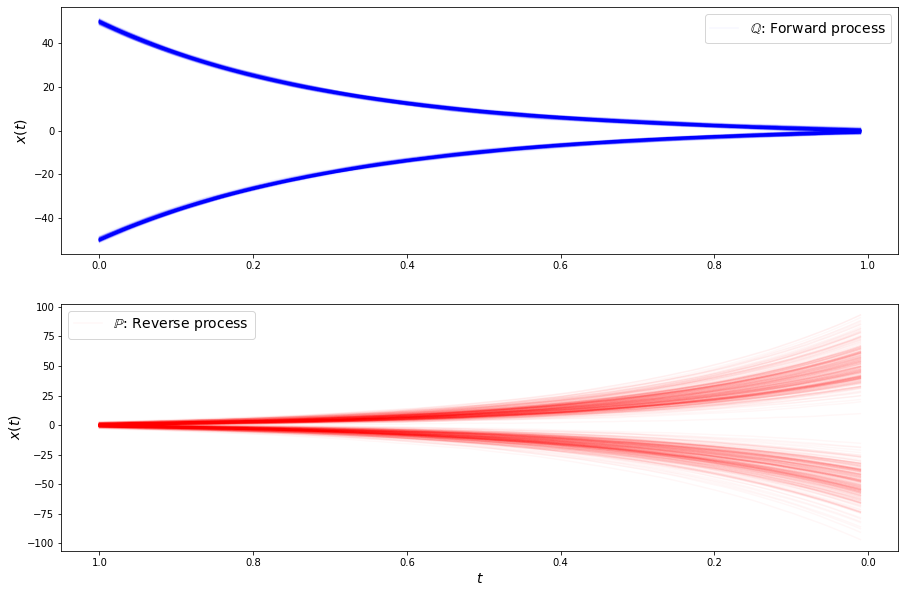

loss b 3.750990152359009
loss b 3.770557403564453
loss b 3.7203214168548584
loss b 3.7715530395507812
loss b 3.7119803428649902
loss b 3.7945973873138428
loss b 3.7208354473114014
loss b 3.742555618286133
loss b 3.6825764179229736
loss b 3.806605100631714
loss b 3.7530527114868164
loss b 3.7931456565856934
loss b 3.7603983879089355
loss b 3.795109272003174
loss b 3.7731335163116455
loss b 3.7256383895874023
loss b 3.839879035949707
loss b 3.7947945594787598
loss b 3.801215887069702
loss b 3.746983051300049
loss b 3.8184194564819336
loss b 3.7017805576324463
loss f 0.010730982758104801
loss f -0.0024213027209043503
loss f -0.01127232052385807
loss f -0.02466745302081108
loss f -0.004059764556586742
loss f 0.003707194235175848
loss f 0.004412034060806036
loss f 0.0026192183140665293
loss f -0.006809146609157324
loss f 0.005623156670480967
loss f -0.0012828335165977478
loss f -0.005539129488170147
loss f -0.0046506053768098354
loss f 0.004174181260168552
loss f 0.002461157739162445
loss f

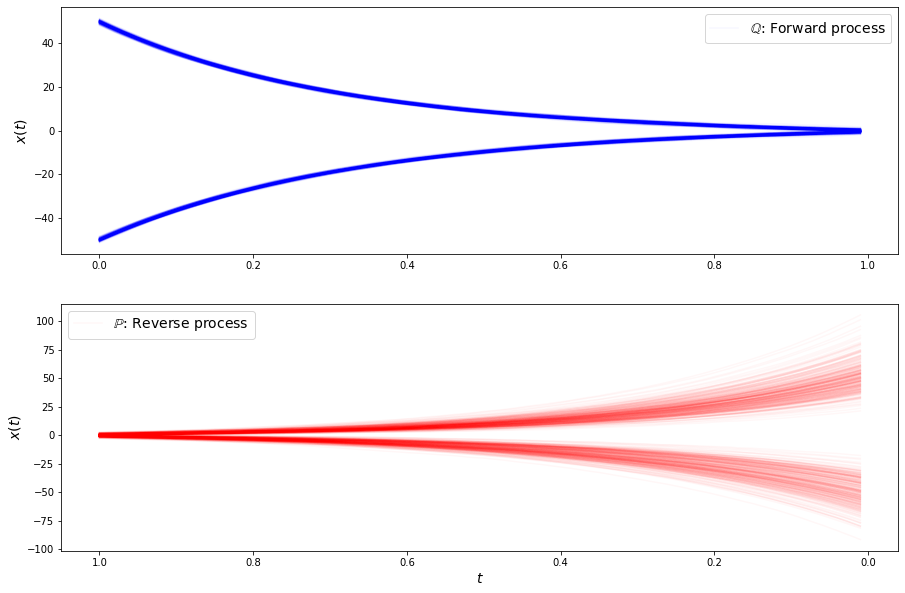

loss b 3.7052037715911865
loss b 3.794983148574829
loss b 3.7544403076171875
loss b 3.8208580017089844
loss b 3.643486976623535
loss b 3.8004000186920166
loss b 3.7002313137054443
loss b 3.817221164703369
loss b 3.7293615341186523
loss b 3.7328555583953857
loss b 3.768666982650757
loss b 3.7710955142974854
loss b 3.7064690589904785
loss b 3.747169017791748
loss b 3.7388598918914795
loss b 3.715958595275879
loss b 3.804708957672119
loss b 3.7821404933929443
loss b 3.74599552154541
loss b 3.8382110595703125
loss b 3.7890818119049072
loss b 3.783186435699463
loss f -0.0024320941884070635
loss f -0.023068444803357124
loss f -0.012695410288870335
loss f -0.019451936706900597
loss f -0.0014392475131899118
loss f 0.010234701447188854
loss f -0.010989820584654808
loss f -0.0018858547555282712
loss f -0.01690332032740116
loss f 0.016137445345520973
loss f -0.0058435918763279915
loss f -0.009896892122924328
loss f 0.017933135852217674
loss f 0.004588754381984472
loss f 0.00377092813141644
loss f

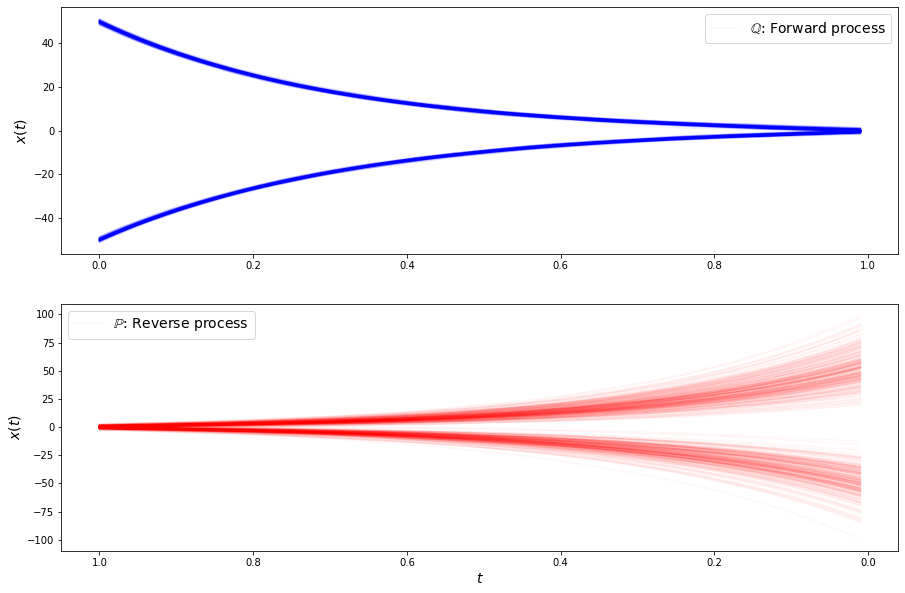

loss b 3.7893495559692383
loss b 3.86501145362854
loss b 3.760495662689209
loss b 3.7568209171295166
loss b 3.8177249431610107
loss b 3.8125572204589844
loss b 3.7018282413482666
loss b 3.837445020675659
loss b 3.721811532974243
loss b 3.7449960708618164
loss b 3.796736240386963
loss b 3.760512590408325
loss b 3.757237672805786
loss b 3.7153406143188477
loss b 3.84865140914917
loss b 3.78171968460083
loss b 3.714735746383667
loss b 3.8072149753570557
loss b 3.82207989692688
loss b 3.847835063934326
loss b 3.8196945190429688
loss b 3.7665553092956543
loss f -0.003928470890969038
loss f 0.007041040807962418
loss f 0.003675658255815506
loss f -0.0077438391745090485
loss f -0.008085484616458416
loss f -0.01683732680976391
loss f -0.010064393281936646
loss f 0.013591006398200989
loss f -0.020524058490991592
loss f -0.017299020662903786
loss f -0.02171560749411583
loss f -0.02505195327103138
loss f -0.0017699087038636208
loss f 0.0001303808530792594
loss f -0.0009509946103207767
loss f -0.00

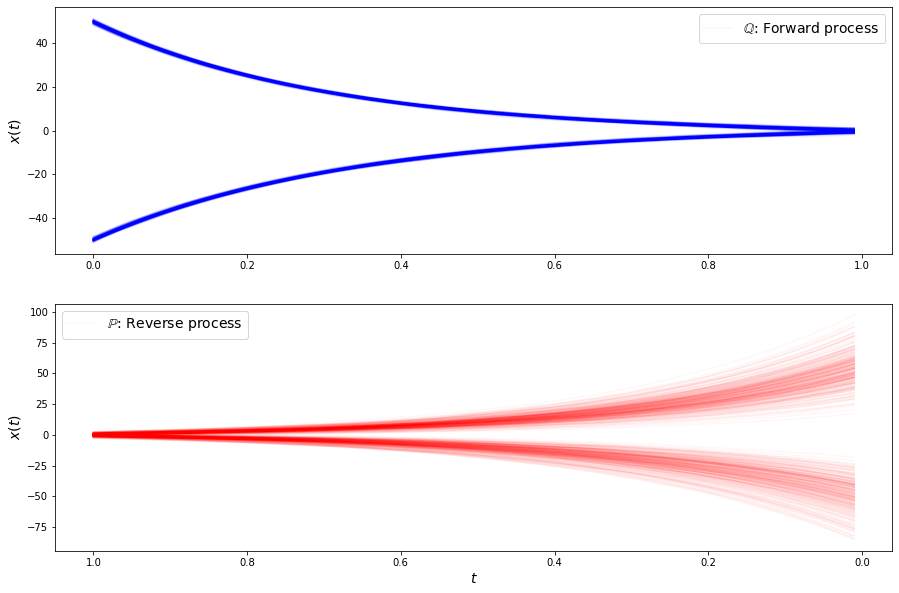

loss b 3.7328007221221924
loss b 3.701262950897217
loss b 3.772334575653076
loss b 3.723473072052002
loss b 3.6986660957336426
loss b 3.7431681156158447
loss b 3.673226833343506
loss b 3.7436952590942383
loss b 3.7267680168151855
loss b 3.7333197593688965
loss b 3.7647719383239746
loss b 3.7846076488494873
loss b 3.7342100143432617
loss b 3.7479875087738037
loss b 3.7933411598205566
loss b 3.7105600833892822
loss b 3.778261423110962
loss b 3.8013226985931396
loss b 3.711521863937378
loss b 3.7928659915924072
loss b 3.770543336868286
loss b 3.7277944087982178
loss f -0.012567359954118729
loss f -0.0018925131298601627
loss f -0.0007860205369070172
loss f 8.949511538958177e-05
loss f 0.003625604324042797
loss f 0.0036215404979884624
loss f -0.004077301360666752
loss f 0.004282754845917225
loss f -0.007724833209067583
loss f -0.0011968954931944609
loss f 0.0005970864440314472
loss f 0.008263627998530865
loss f -0.013476754538714886
loss f -0.015147455036640167
loss f 0.006991755682975054
l

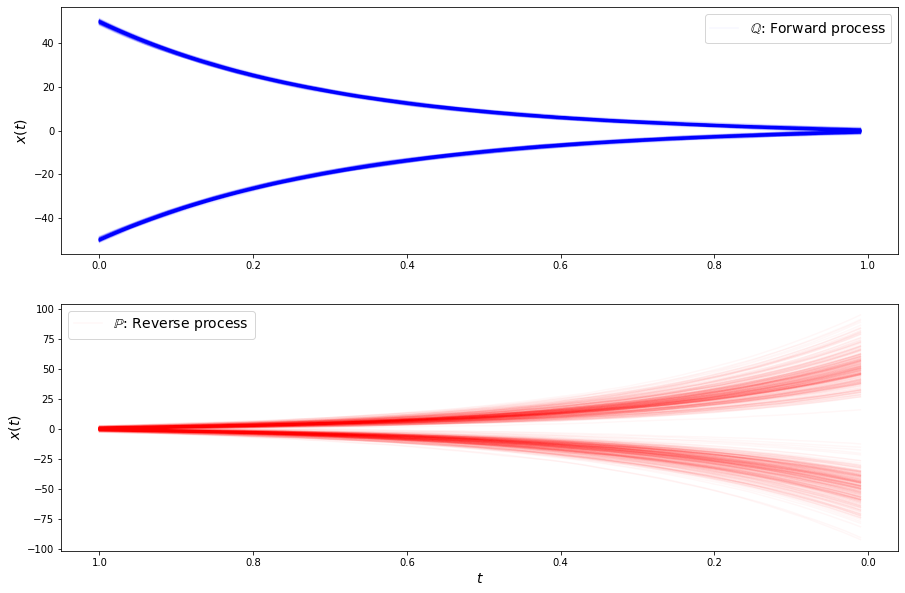

loss b 3.759389638900757
loss b 3.7371835708618164
loss b 3.7711715698242188
loss b 3.773679256439209
loss b 3.746737480163574
loss b 3.737403631210327
loss b 3.8191540241241455
loss b 3.719850540161133
loss b 3.6678004264831543
loss b 3.75758695602417
loss b 3.7021028995513916
loss b 3.7490530014038086
loss b 3.799715995788574
loss b 3.7791647911071777
loss b 3.725820541381836
loss b 3.7751078605651855
loss b 3.744499921798706
loss b 3.7886085510253906
loss b 3.7392542362213135
loss b 3.7215445041656494
loss b 3.7127912044525146
loss b 3.7833454608917236
loss f -0.006539896596223116
loss f -0.009416507557034492
loss f -0.006535948254168034
loss f -0.011376263573765755
loss f -0.007264281157404184
loss f -0.002718190895393491
loss f 0.004619793966412544
loss f -0.013592895120382309
loss f -0.007745808456093073
loss f -0.008281946182250977
loss f -0.0013347412459552288
loss f -0.016325609758496284
loss f -0.0192448440939188
loss f -0.0110407629981637
loss f -0.01994680054485798
loss f -

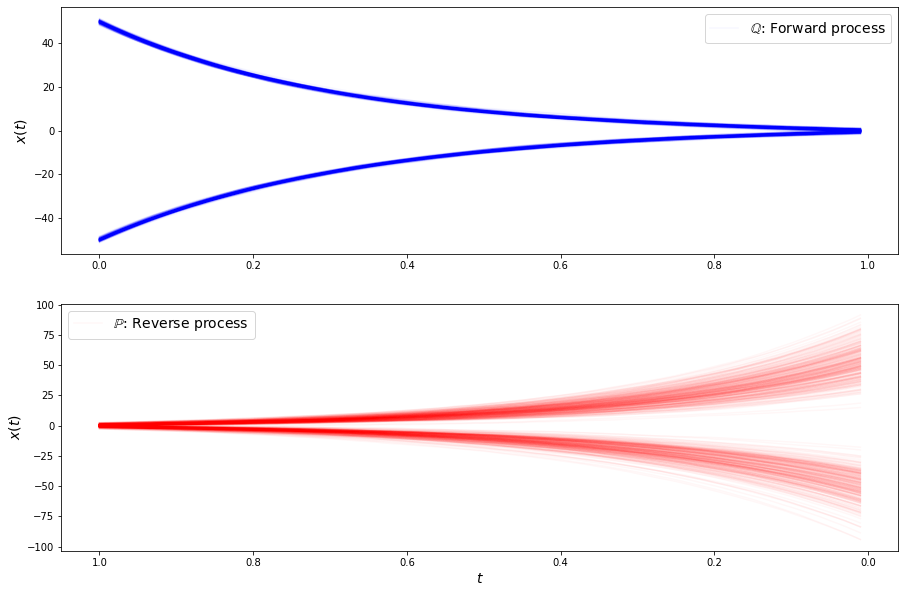

loss b 3.7161054611206055
loss b 3.711725950241089
loss b 3.763737440109253
loss b 3.724860429763794
loss b 3.7774100303649902
loss b 3.713433027267456
loss b 3.7130544185638428
loss b 3.7368459701538086
loss b 3.707744836807251
loss b 3.7552852630615234
loss b 3.7027766704559326
loss b 3.7306180000305176
loss b 3.729642391204834
loss b 3.741739511489868
loss b 3.7290236949920654
loss b 3.7251439094543457
loss b 3.6944544315338135
loss b 3.793846368789673
loss b 3.7504703998565674
loss b 3.7937870025634766
loss b 3.697612762451172
loss b 3.7093122005462646
loss f -0.015467710793018341
loss f -0.021625075489282608
loss f -0.022275714203715324
loss f -0.004394209943711758
loss f 0.0011675824644044042
loss f -0.02165168896317482
loss f -0.008603482507169247
loss f -0.002782690804451704
loss f 0.009742853231728077
loss f -0.028849000111222267
loss f -0.005420218221843243
loss f -0.004126510117202997
loss f -0.011801496148109436
loss f -0.002408522879704833
loss f -0.005225409287959337
loss

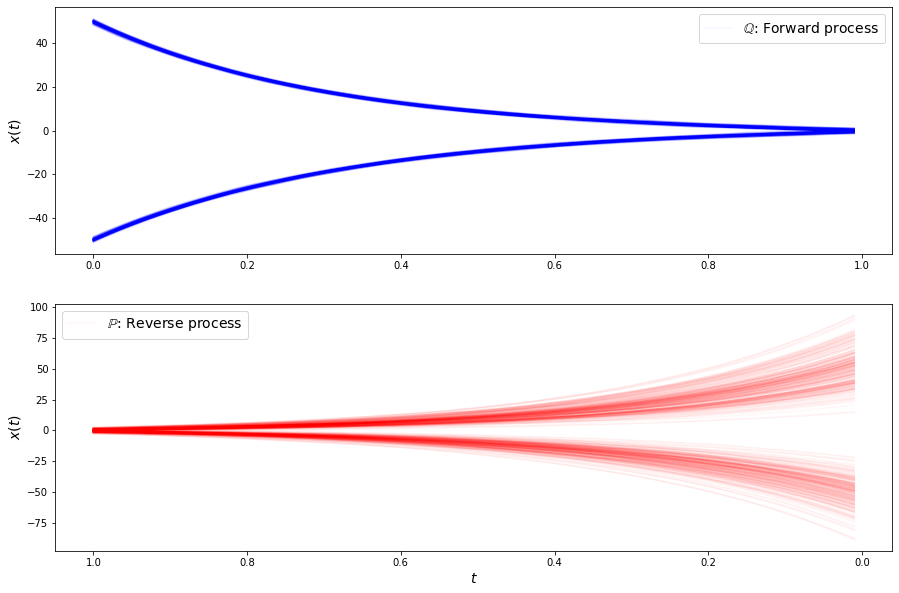

loss b 3.789017915725708
loss b 3.7711422443389893
loss b 3.748495578765869
loss b 3.6812384128570557
loss b 3.809354543685913
loss b 3.7603325843811035
loss b 3.788818359375
loss b 3.708043098449707
loss b 3.7857489585876465
loss b 3.6663129329681396
loss b 3.6936697959899902
loss b 3.7880146503448486
loss b 3.7920658588409424
loss b 3.815986394882202
loss b 3.6871564388275146
loss b 3.8201334476470947
loss b 3.713411331176758
loss b 3.713031053543091
loss b 3.764349937438965
loss b 3.7761380672454834
loss b 3.758178472518921
loss b 3.7042174339294434
loss f -0.025265762582421303
loss f -0.0005788725684396923
loss f -0.006306695751845837
loss f -0.013653511181473732
loss f -0.016462797299027443
loss f -0.016941407695412636
loss f -0.008492166176438332
loss f -0.0061504230834543705
loss f -0.024745292961597443
loss f -0.007259335834532976
loss f -0.01705789752304554
loss f -0.014078855514526367
loss f -0.01734129898250103
loss f -0.013111909851431847
loss f -0.01614002324640751
loss f 

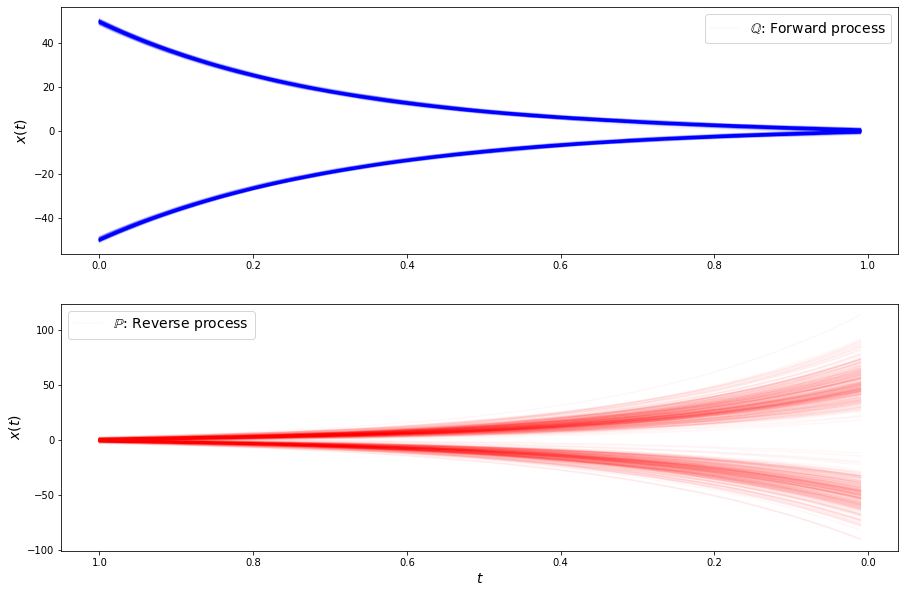

loss b 3.774167537689209
loss b 3.796562671661377
loss b 3.672086238861084
loss b 3.7484922409057617
loss b 3.7446627616882324
loss b 3.835374593734741
loss b 3.778968572616577
loss b 3.702387809753418
loss b 3.7764954566955566
loss b 3.7347800731658936
loss b 3.795027017593384
loss b 3.7822659015655518
loss b 3.814857006072998
loss b 3.6995790004730225
loss b 3.6610069274902344
loss b 3.6859757900238037
loss b 3.7556450366973877
loss b 3.7231216430664062
loss b 3.7506375312805176
loss b 3.7758541107177734
loss b 3.8533968925476074
loss b 3.7522244453430176
loss f -0.005822694860398769
loss f -0.001386018586345017
loss f 0.0035374509170651436
loss f -0.006203665863722563
loss f -0.024389121681451797
loss f -0.004980032332241535
loss f -0.019029883667826653
loss f -0.004993564449250698
loss f -0.02343263477087021
loss f -0.026797525584697723
loss f -0.020539410412311554
loss f -0.009240791201591492
loss f -0.0248049795627594
loss f -0.022222746163606644
loss f -0.02192070335149765
loss 

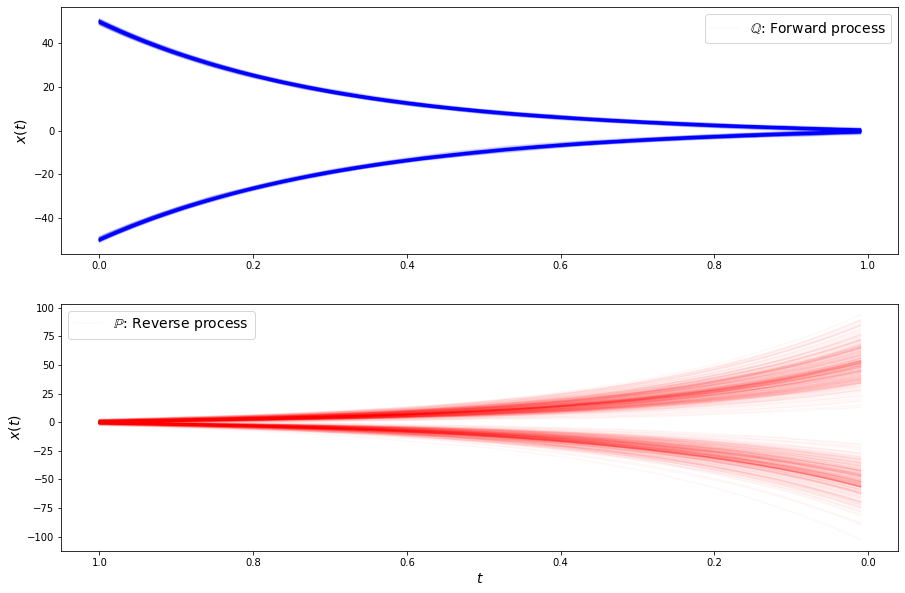

loss b 3.7362964153289795
loss b 3.7504489421844482
loss b 3.7149856090545654
loss b 3.7711145877838135
loss b 3.731790065765381
loss b 3.751207113265991
loss b 3.71517014503479
loss b 3.7462520599365234
loss b 3.6886494159698486
loss b 3.705686330795288
loss b 3.7663140296936035
loss b 3.7643258571624756
loss b 3.6976382732391357
loss b 3.8094944953918457
loss b 3.7052042484283447
loss b 3.7795658111572266
loss b 3.6710927486419678
loss b 3.769780397415161
loss b 3.790370464324951
loss b 3.728292942047119
loss b 3.7837679386138916
loss b 3.7436251640319824
loss f -0.01781453937292099
loss f -0.007504242472350597
loss f -0.010835214518010616
loss f -0.012993082404136658
loss f -0.020064521580934525
loss f -0.02038399502635002
loss f -0.009964189492166042
loss f -0.0005462607368826866
loss f -0.024312399327754974
loss f -0.0134138073772192
loss f -0.022439977154135704
loss f -0.006563869304955006
loss f -0.026196831837296486
loss f -0.028749430552124977
loss f -0.015933075919747353
loss

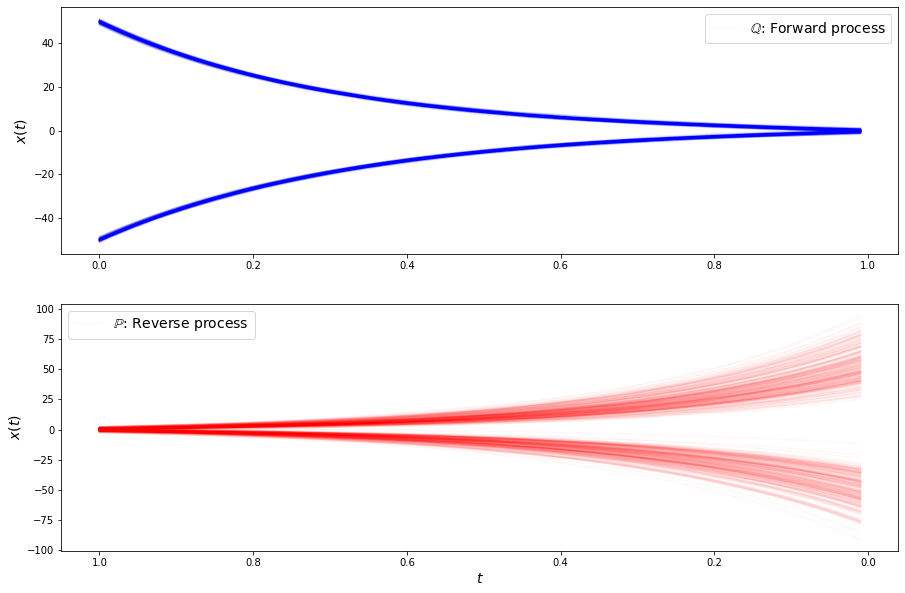

loss b 3.7018675804138184
loss b 3.7740724086761475
loss b 3.785574436187744
loss b 3.7604739665985107
loss b 3.7007346153259277
loss b 3.7275872230529785
loss b 3.8132364749908447
loss b 3.7104036808013916
loss b 3.715005397796631
loss b 3.729609489440918
loss b 3.7367055416107178
loss b 3.7550086975097656
loss b 3.7402079105377197
loss b 3.8064284324645996
loss b 3.728616952896118
loss b 3.7139930725097656
loss b 3.7335264682769775
loss b 3.7304186820983887
loss b 3.824908971786499
loss b 3.753251552581787
loss b 3.733041524887085
loss b 3.737478017807007
loss f -0.02200578898191452
loss f -0.03140924870967865
loss f -0.02659320831298828
loss f -0.04462985321879387
loss f -0.0027431542985141277
loss f -0.013772483915090561
loss f 0.007191210985183716
loss f -0.01724208891391754
loss f -0.020656876266002655
loss f -0.023049606010317802
loss f -0.029662739485502243
loss f -0.029595935717225075
loss f -0.025858813896775246
loss f -0.0015288994181901217
loss f -0.011523040011525154
loss 

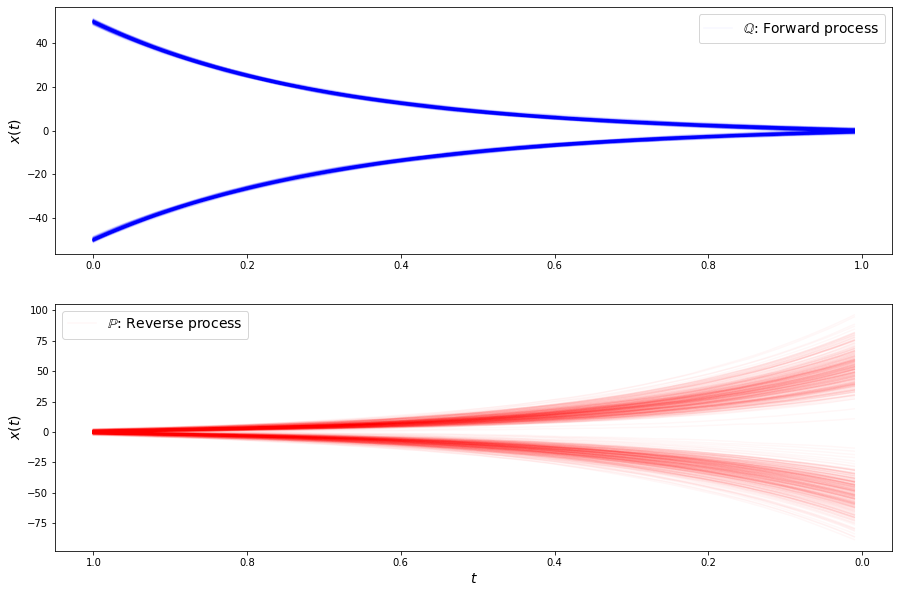

loss b 3.7948992252349854
loss b 3.7735235691070557
loss b 3.796941041946411
loss b 3.7217841148376465
loss b 3.7710111141204834
loss b 3.7751269340515137
loss b 3.7114529609680176
loss b 3.7553908824920654
loss b 3.7984778881073
loss b 3.747313976287842
loss b 3.756925582885742
loss b 3.730823516845703
loss b 3.8232269287109375
loss b 3.7163894176483154
loss b 3.722888469696045
loss b 3.7763750553131104
loss b 3.7917320728302
loss b 3.792005777359009
loss b 3.7320165634155273
loss b 3.727043390274048
loss b 3.7762649059295654
loss b 3.79652738571167
loss f -0.01661401055753231
loss f -0.026171570643782616
loss f -0.02982763759791851
loss f -0.023838847875595093
loss f -0.03462439030408859
loss f -0.02978292666375637
loss f -0.023334331810474396
loss f -0.01871940679848194
loss f -0.028848323971033096
loss f -0.027273068204522133
loss f -0.01696459762752056
loss f -0.02152140624821186
loss f -0.016062019392848015
loss f -0.020660020411014557
loss f -0.01993928849697113
loss f -0.026039

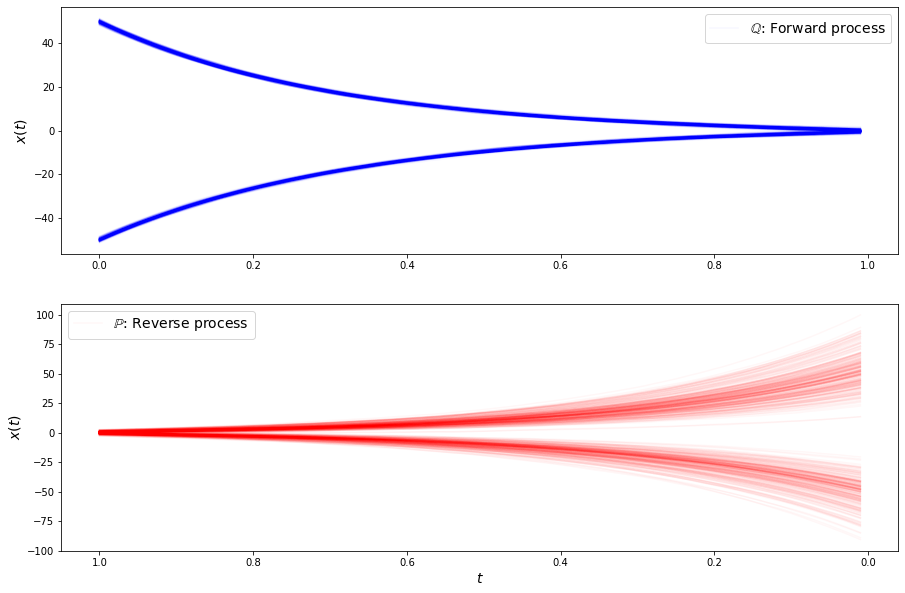

loss b 3.689724922180176
loss b 3.6937828063964844
loss b 3.7467117309570312
loss b 3.80377459526062
loss b 3.709699869155884
loss b 3.7533326148986816
loss b 3.7556052207946777
loss b 3.72261905670166
loss b 3.723694086074829
loss b 3.679893970489502
loss b 3.792442560195923
loss b 3.7249915599823
loss b 3.7759547233581543
loss b 3.756741762161255
loss b 3.8064215183258057
loss b 3.771296977996826
loss b 3.8155999183654785
loss b 3.774740695953369
loss b 3.6626944541931152
loss b 3.735400915145874
loss b 3.8163902759552
loss b 3.7932591438293457
loss f -0.02668120339512825
loss f -0.008471238426864147
loss f -0.03765331581234932
loss f -0.012829780578613281
loss f -0.04362805187702179
loss f -0.02667001634836197
loss f -0.017183925956487656
loss f -0.01592094637453556
loss f -0.023805096745491028
loss f -0.027780726552009583
loss f -0.00763235567137599
loss f -0.03174716979265213
loss f -0.024403614923357964
loss f -0.0266739409416914
loss f -0.020040316507220268
loss f -0.02884702384

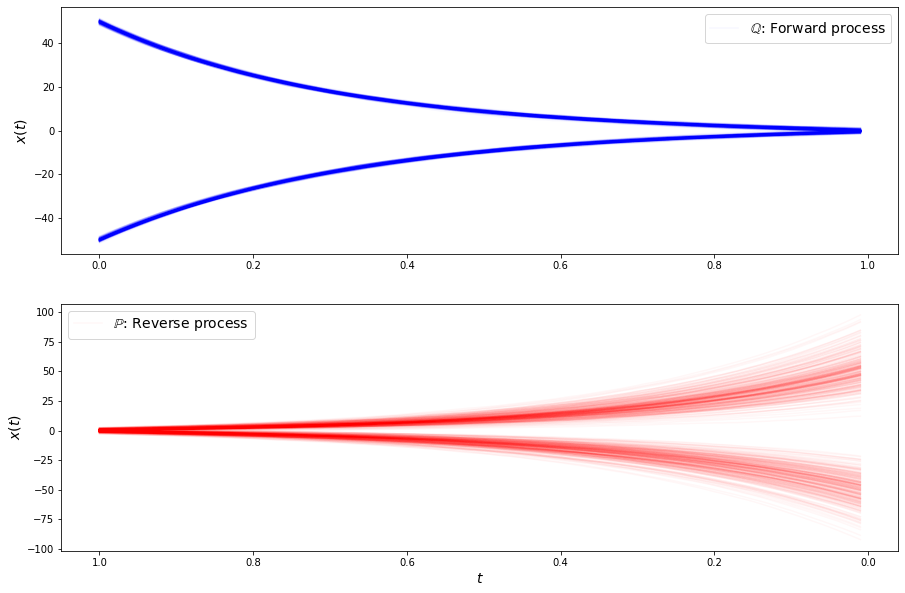

loss b 3.695981979370117
loss b 3.7189815044403076
loss b 3.715373992919922
loss b 3.7195799350738525
loss b 3.787433385848999
loss b 3.7644290924072266
loss b 3.768277406692505
loss b 3.750089406967163
loss b 3.6953094005584717
loss b 3.736835479736328
loss b 3.7485337257385254
loss b 3.792031764984131
loss b 3.773444890975952
loss b 3.753574848175049
loss b 3.778059482574463
loss b 3.755126953125
loss b 3.7205729484558105
loss b 3.8200631141662598
loss b 3.74849009513855
loss b 3.7294936180114746
loss b 3.7749664783477783
loss b 3.84651780128479
loss f -0.02664555422961712
loss f -0.02393127791583538
loss f -0.03273237124085426
loss f -0.01222645677626133
loss f -0.023217707872390747
loss f -0.020919816568493843
loss f -0.01259851735085249
loss f -0.019173933193087578
loss f -0.026090173050761223
loss f -0.02454739436507225
loss f -0.016615241765975952
loss f -0.013044819235801697
loss f -0.021730640903115273
loss f -0.011041667312383652
loss f -0.020081860944628716
loss f -0.0107933

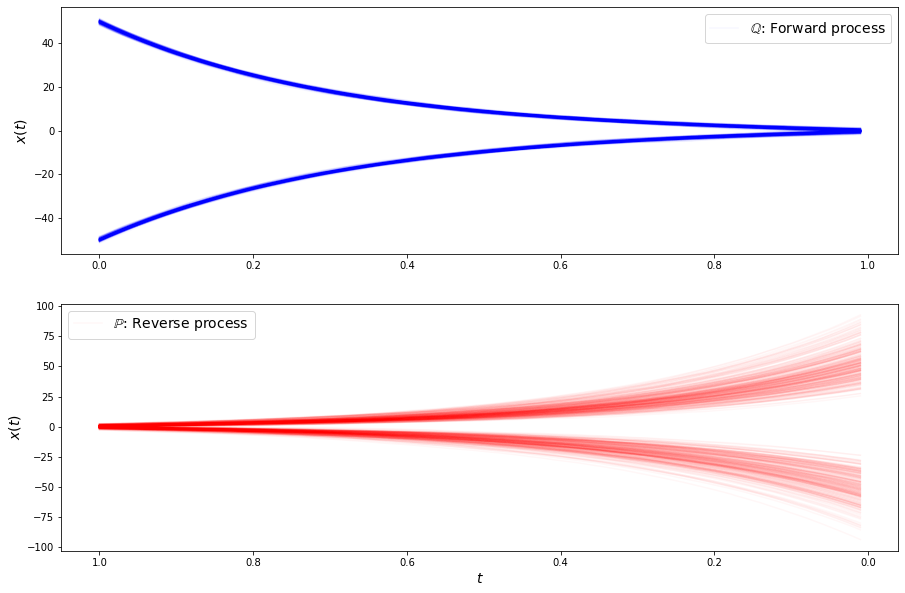

loss b 3.851109504699707
loss b 3.858280658721924
loss b 3.7399215698242188
loss b 3.7658867835998535
loss b 3.811830520629883
loss b 3.7376019954681396
loss b 3.7204558849334717
loss b 3.864776134490967
loss b 3.7139649391174316
loss b 3.7383334636688232
loss b 3.679194211959839
loss b 3.757986068725586
loss b 3.7139358520507812
loss b 3.7341291904449463
loss b 3.759115695953369
loss b 3.7888762950897217
loss b 3.7069931030273438
loss b 3.782203435897827
loss b 3.786409616470337
loss b 3.803957939147949
loss b 3.826259136199951
loss b 3.7672479152679443
loss f -0.02240201085805893
loss f -0.017365535721182823
loss f -0.001299553201533854
loss f -0.016152506694197655
loss f -0.011055062524974346
loss f -0.01789885014295578
loss f -0.037541694939136505
loss f -0.020966913551092148
loss f -0.0299848485738039
loss f -0.005306266713887453
loss f -0.0365317240357399
loss f -0.030503688380122185
loss f -0.017604002729058266
loss f -0.021431760862469673
loss f -0.01578618586063385
loss f -0.0

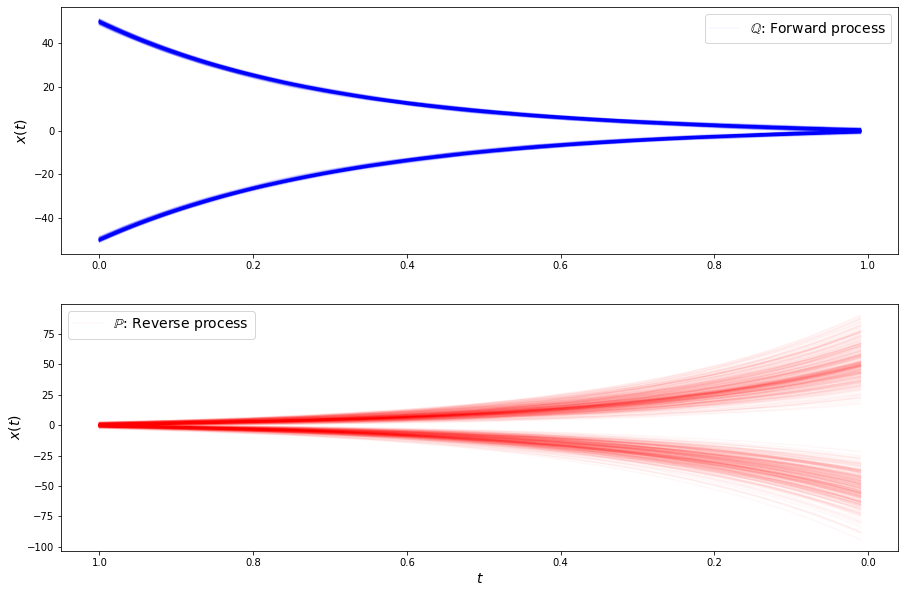

loss b 3.810502052307129
loss b 3.707242488861084
loss b 3.721195697784424
loss b 3.829301118850708
loss b 3.7576329708099365
loss b 3.800264596939087
loss b 3.677001953125
loss b 3.754638910293579
loss b 3.7410049438476562
loss b 3.764167070388794
loss b 3.7480037212371826
loss b 3.7058098316192627
loss b 3.734280586242676
loss b 3.7699294090270996
loss b 3.71882700920105
loss b 3.7613980770111084
loss b 3.7723779678344727
loss b 3.7919089794158936
loss b 3.8152964115142822
loss b 3.6802730560302734
loss b 3.782393455505371
loss b 3.7213025093078613
loss f -0.030902843922376633
loss f -0.010337715037167072
loss f -0.028735002502799034
loss f -0.010497747920453548
loss f -0.01653796061873436
loss f -0.026586370542645454
loss f -0.023837532848119736
loss f -0.02734128013253212
loss f -0.02509453147649765
loss f -0.021312156692147255
loss f -0.010960088111460209
loss f -0.02997053973376751
loss f -0.01168830692768097
loss f -0.023428479209542274
loss f -0.034293826669454575
loss f -0.023

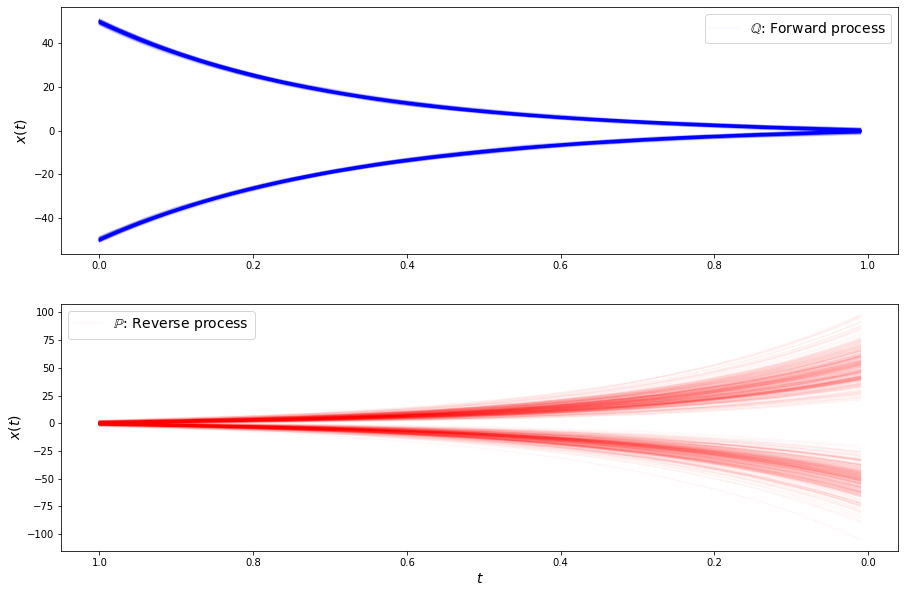

loss b 3.7827634811401367
loss b 3.7681446075439453
loss b 3.7462658882141113
loss b 3.7520394325256348
loss b 3.7162694931030273
loss b 3.8025870323181152
loss b 3.7607219219207764
loss b 3.668128728866577
loss b 3.6731245517730713
loss b 3.6990246772766113
loss b 3.711988687515259
loss b 3.7318904399871826
loss b 3.7744345664978027
loss b 3.823375940322876
loss b 3.755863904953003
loss b 3.7333219051361084
loss b 3.7935845851898193
loss b 3.8470213413238525
loss b 3.735337018966675
loss b 3.818002700805664
loss b 3.7632710933685303
loss b 3.7455825805664062
loss f -0.03745969757437706
loss f -0.015051103197038174
loss f -0.037075355648994446
loss f -0.026030275970697403
loss f 0.002511129016056657
loss f -0.03818931803107262
loss f -0.03395596146583557
loss f -0.025360293686389923
loss f -0.015739329159259796
loss f -0.02999315969645977
loss f -0.02818187326192856
loss f -0.026446601375937462
loss f -0.015727903693914413
loss f -0.02134181186556816
loss f -0.036101605743169785
loss f

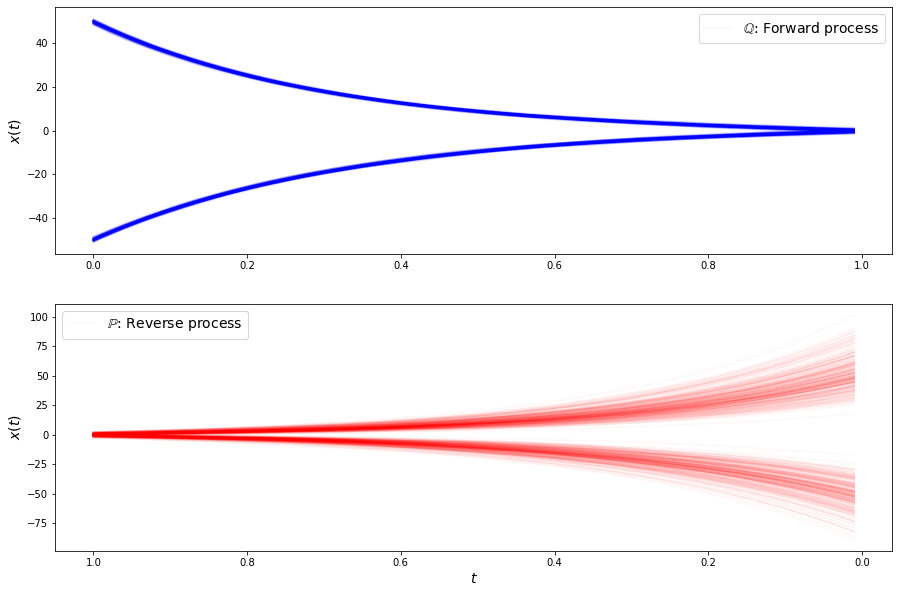

loss b 3.6857359409332275
loss b 3.795931100845337
loss b 3.7000346183776855
loss b 3.7732584476470947
loss b 3.6861705780029297
loss b 3.7479610443115234
loss b 3.7210638523101807
loss b 3.7167999744415283
loss b 3.7568509578704834
loss b 3.738940954208374
loss b 3.7391271591186523
loss b 3.7170565128326416
loss b 3.717399835586548
loss b 3.7556331157684326
loss b 3.7358291149139404
loss b 3.674776792526245
loss b 3.759516954421997
loss b 3.7245845794677734
loss b 3.750511884689331
loss b 3.7379345893859863
loss b 3.7883143424987793
loss b 3.6712560653686523
loss f -0.030296487733721733
loss f -0.009193011559545994
loss f -0.027841288596391678
loss f -0.009908726438879967
loss f -0.04135727509856224
loss f -0.03469524905085564
loss f -0.023974794894456863
loss f -0.02826678566634655
loss f -0.03251875936985016
loss f -0.033156827092170715
loss f -0.04146137833595276
loss f -0.03713672608137131
loss f -0.025920320302248
loss f -0.019834131002426147
loss f -0.016717806458473206
loss f -

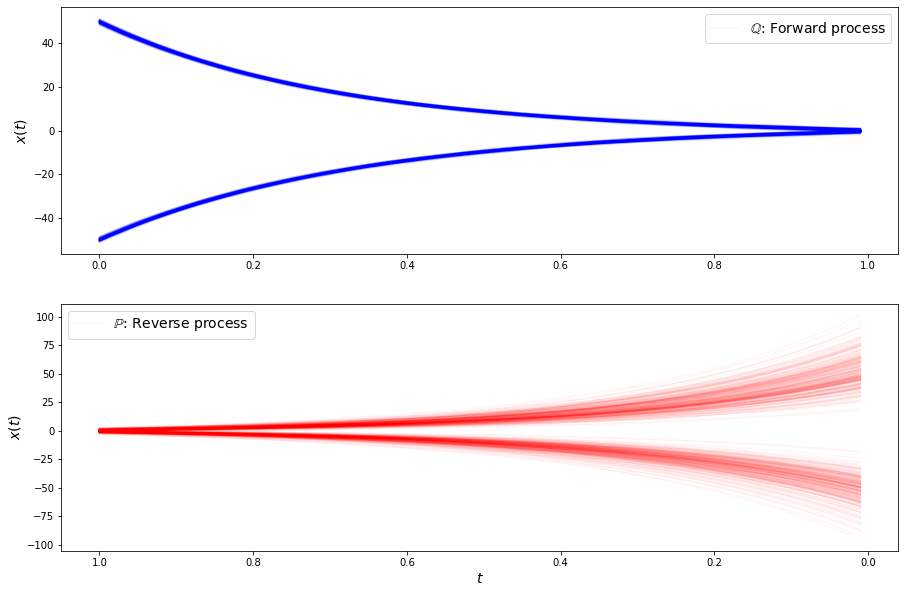

loss b 3.7356183528900146
loss b 3.8313119411468506
loss b 3.708292007446289
loss b 3.72865891456604
loss b 3.737652540206909
loss b 3.709751844406128
loss b 3.729581832885742
loss b 3.758680820465088
loss b 3.6833655834198
loss b 3.776749849319458
loss b 3.7628376483917236
loss b 3.7104930877685547
loss b 3.735506534576416
loss b 3.764983654022217
loss b 3.8176629543304443
loss b 3.7751924991607666
loss b 3.757819890975952
loss b 3.7549641132354736
loss b 3.6930885314941406
loss b 3.7995643615722656
loss b 3.7628495693206787
loss b 3.744837999343872
loss f -0.022812562063336372
loss f -0.040133945643901825
loss f -0.045503243803977966
loss f -0.013630487956106663
loss f -0.03762981295585632
loss f -0.010224618017673492
loss f -0.003939497750252485
loss f -0.021253062412142754
loss f -0.02771521918475628
loss f -0.03379547595977783
loss f -0.017672937363386154
loss f -0.02043812908232212
loss f -0.03783579543232918
loss f -0.04170312359929085
loss f -0.023162271827459335
loss f -0.0278

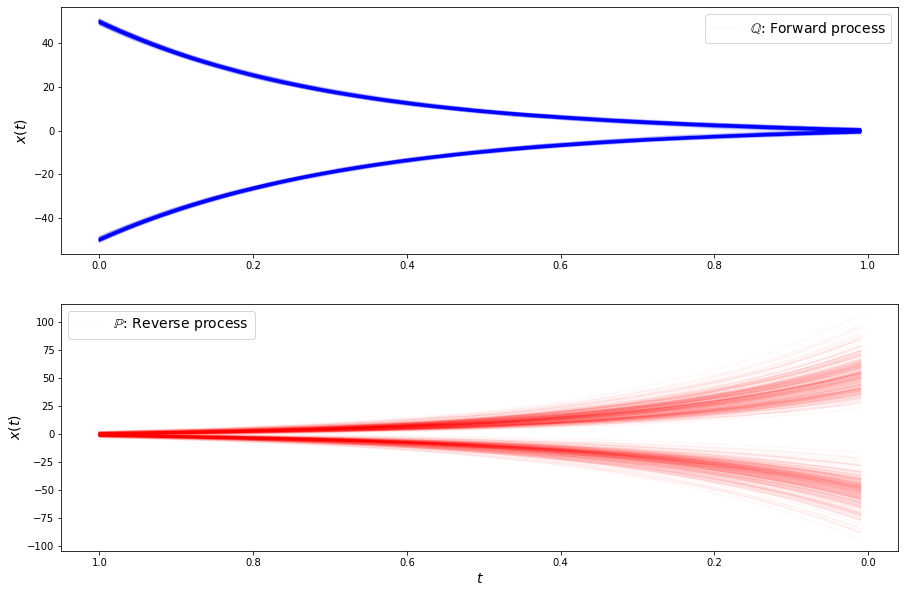

loss b 3.727966547012329
loss b 3.833862543106079
loss b 3.7327330112457275
loss b 3.686448097229004
loss b 3.763493299484253
loss b 3.770127534866333
loss b 3.7726895809173584
loss b 3.7146549224853516
loss b 3.696364402770996
loss b 3.6626932621002197
loss b 3.677027463912964
loss b 3.7044711112976074
loss b 3.7952210903167725
loss b 3.7932963371276855
loss b 3.691941976547241
loss b 3.7253661155700684
loss b 3.7544214725494385
loss b 3.7390453815460205
loss b 3.724518060684204
loss b 3.724397897720337
loss b 3.711085081100464
loss b 3.7045555114746094
loss f -0.03355293720960617
loss f -0.04807819798588753
loss f -0.01759975776076317
loss f -0.025305135175585747
loss f -0.026995154097676277
loss f -0.019781222566962242
loss f -0.03179509937763214
loss f -0.027648625895380974
loss f -0.05232452601194382
loss f -0.04104674980044365
loss f -0.04650188237428665
loss f -0.04152651131153107
loss f -0.027639469131827354
loss f -0.029512790963053703
loss f -0.04660353064537048
loss f -0.025

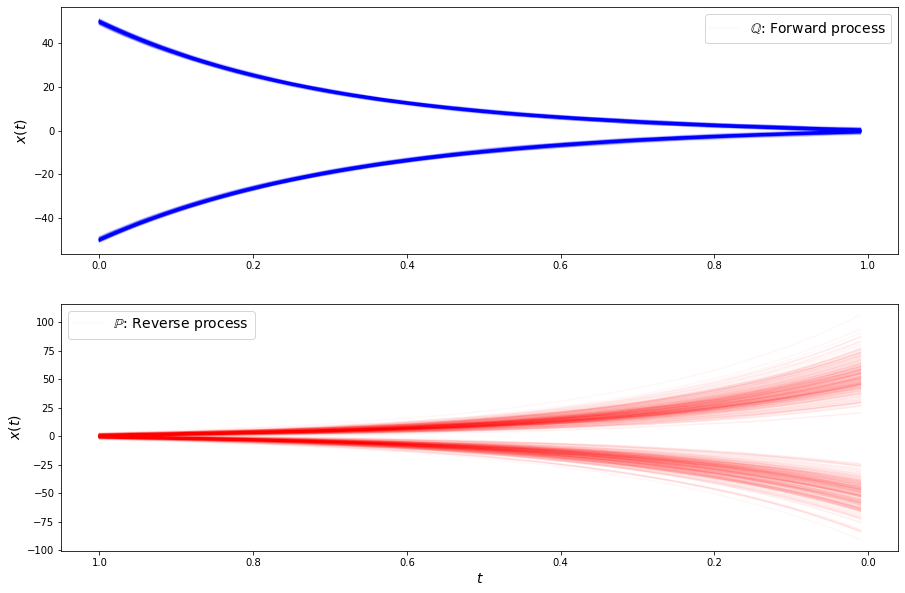

loss b 3.7537670135498047
loss b 3.7534079551696777
loss b 3.737936496734619
loss b 3.738193988800049
loss b 3.7120485305786133
loss b 3.7919931411743164
loss b 3.700646162033081
loss b 3.7802274227142334
loss b 3.6963908672332764
loss b 3.7178378105163574
loss b 3.684678077697754
loss b 3.783904552459717
loss b 3.7281863689422607
loss b 3.7286629676818848
loss b 3.7650375366210938
loss b 3.8052234649658203
loss b 3.7766990661621094
loss b 3.757612943649292
loss b 3.723283290863037
loss b 3.740760564804077
loss b 3.710728406906128
loss b 3.72070050239563
loss f -0.034212227910757065
loss f -0.028779366984963417
loss f -0.03648456186056137
loss f -0.027475496754050255
loss f -0.03509049117565155
loss f -0.021162748336791992
loss f -0.03505497798323631
loss f -0.016658032312989235
loss f -0.03877764940261841
loss f -0.03504388406872749
loss f -0.03651914745569229
loss f -0.028739482164382935
loss f -0.028335029259324074
loss f -0.03070780448615551
loss f -0.050007451325654984
loss f -0.0

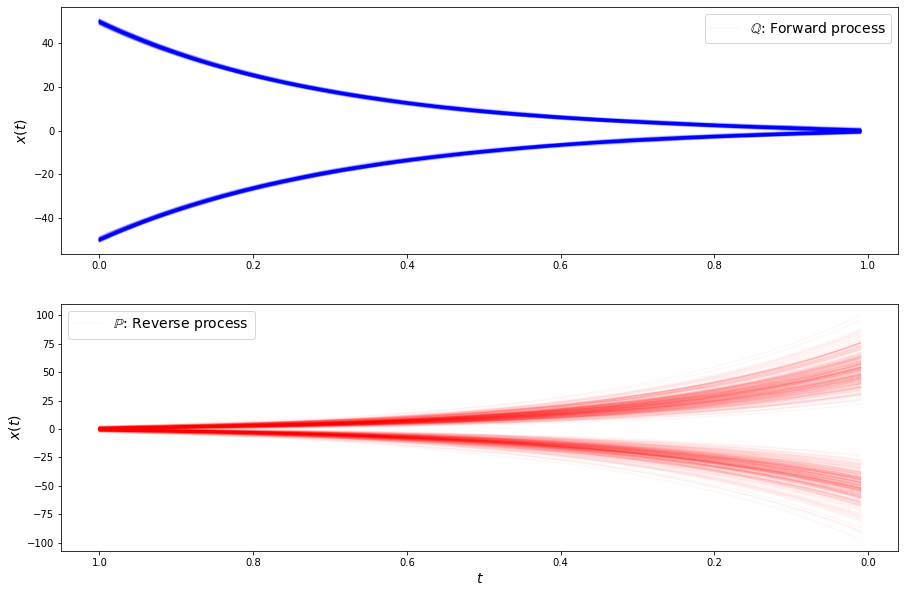

loss b 3.799412250518799
loss b 3.7831437587738037
loss b 3.7129299640655518
loss b 3.7702527046203613
loss b 3.7595276832580566
loss b 3.784745931625366
loss b 3.7387917041778564
loss b 3.8334848880767822
loss b 3.8252265453338623
loss b 3.7443830966949463
loss b 3.72278094291687
loss b 3.728076457977295
loss b 3.7165274620056152
loss b 3.74652099609375
loss b 3.735905170440674
loss b 3.706716299057007
loss b 3.6772139072418213
loss b 3.859142541885376
loss b 3.7565600872039795
loss b 3.7286124229431152
loss b 3.712301015853882
loss b 3.789215087890625
loss f -0.033428922295570374
loss f -0.0358288511633873
loss f -0.02340928465127945
loss f -0.02673548460006714
loss f -0.03962163254618645
loss f -0.03834894672036171
loss f -0.032040271908044815
loss f -0.02544579468667507
loss f -0.03920423611998558
loss f -0.04447381943464279
loss f -0.015099556185305119
loss f -0.02744346857070923
loss f -0.03474385291337967
loss f -0.04190770536661148
loss f -0.026064159348607063
loss f -0.0338509

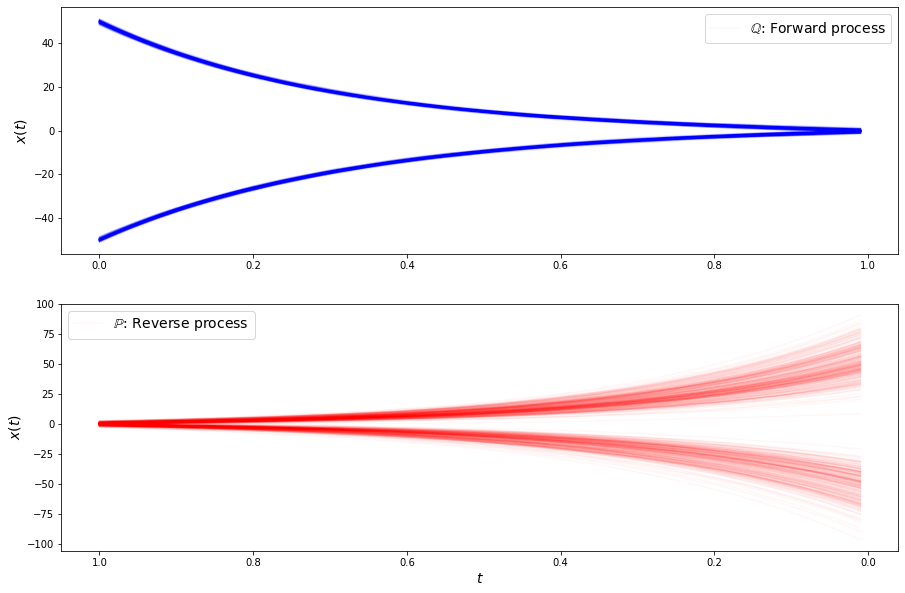

loss b 3.7519798278808594
loss b 3.73713755607605
loss b 3.800750970840454
loss b 3.7606918811798096
loss b 3.7535104751586914
loss b 3.7009944915771484
loss b 3.7081356048583984
loss b 3.7761518955230713
loss b 3.7943522930145264
loss b 3.683850049972534
loss b 3.7301595211029053
loss b 3.683140516281128
loss b 3.704658269882202
loss b 3.774718761444092
loss b 3.748600959777832
loss b 3.79773211479187
loss b 3.703326940536499
loss b 3.6983232498168945
loss b 3.785977840423584
loss b 3.7456600666046143
loss b 3.8068647384643555
loss b 3.7867934703826904
loss f -0.03827861696481705
loss f -0.04290742054581642
loss f -0.028651496395468712
loss f -0.03578752279281616
loss f -0.017057476565241814
loss f -0.023554006591439247
loss f -0.03599362075328827
loss f -0.033310215920209885
loss f -0.013807183131575584
loss f -0.02910764515399933
loss f -0.036724381148815155
loss f -0.032366618514060974
loss f -0.036335986107587814
loss f -0.04035467281937599
loss f -0.027452124282717705
loss f -0.0

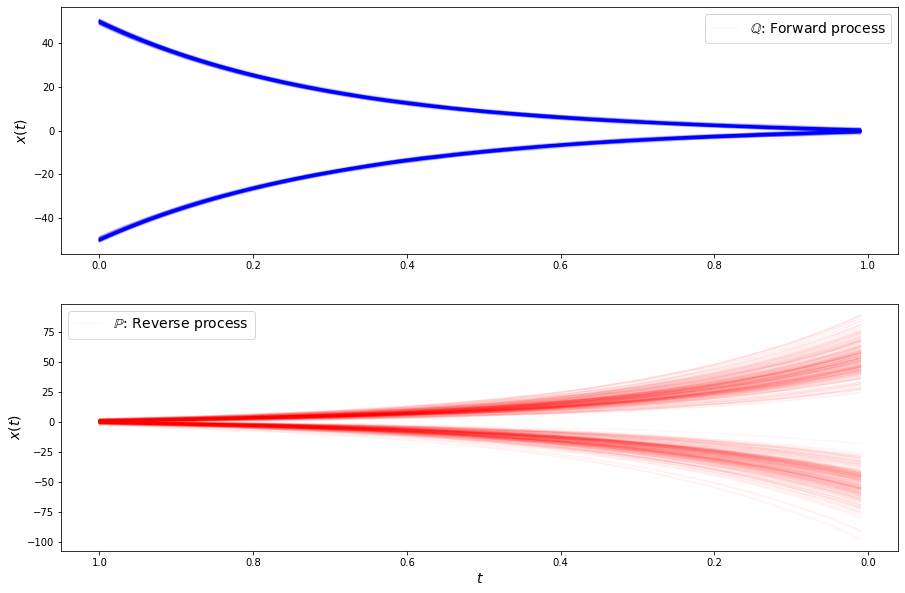

loss b 3.7658824920654297
loss b 3.767854928970337
loss b 3.7559750080108643
loss b 3.6687662601470947
loss b 3.708303451538086
loss b 3.7729852199554443
loss b 3.692387342453003
loss b 3.710979461669922
loss b 3.7982230186462402
loss b 3.782538890838623
loss b 3.7571914196014404
loss b 3.751479387283325
loss b 3.7958383560180664
loss b 3.7201521396636963
loss b 3.7584753036499023
loss b 3.7201271057128906
loss b 3.7188544273376465
loss b 3.6833019256591797
loss b 3.7518954277038574
loss b 3.799140453338623
loss b 3.7656948566436768
loss b 3.6942014694213867
loss f -0.02545548602938652
loss f -0.030227884650230408
loss f -0.03532023727893829
loss f -0.01667589694261551
loss f -0.0386839434504509
loss f -0.03700520470738411
loss f -0.042405128479003906
loss f -0.012424769811332226
loss f -0.03036937303841114
loss f -0.02604353427886963
loss f -0.03830265253782272
loss f -0.020377036184072495
loss f -0.03258804604411125
loss f -0.02456890419125557
loss f -0.03330196812748909
loss f -0.03

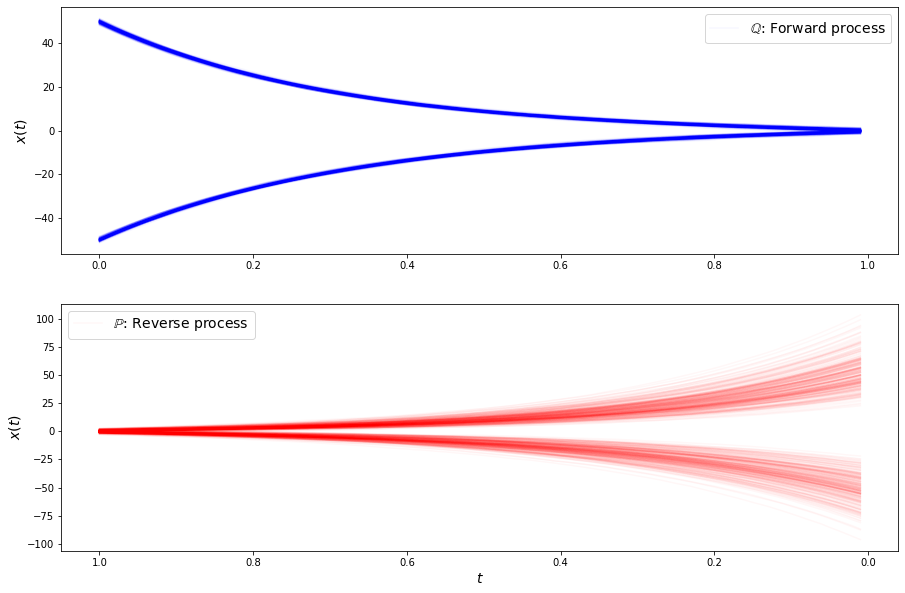

loss b 3.7719340324401855
loss b 3.739123821258545
loss b 3.6831297874450684
loss b 3.678317070007324
loss b 3.7020950317382812
loss b 3.751511573791504
loss b 3.7831220626831055
loss b 3.7617087364196777
loss b 3.800415515899658
loss b 3.6836626529693604
loss b 3.8312976360321045
loss b 3.725076913833618
loss b 3.7147834300994873
loss b 3.7863404750823975
loss b 3.7597410678863525
loss b 3.752000093460083
loss b 3.8319547176361084
loss b 3.720022678375244
loss b 3.7642130851745605
loss b 3.7494053840637207
loss b 3.71962571144104
loss b 3.7784409523010254
loss f -0.03575621172785759
loss f -0.024889523163437843
loss f -0.030815739184617996
loss f -0.0075938403606414795
loss f -0.037612661719322205
loss f -0.012339784763753414
loss f -0.019207222387194633
loss f -0.03945494815707207
loss f -0.038281675428152084
loss f -0.033793218433856964
loss f -0.037181150168180466
loss f -0.03371560946106911
loss f -0.03679659217596054
loss f -0.015567210502922535
loss f -0.02113283798098564
loss f

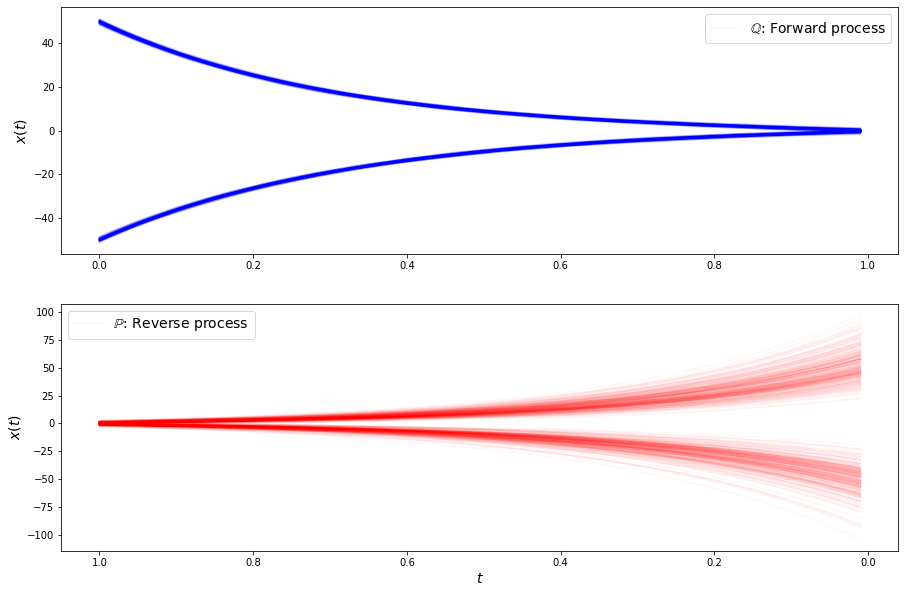

loss b 3.684283494949341
loss b 3.6684908866882324
loss b 3.674492597579956
loss b 3.7694432735443115
loss b 3.775242567062378
loss b 3.746269464492798
loss b 3.7047462463378906
loss b 3.6739227771759033
loss b 3.71303129196167
loss b 3.721052408218384
loss b 3.70845890045166
loss b 3.732063055038452
loss b 3.7345399856567383
loss b 3.7274980545043945
loss b 3.736449718475342
loss b 3.695744752883911
loss b 3.7867860794067383
loss b 3.7566189765930176
loss b 3.7837250232696533
loss b 3.773470401763916
loss b 3.7644405364990234
loss b 3.7077853679656982
loss f -0.039533160626888275
loss f -0.035134561359882355
loss f -0.017651613801717758
loss f -0.04566210135817528
loss f -0.023427944630384445
loss f -0.024913378059864044
loss f -0.022384239360690117
loss f -0.039132218807935715
loss f -0.006817087065428495
loss f -0.019361987709999084
loss f -0.04529760032892227
loss f -0.030469203367829323
loss f -0.03453020378947258
loss f -0.04072554409503937
loss f -0.03324531018733978
loss f -0.0

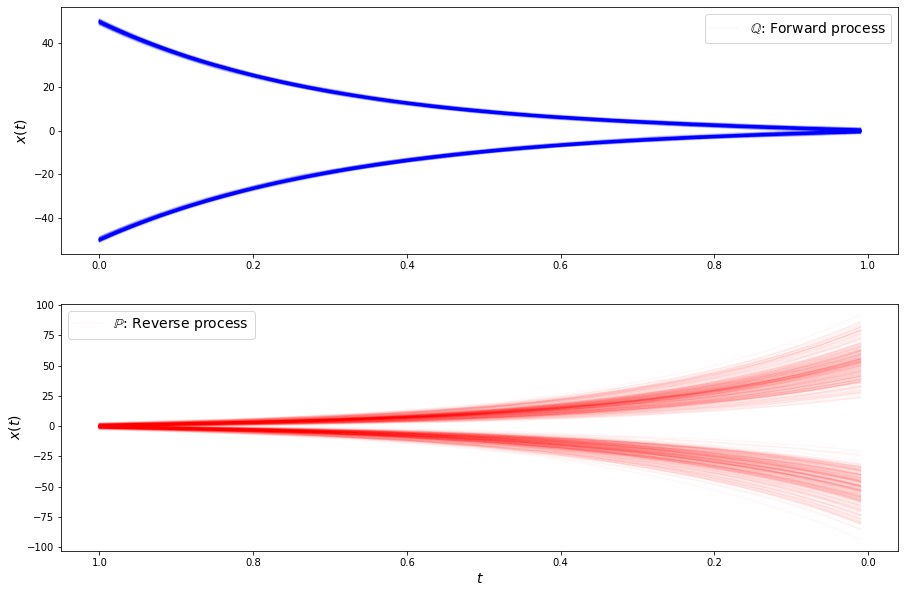

loss b 3.8017020225524902
loss b 3.7031335830688477
loss b 3.6598989963531494
loss b 3.7659084796905518
loss b 3.7096970081329346
loss b 3.752230405807495
loss b 3.7443532943725586
loss b 3.7624406814575195
loss b 3.733858108520508
loss b 3.718332052230835
loss b 3.7127716541290283
loss b 3.70687198638916
loss b 3.74247407913208
loss b 3.7291290760040283
loss b 3.7440507411956787
loss b 3.766721487045288
loss b 3.808589458465576
loss b 3.727806806564331
loss b 3.733865261077881
loss b 3.7296507358551025
loss b 3.796644449234009
loss b 3.7272374629974365
loss f -0.016720397397875786
loss f -0.02747330069541931
loss f -0.028812235221266747
loss f -0.0284596998244524
loss f -0.031052568927407265
loss f -0.04699144512414932
loss f -0.04123517498373985
loss f -0.044736284762620926
loss f -0.03293871507048607
loss f -0.034240275621414185
loss f -0.029498832300305367
loss f -0.052936553955078125
loss f -0.040032561868429184
loss f -0.03707179054617882
loss f -0.03826150298118591
loss f -0.050

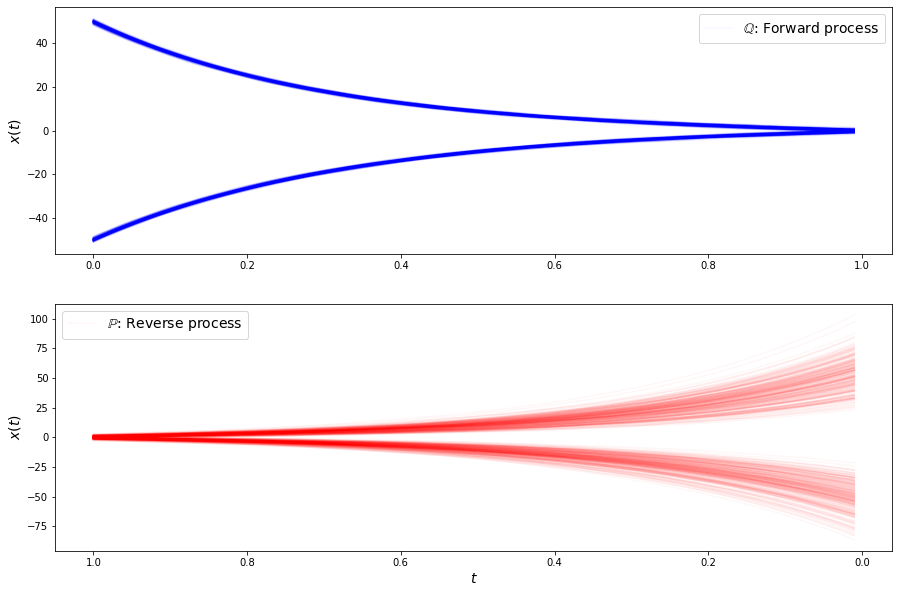

loss b 3.704355001449585
loss b 3.767443895339966
loss b 3.7505345344543457
loss b 3.8258564472198486
loss b 3.751046895980835
loss b 3.771498441696167
loss b 3.7777230739593506
loss b 3.8034210205078125
loss b 3.762500047683716
loss b 3.713214635848999
loss b 3.731316566467285
loss b 3.763277053833008
loss b 3.739027976989746
loss b 3.6715056896209717
loss b 3.8055384159088135
loss b 3.7017760276794434
loss b 3.8030660152435303
loss b 3.725386381149292
loss b 3.6952340602874756
loss b 3.6599206924438477
loss b 3.6736655235290527
loss b 3.73199200630188
loss f -0.023702898994088173
loss f -0.031160589307546616
loss f -0.02939603291451931
loss f -0.032868921756744385
loss f -0.037642817944288254
loss f -0.04005974158644676
loss f -0.04274769499897957
loss f -0.024569040164351463
loss f -0.030345570296049118
loss f -0.036505457013845444
loss f -0.035266827791929245
loss f -0.03462674096226692
loss f -0.05281253904104233
loss f -0.046640731394290924
loss f -0.03687327727675438
loss f -0.0

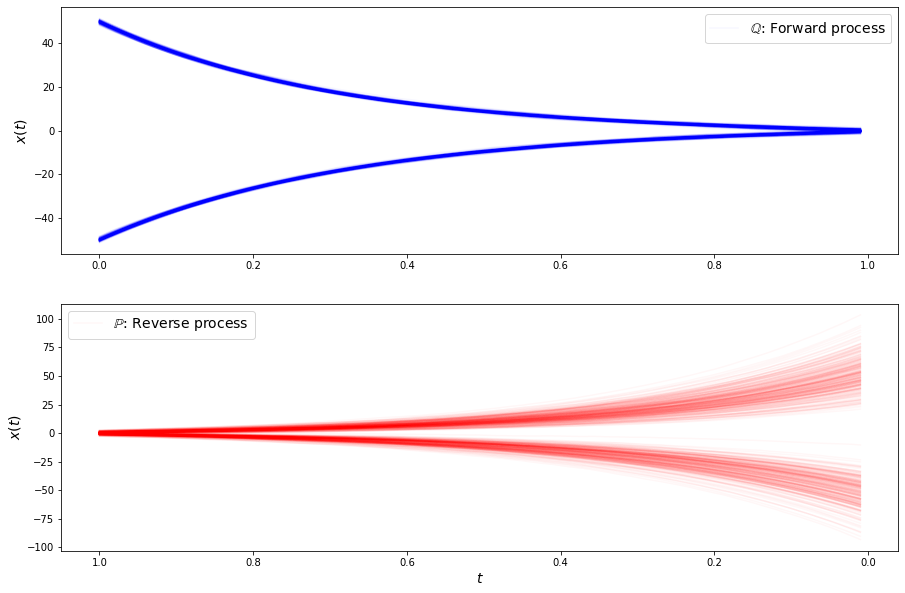

loss b 3.7127609252929688
loss b 3.7368791103363037
loss b 3.746607542037964
loss b 3.70573353767395
loss b 3.743544340133667
loss b 3.815004587173462
loss b 3.6796553134918213
loss b 3.736983060836792
loss b 3.7280585765838623
loss b 3.735062599182129
loss b 3.7141120433807373
loss b 3.800238609313965
loss b 3.7525675296783447
loss b 3.720252513885498
loss b 3.7782673835754395
loss b 3.7312631607055664
loss b 3.708873987197876
loss b 3.687272310256958
loss b 3.7744834423065186
loss b 3.7712626457214355
loss b 3.690880537033081
loss b 3.725466251373291
loss f -0.04215768724679947
loss f -0.04425732046365738
loss f -0.043239377439022064
loss f -0.042886294424533844
loss f -0.05397941544651985
loss f -0.0420466810464859
loss f -0.03776945173740387
loss f -0.031374819576740265
loss f -0.0317288339138031
loss f -0.028107058256864548
loss f -0.028161071240901947
loss f -0.04971720278263092
loss f -0.03482579067349434
loss f -0.03810577467083931
loss f -0.045686475932598114
loss f -0.0189815

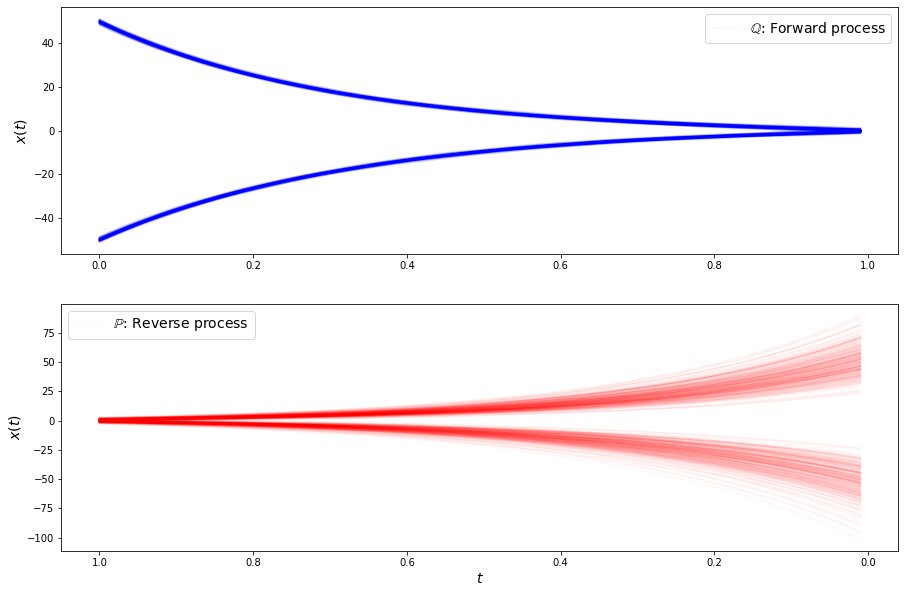

loss b 3.7112584114074707
loss b 3.742403507232666
loss b 3.7651774883270264
loss b 3.7035539150238037
loss b 3.6618223190307617
loss b 3.724398612976074
loss b 3.772768497467041
loss b 3.72102427482605
loss b 3.7020928859710693
loss b 3.708895444869995
loss b 3.728200912475586
loss b 3.759056568145752
loss b 3.6804909706115723
loss b 3.76532244682312
loss b 3.822103977203369
loss b 3.7205915451049805
loss b 3.7465405464172363
loss b 3.7464466094970703
loss b 3.759859085083008
loss b 3.7424306869506836
loss b 3.7351813316345215
loss b 3.712963104248047
loss f -0.047196511179208755
loss f -0.04336206242442131
loss f -0.053541094064712524
loss f -0.043190449476242065
loss f -0.03857129439711571
loss f -0.04892933741211891
loss f -0.042743656784296036
loss f -0.02969057857990265
loss f -0.042144227772951126
loss f -0.04189560189843178
loss f -0.04398062825202942
loss f -0.053175006061792374
loss f -0.039457812905311584
loss f -0.05044303089380264
loss f -0.03169906511902809
loss f -0.0524

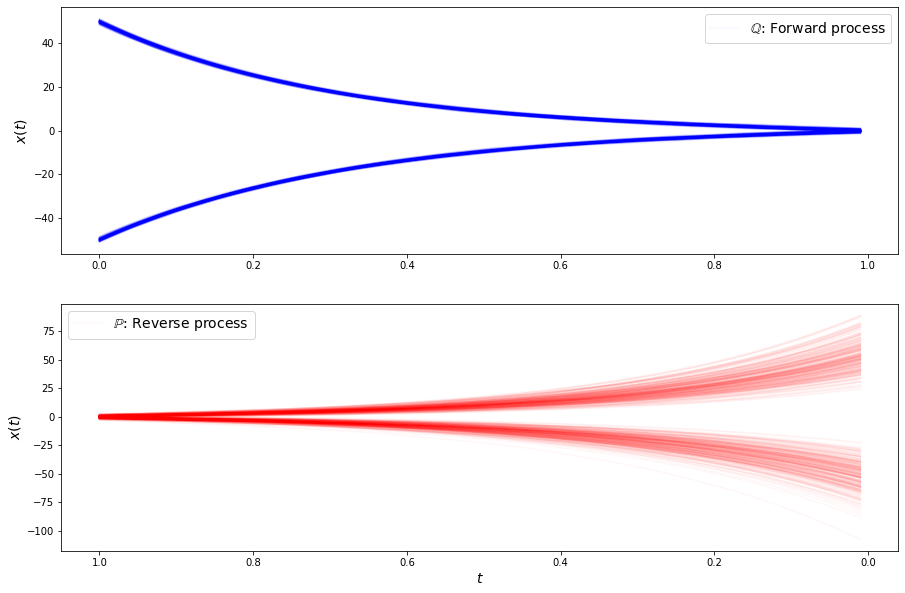

loss b 3.7475740909576416
loss b 3.8392014503479004
loss b 3.730936050415039
loss b 3.6722495555877686
loss b 3.7252724170684814
loss b 3.728192090988159
loss b 3.760824203491211
loss b 3.705009698867798
loss b 3.8695454597473145
loss b 3.963677406311035
loss b 3.972696542739868
loss b 3.7262349128723145
loss b 3.732226610183716
loss b 3.8424766063690186
loss b 3.855407476425171
loss b 3.875133991241455
loss b 3.8023300170898438
loss b 3.762028932571411
loss b 3.760596513748169
loss b 3.7180979251861572


In [ ]:
c.fit(1900, 22, plot=True)

In [ ]:
plt.plot(c.loss_f)
plt.show()
plt.plot(c.loss_b)

In [2]:
bb = lambda X, theta: -c.b_backward(X, theta)
t, Xts = c.sde_solver(X0=X1,dt=c.dt,  theta=c.theta_f,  beta=c.sigma, alfa=c.b_forward, N=c.number_time_steps)
t_, Xts_ = c.sde_solver(X0=X2, dt=c.dt,  theta=c.theta_b,  beta=c.sigma, alfa=bb, N=c.number_time_steps)

NameError: name 'c' is not defined

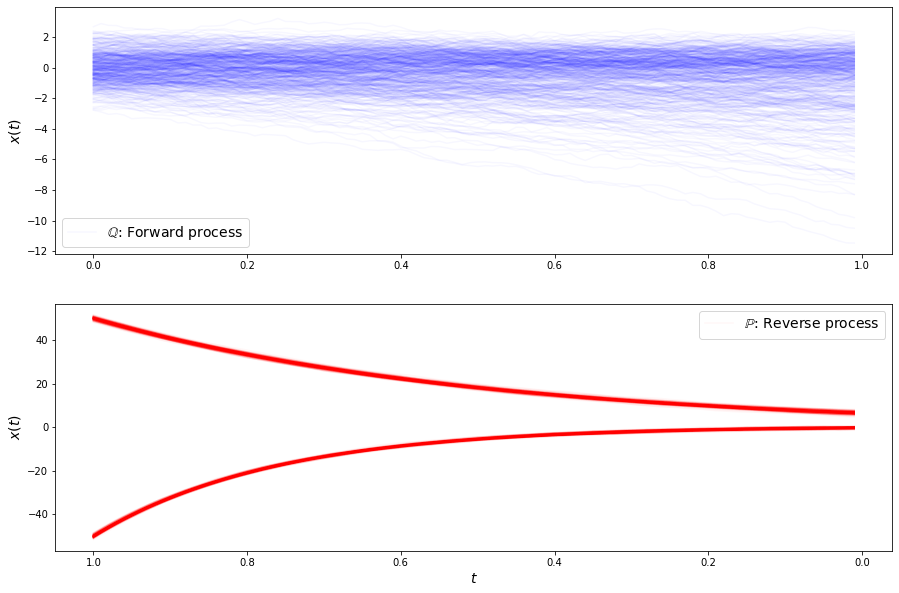

In [13]:
fn = 14
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
axs[1].set_xlabel("$t$", fontsize=fn)
axs[1].set_ylabel("$x(t)$", fontsize=fn)
axs[0].set_ylabel("$x(t)$", fontsize=fn)

tt = axs[1].get_xticks()
axs[1].set_xticks(tt.flatten() )
axs[1].set_xticklabels(list(map (lambda x: '{0:.1f}'.format((x)), tt))[::-1])

for i in range(n):
    label = "$\mathbb{Q}$: Forward process" if i == 0 else None
    axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03,  label=label)


for i in range(n):
    label = "$\mathbb{P}$: Reverse process" if i == 0 else None
    axs[1].plot(t_.flatten(), Xts_[i,...].flatten(), 'r', alpha=0.03, label=label)
    
axs[1].legend(fontsize=fn)
axs[0].legend(fontsize=fn)

plt.savefig("pig_0")

In [38]:
list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1]

['0.00', '0.20', '0.40', '0.60', '0.80', '1.00']

In [ ]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

In [ ]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [ ]:
batch_terminal_empirical_b = next(c.data_stream(False))

In [ ]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")

In [ ]:
    def plot_trajectories(self):
        bb = lambda X, theta: -self.b_backward(X, theta)
        t, Xts = c.sde_solver(
            X0=self.X1,dt=self.dt,  theta=self.theta_f,
            beta=self.sigma, alfa=self.b_forward, N=self.number_time_steps
        )
        t_, Xts_ = c.sde_solver(
            X0=self.X2, dt=self.dt,  theta=self.theta_b,
            beta=self.sigma, alfa=bb, N=self.number_time_steps
        )
        
        fn = 14
        fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
        axs[1].set_xlabel("$t$", fontsize=fn)
        axs[1].set_ylabel("$x(t)$", fontsize=fn)
        axs[0].set_ylabel("$x(t)$", fontsize=fn)

        tt = axs[1].get_xticks()
        axs[1].set_xticks(tt.flatten() )
        axs[1].set_xticklabels(list(map (lambda x: '{0:.1f}'.format((x)), tt))[::-1])

        for i in range(n):
            label = "$\mathbb{Q}$: Forward process" if i == 0 else None
            axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03,  label=label)


        for i in range(n):
            label = "$\mathbb{P}$: Reverse process" if i == 0 else None
            axs[1].plot(t_.flatten(), Xts_[i,...].flatten(), 'r', alpha=0.03, label=label)

        axs[1].legend(fontsize=fn)
        axs[0].legend(fontsize=fn)

        plt.show()    